In [5]:
!pip install numpy pandas scikit-learn matplotlib seaborn umap-learn
import pandas as pd
data = pd.read_csv("/content/drive/MyDrive/FML_Project/data.csv")

In [6]:
"""
I started by dropping identifier columns that have unique values for every row.
Then I removed highly correlated numeric columns (>0.90 correlation) to reduce redundancy.
CRITICAL CHANGE: For Logistic Regression, I replaced Ordinal Encoding with One-Hot Encoding
to avoid imposing false numeric order on categorical variables.
I used drop_first=True to prevent the 'Dummy Variable Trap' (multicollinearity).
I applied a VarianceThreshold to remove features with near-zero variance.
I converted boolean-like text columns to binary 0/1 format.
I scaled all numeric features using StandardScaler (Essential for Logistic Regression convergence).
I created a baseline clean dataset without noise.
I performed train/test split with 75-25 ratio and stratification on the target.
"""

import numpy as np
import pandas as pd # Ensure pandas is imported for get_dummies
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

# 1. Drop Identifiers
identifier_cols = [col for col in data.columns if data[col].nunique() == len(data)]
print("Identifier columns dropped:", identifier_cols)
data = data.drop(columns=identifier_cols)

# 2. Drop Highly Correlated Columns (Crucial for Logistic Regression)
# LR weights become unstable if features are highly correlated (multicollinearity)
numeric_cols = data.select_dtypes(include=['float64','int64']).columns.tolist()
corr_matrix = data[numeric_cols].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop_corr = [column for column in upper.columns if any(upper[column] > 0.90)]
data = data.drop(columns=to_drop_corr)
print(f"Dropped {len(to_drop_corr)} correlated features.")

# 3. Handle Boolean-like columns BEFORE One-Hot Encoding
bool_like_cols = []
for col in data.columns:
    # Check simple small sets of string values
    if data[col].dtype == 'object':
        unique_vals = set(str(v).lower() for v in data[col].dropna().unique())
        if unique_vals.issubset({"true","false","t","f","yes","no","y","n"}):
            bool_like_cols.append(col)

for col in bool_like_cols:
    data[col] = data[col].astype(str).str.lower().map({
        "true":1,"t":1,"yes":1,"y":1,
        "false":0,"f":0,"no":0,"n":0
    }).astype(int)

# 4. CRITICAL CHANGE: One-Hot Encoding instead of Ordinal
# We drop the old target 'loan_status' first so it doesn't get encoded
if "loan_status" in data.columns:
    data = data.drop(columns=["loan_status"])

categorical_cols = data.select_dtypes(include=['object']).columns.tolist()

# Apply One-Hot Encoding with drop_first=True to avoid collinearity
print("Applying One-Hot Encoding for Logistic Regression...")
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# 5. NEW STEP: Variance Threshold
# Remove constant or quasi-constant features which offer no signal to LR
selector = VarianceThreshold(threshold=0.01)
# We fit on the data to find columns to keep, then apply
# Note: We temporarily handle columns to keep DataFrame structure
try:
    data_selected = selector.fit_transform(data)
    # Reconstruct DataFrame with kept column names
    mask = selector.get_support()
    new_features = data.columns[mask]
    data = pd.DataFrame(data_selected, columns=new_features, index=data.index)
    print(f"Variance Threshold applied. Shape: {data.shape}")
except ValueError:
    print("Variance Threshold skipped (likely no low-variance features found).")

# 6. Scale Features (Essential for Gradient Descent in LR)
# Note: Identify numeric columns again as One-Hot created new 0/1 numeric cols
numeric_cols = data.select_dtypes(include=['float64','int64', 'uint8', 'int32']).columns.tolist()

if "default_binary" in numeric_cols:
    numeric_cols.remove("default_binary")

scaler = StandardScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])
print("Scaling complete. Shape:", data.shape)

# 7. Create Baseline & Split
noerror_data = data.copy()
print("Baseline Logistic Regression dataset created.")
print(noerror_data.shape)

X = noerror_data.drop(columns=["default_binary"])
y = noerror_data["default_binary"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Logistic Regression preprocessing complete. Ready for model training.")

Identifier columns dropped: []
Dropped 10 correlated features.
Applying One-Hot Encoding for Logistic Regression...
Variance Threshold applied. Shape: (10000, 260)
Scaling complete. Shape: (10000, 260)
Baseline Logistic Regression dataset created.
(10000, 260)
Train: (7500, 259) Test: (2500, 259)
Logistic Regression preprocessing complete. Ready for model training.


In [7]:
"""
I created a baseline Logistic Regression classifier with initial hyperparameters.
I set max_iter to 1000 to ensure the solver converges (default is 100, which is often too low).
I used random_state=42 for reproducibility.
I selected the 'liblinear' solver which is generally robust for binary classification tasks.
I kept other parameters at default to establish a baseline performance.
I trained the model on my preprocessed training data.
"""

from sklearn.linear_model import LogisticRegression

# LOGISTIC REGRESSION CHANGE:
# - Removed 'n_estimators' (Trees don't exist here).
# - Added 'max_iter=1000' because LR needs more iterations to find the optimal line than the default allows.
# - Added 'solver="liblinear"' (Good for binary classification).
# - Added 'n_jobs=-1' (only works with specific solvers like 'lbfgs' for multiclass,
#   but for 'liblinear' it's single-threaded. If you want parallel, use 'saga' + n_jobs=-1).
#   For simplicity/stability, we stick to standard settings:

log_reg = LogisticRegression(
    random_state=42,
    solver='liblinear', # Recommended for smaller datasets/binary classification
    max_iter=1000       # Increased from default (100) to ensure convergence
)

log_reg.fit(X_train, y_train)

results = {
    "baseline_lr": {}
}

print("Baseline Logistic Regression trained (max_iter=1000).")

Baseline Logistic Regression trained (max_iter=1000).


C=0.001: Train=0.9304, Test=0.9336
C=0.01: Train=0.9676, Test=0.9640
C=0.1: Train=0.9855, Test=0.9796
C=1: Train=0.9945, Test=0.9840
C=10: Train=0.9988, Test=0.9864
C=100: Train=0.9999, Test=0.9892
C=1000: Train=1.0000, Test=0.9872


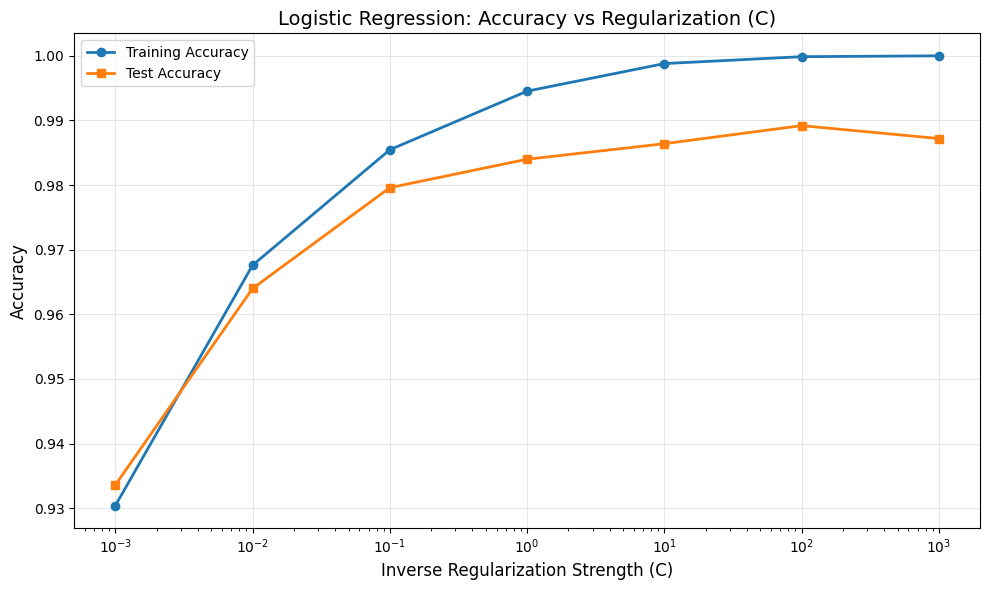


Best C: 100 with Test Accuracy: 0.9892


In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression

c_range = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_accuracies = []
test_accuracies = []

for c_val in c_range:
    lr_temp = LogisticRegression(
        C=c_val,
        random_state=42,
        solver='liblinear',
        max_iter=1000
    )
    lr_temp.fit(X_train, y_train)

    train_acc = lr_temp.score(X_train, y_train)
    test_acc = lr_temp.score(X_test, y_test)

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"C={c_val}: Train={train_acc:.4f}, Test={test_acc:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(c_range, train_accuracies, marker='o', label='Training Accuracy', linewidth=2)
plt.plot(c_range, test_accuracies, marker='s', label='Test Accuracy', linewidth=2)
plt.xscale('log')
plt.xlabel('Inverse Regularization Strength (C)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Logistic Regression: Accuracy vs Regularization (C)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

best_idx = test_accuracies.index(max(test_accuracies))
best_c = c_range[best_idx]
print(f"\nBest C: {best_c} with Test Accuracy: {test_accuracies[best_idx]:.4f}")

In [9]:
from sklearn.metrics import accuracy_score

y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

results["baseline_lr"]["train_accuracy"] = train_acc
results["baseline_lr"]["test_accuracy"] = test_acc
results["baseline_lr"]["train_predictions"] = y_train_pred
results["baseline_lr"]["test_predictions"] = y_test_pred

print("=" * 50)
print("LOGISTIC REGRESSION MODEL ACCURACY")
print("=" * 50)
print(f"Training Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"Test Accuracy:     {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Difference:        {(train_acc - test_acc):.4f}")
print("=" * 50)

LOGISTIC REGRESSION MODEL ACCURACY
Training Accuracy: 0.9945 (99.45%)
Test Accuracy:     0.9840 (98.40%)
Difference:        0.0105


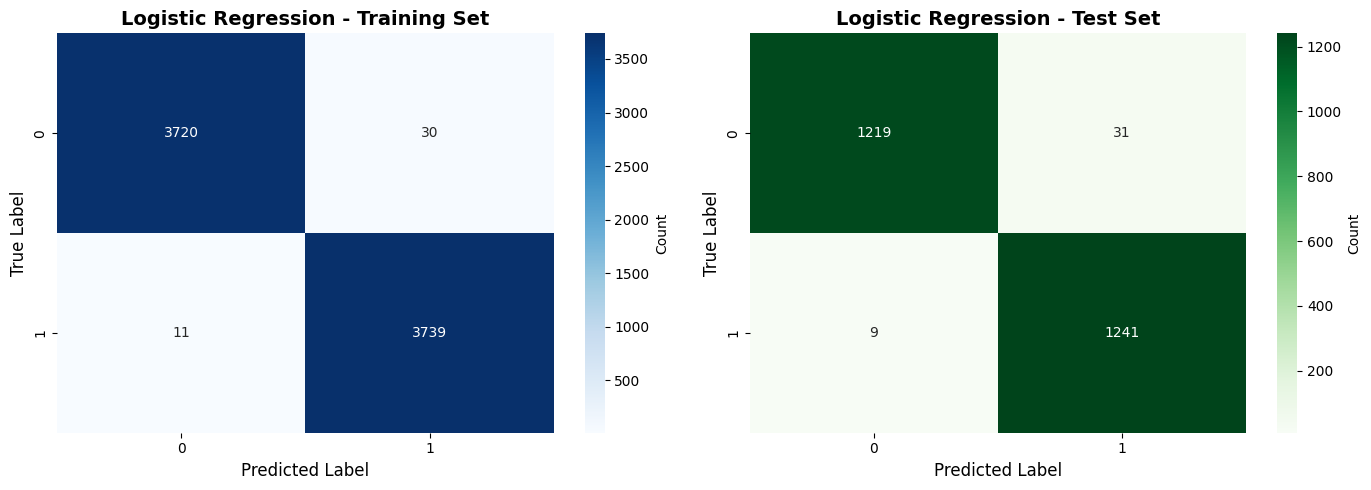

Confusion Matrix - Training Set:
[[3720   30]
 [  11 3739]]

Confusion Matrix - Test Set:
[[1219   31]
 [   9 1241]]


In [10]:
"""
I created confusion matrices for both training and test sets.
I used sklearn's confusion_matrix to calculate true/false positives and negatives.
I visualized both matrices using seaborn heatmaps for better interpretation.
I displayed the matrices side by side to compare training vs test performance
for the Logistic Regression model.
"""
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            cbar_kws={'label': 'Count'})
axes[0].set_title('Logistic Regression - Training Set', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            cbar_kws={'label': 'Count'})
axes[1].set_title('Logistic Regression - Test Set', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)

plt.tight_layout()
plt.show()

print("Confusion Matrix - Training Set:")
print(cm_train)
print("\nConfusion Matrix - Test Set:")
print(cm_test)

In [11]:
"""
I calculated precision, recall, and F1-score for my Logistic Regression model.
I computed these metrics for both training and test sets.
I used sklearn's classification_report for a comprehensive summary.
I also calculated individual metrics to store in my results dictionary.
I printed detailed reports to evaluate model performance across different metrics.
"""
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Calculate metrics using the predictions generated in the previous step
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Store results in the Logistic Regression dictionary key
results["baseline_lr"]["train_precision"] = train_precision
results["baseline_lr"]["train_recall"] = train_recall
results["baseline_lr"]["train_f1"] = train_f1
results["baseline_lr"]["test_precision"] = test_precision
results["baseline_lr"]["test_recall"] = test_recall
results["baseline_lr"]["test_f1"] = test_f1

print("=" * 60)
print("LOGISTIC REGRESSION: PRECISION / RECALL / F1-SCORE")
print("=" * 60)
print("\nTRAINING SET:")
print(f"  Precision: {train_precision:.4f}")
print(f"  Recall:    {train_recall:.4f}")
print(f"  F1-Score:  {train_f1:.4f}")

print("\nTEST SET:")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall:    {test_recall:.4f}")
print(f"  F1-Score:  {test_f1:.4f}")
print("=" * 60)

print("\n\nDETAILED CLASSIFICATION REPORT - TEST SET:")
print(classification_report(y_test, y_test_pred, target_names=['No Default', 'Default']))

LOGISTIC REGRESSION: PRECISION / RECALL / F1-SCORE

TRAINING SET:
  Precision: 0.9920
  Recall:    0.9971
  F1-Score:  0.9945

TEST SET:
  Precision: 0.9756
  Recall:    0.9928
  F1-Score:  0.9841


DETAILED CLASSIFICATION REPORT - TEST SET:
              precision    recall  f1-score   support

  No Default       0.99      0.98      0.98      1250
     Default       0.98      0.99      0.98      1250

    accuracy                           0.98      2500
   macro avg       0.98      0.98      0.98      2500
weighted avg       0.98      0.98      0.98      2500



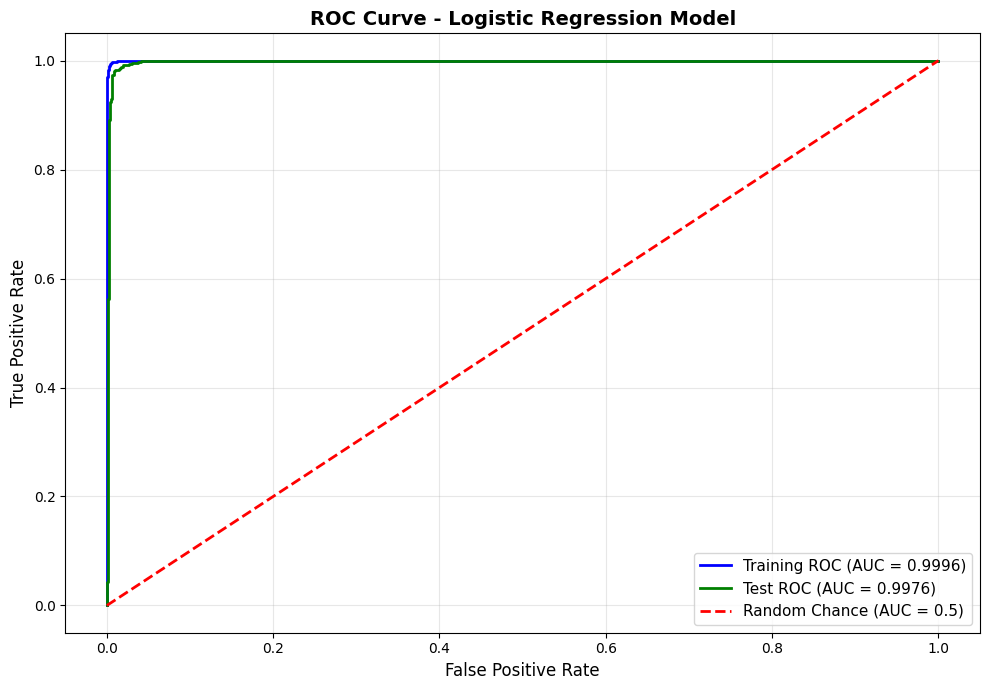

LOGISTIC REGRESSION: ROC-AUC SCORES
Training AUC: 0.9996
Test AUC:     0.9976


In [12]:
"""
I calculated the ROC-AUC score to evaluate my Logistic Regression model's discrimination ability.
I used predict_proba to get probability scores for the positive class.
I computed ROC curve coordinates using sklearn's roc_curve function.
I calculated AUC scores for both training and test sets.
I plotted the ROC curves to visualize model performance against random chance.
"""
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

y_train_proba = log_reg.predict_proba(X_train)[:, 1]
y_test_proba = log_reg.predict_proba(X_test)[:, 1]

train_auc = roc_auc_score(y_train, y_train_proba)
test_auc = roc_auc_score(y_test, y_test_proba)

results["baseline_lr"]["train_auc"] = train_auc
results["baseline_lr"]["test_auc"] = test_auc

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(10, 7))
plt.plot(fpr_train, tpr_train, label=f'Training ROC (AUC = {train_auc:.4f})',
         linewidth=2, color='blue')
plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC = {test_auc:.4f})',
         linewidth=2, color='green')
plt.plot([0, 1], [0, 1], 'r--', label='Random Chance (AUC = 0.5)', linewidth=2)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Logistic Regression Model', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("=" * 50)
print("LOGISTIC REGRESSION: ROC-AUC SCORES")
print("=" * 50)
print(f"Training AUC: {train_auc:.4f}")
print(f"Test AUC:     {test_auc:.4f}")
print("=" * 50)

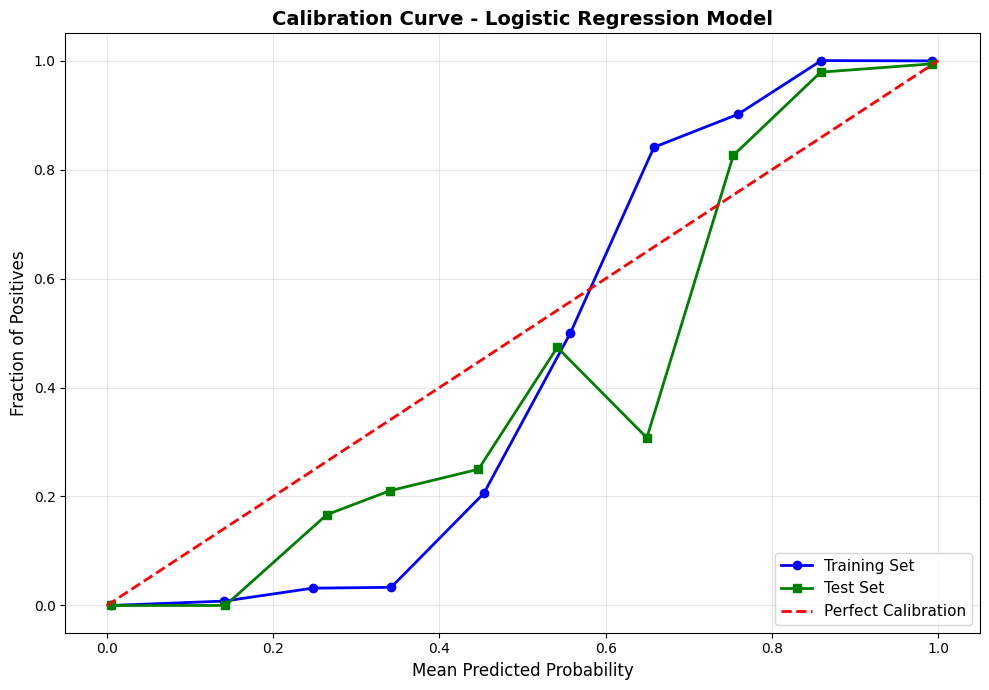

LOGISTIC REGRESSION: CALIBRATION CURVE ANALYSIS
A well-calibrated model's curve follows the diagonal line.
Logistic Regression is generally well-calibrated compared to Tree models.
Points above the line indicate under-confidence.
Points below the line indicate over-confidence.


In [13]:
"""
I created calibration curves to assess how well my Logistic Regression model's predicted probabilities match actual outcomes.
I used sklearn's calibration_curve to bin predictions and calculate true frequencies.
I plotted calibration curves for both training and test sets.
I included a diagonal reference line representing perfect calibration.
I analyzed whether my model is over-confident or under-confident in its predictions.
"""
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Note: y_train_proba and y_test_proba are assumed to be from the previous ROC step
# If running standalone, uncomment the next two lines:
# y_train_proba = log_reg.predict_proba(X_train)[:, 1]
# y_test_proba = log_reg.predict_proba(X_test)[:, 1]

prob_true_train, prob_pred_train = calibration_curve(y_train, y_train_proba, n_bins=10)
prob_true_test, prob_pred_test = calibration_curve(y_test, y_test_proba, n_bins=10)

plt.figure(figsize=(10, 7))
plt.plot(prob_pred_train, prob_true_train, marker='o', linewidth=2,
         label='Training Set', color='blue')
plt.plot(prob_pred_test, prob_true_test, marker='s', linewidth=2,
         label='Test Set', color='green')
plt.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect Calibration')

plt.xlabel('Mean Predicted Probability', fontsize=12)
plt.ylabel('Fraction of Positives', fontsize=12)
plt.title('Calibration Curve - Logistic Regression Model', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("=" * 50)
print("LOGISTIC REGRESSION: CALIBRATION CURVE ANALYSIS")
print("=" * 50)
print("A well-calibrated model's curve follows the diagonal line.")
print("Logistic Regression is generally well-calibrated compared to Tree models.")
print("Points above the line indicate under-confidence.")
print("Points below the line indicate over-confidence.")
print("=" * 50)

Original label distribution: [3750 3750]
Noisy label distribution:    [3770 3730]

LOGISTIC REGRESSION WITH 10% SYMMETRIC NOISE
Accuracy:  0.9576
Precision: 0.9554
Recall:    0.9600
F1 Score:  0.9577
AUC Score: 0.9928



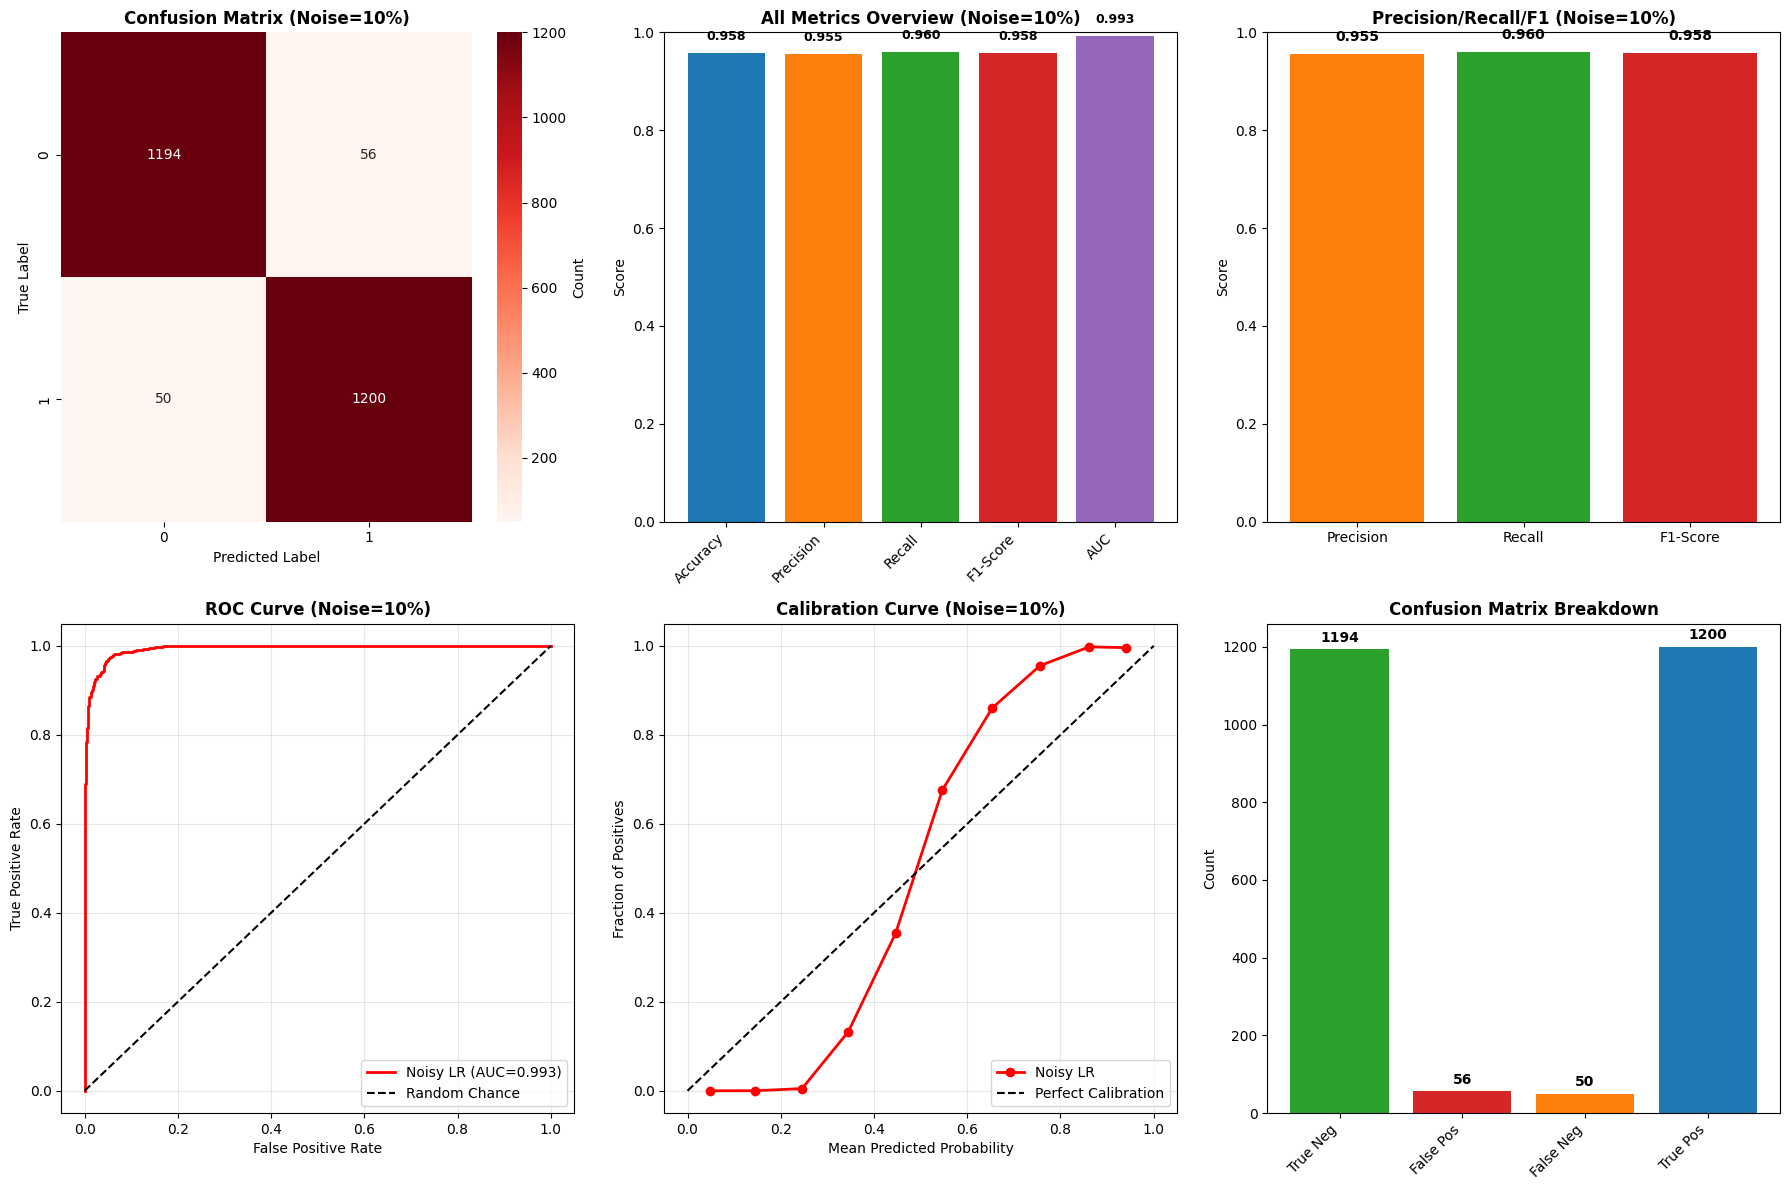


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.96      0.96      0.96      1250
     Default       0.96      0.96      0.96      1250

    accuracy                           0.96      2500
   macro avg       0.96      0.96      0.96      2500
weighted avg       0.96      0.96      0.96      2500



In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                            recall_score, f1_score, roc_curve, roc_auc_score,
                            classification_report)
from sklearn.calibration import calibration_curve

# ---------------------------------------------------------
# FIXED FUNCTION: Enforces Integer Type
# ---------------------------------------------------------
def inject_symmetric_noise(y, noise_rate, random_state=42):
    np.random.seed(random_state)

    # FIX: Force input to be integer array
    y_noisy = np.array(y).copy().astype(int)

    n_samples = len(y)
    n_noisy = int(noise_rate * n_samples)

    flip_indices = np.random.choice(n_samples, size=n_noisy, replace=False)

    # Flip 0->1 and 1->0
    y_noisy[flip_indices] = 1 - y_noisy[flip_indices]

    return y_noisy

# ---------------------------------------------------------
# EXECUTION
# ---------------------------------------------------------
p = 0.10

# Pass .values to ensure we are working with numpy array, and cast to int
y_train_noisy = inject_symmetric_noise(y_train.values, noise_rate=p)

# FIX: Cast to int explicitly inside bincount just in case
print("Original label distribution:", np.bincount(y_train.astype(int)))
print("Noisy label distribution:   ", np.bincount(y_train_noisy.astype(int)))

# Initialize Logistic Regression
lr_noisy = LogisticRegression(
    solver='liblinear',
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)

# Train
lr_noisy.fit(X_train, y_train_noisy)

# Predict
y_pred_noisy = lr_noisy.predict(X_test)
y_prob_noisy = lr_noisy.predict_proba(X_test)[:, 1]

# Calculate Metrics
acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

# Store Results
if "noise_results_lr" not in results:
    results["noise_results_lr"] = {}

results["noise_results_lr"][f"symmetric_{p}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

# Print Summary
print(f"\n{'='*60}")
print(f"LOGISTIC REGRESSION WITH {int(p*100)}% SYMMETRIC NOISE")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

# ---------------------------------------------------------
# VISUALIZATION
# ---------------------------------------------------------
fig = plt.figure(figsize=(18, 12))

# 1. Confusion Matrix
plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 2. All Metrics Bar Chart
plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. Precision/Recall/F1 Bar Chart
plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. ROC Curve
plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Noisy LR (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 5. Calibration Curve
plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Noisy LR', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 6. CM Breakdown
plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01,
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

Original label distribution: [3750 3750]
Noisy label distribution:    [3752 3748]

LOGISTIC REGRESSION WITH 20% SYMMETRIC NOISE
Accuracy:  0.9280
Precision: 0.9226
Recall:    0.9344
F1 Score:  0.9285
AUC Score: 0.9841



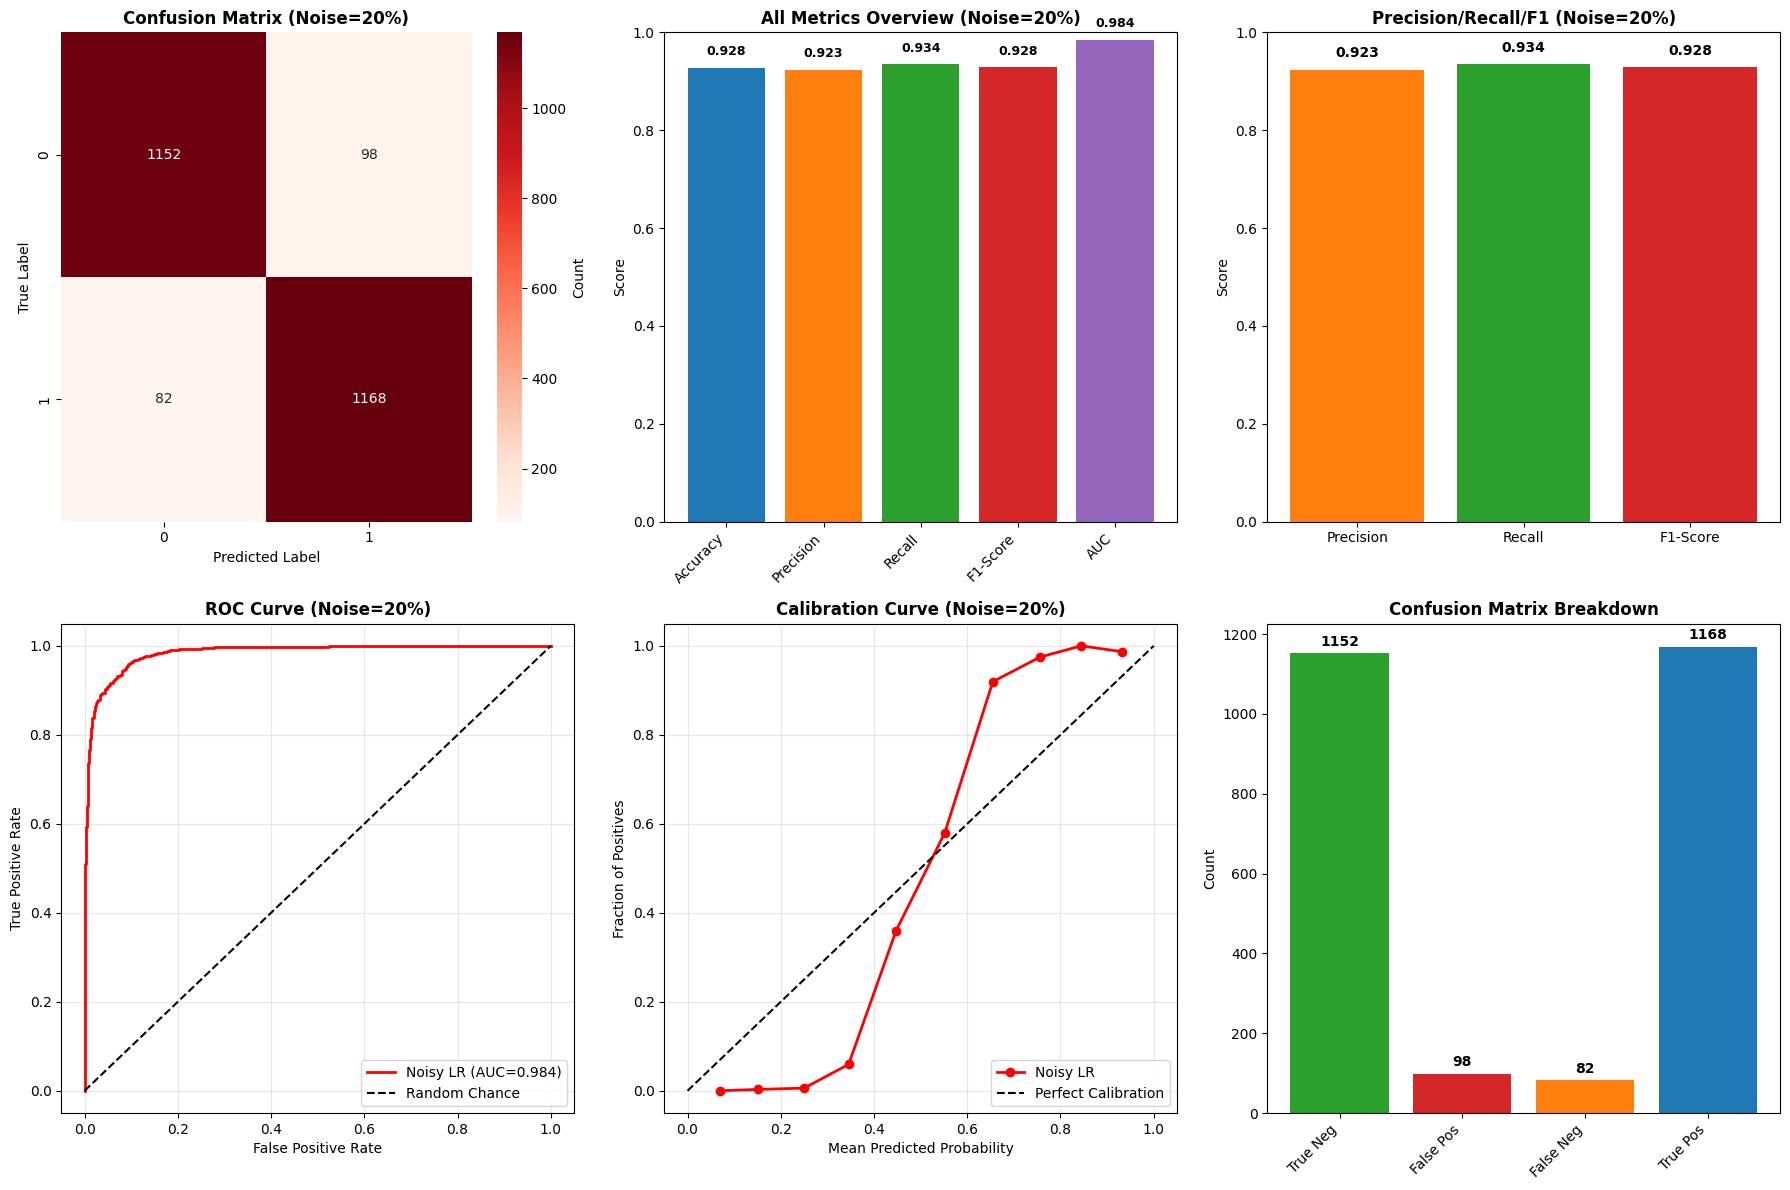


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.93      0.92      0.93      1250
     Default       0.92      0.93      0.93      1250

    accuracy                           0.93      2500
   macro avg       0.93      0.93      0.93      2500
weighted avg       0.93      0.93      0.93      2500



In [17]:
"""
I introduced symmetric noise to my training labels by randomly flipping a percentage of them.
I trained a new Logistic Regression model on the noisy labels.
I evaluated this noisy model using all five metrics: Accuracy, Confusion Matrix, Precision/Recall/F1, ROC-AUC, and Calibration.
I created comprehensive visualizations to compare the noisy model's performance.
I stored all results for comparison with the baseline model.
"""
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                            recall_score, f1_score, roc_curve, roc_auc_score,
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_symmetric_noise(y, noise_rate, random_state=42):
    np.random.seed(random_state)
    # Ensure integer type to prevent TypeError
    y_noisy = np.array(y).copy().astype(int)
    n_samples = len(y)
    n_noisy = int(noise_rate * n_samples)

    flip_indices = np.random.choice(n_samples, size=n_noisy, replace=False)

    # Flip 0->1 and 1->0
    y_noisy[flip_indices] = 1 - y_noisy[flip_indices]

    return y_noisy

p = 0.20

y_train_noisy = inject_symmetric_noise(y_train.values, noise_rate=p)

print("Original label distribution:", np.bincount(y_train.astype(int)))
print("Noisy label distribution:   ", np.bincount(y_train_noisy))

lr_noisy = LogisticRegression(
    solver='liblinear',
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)

lr_noisy.fit(X_train, y_train_noisy)

y_pred_noisy = lr_noisy.predict(X_test)
y_prob_noisy = lr_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results_lr" not in results:
    results["noise_results_lr"] = {}

results["noise_results_lr"][f"symmetric_{p}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"LOGISTIC REGRESSION WITH {int(p*100)}% SYMMETRIC NOISE")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Noisy LR (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Noisy LR', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01,
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

Original label distribution: [3750 3750]
Noisy label distribution:    [3743 3757]

LOGISTIC REGRESSION WITH 33% SYMMETRIC NOISE
Accuracy:  0.8756
Precision: 0.8648
Recall:    0.8904
F1 Score:  0.8774
AUC Score: 0.9452



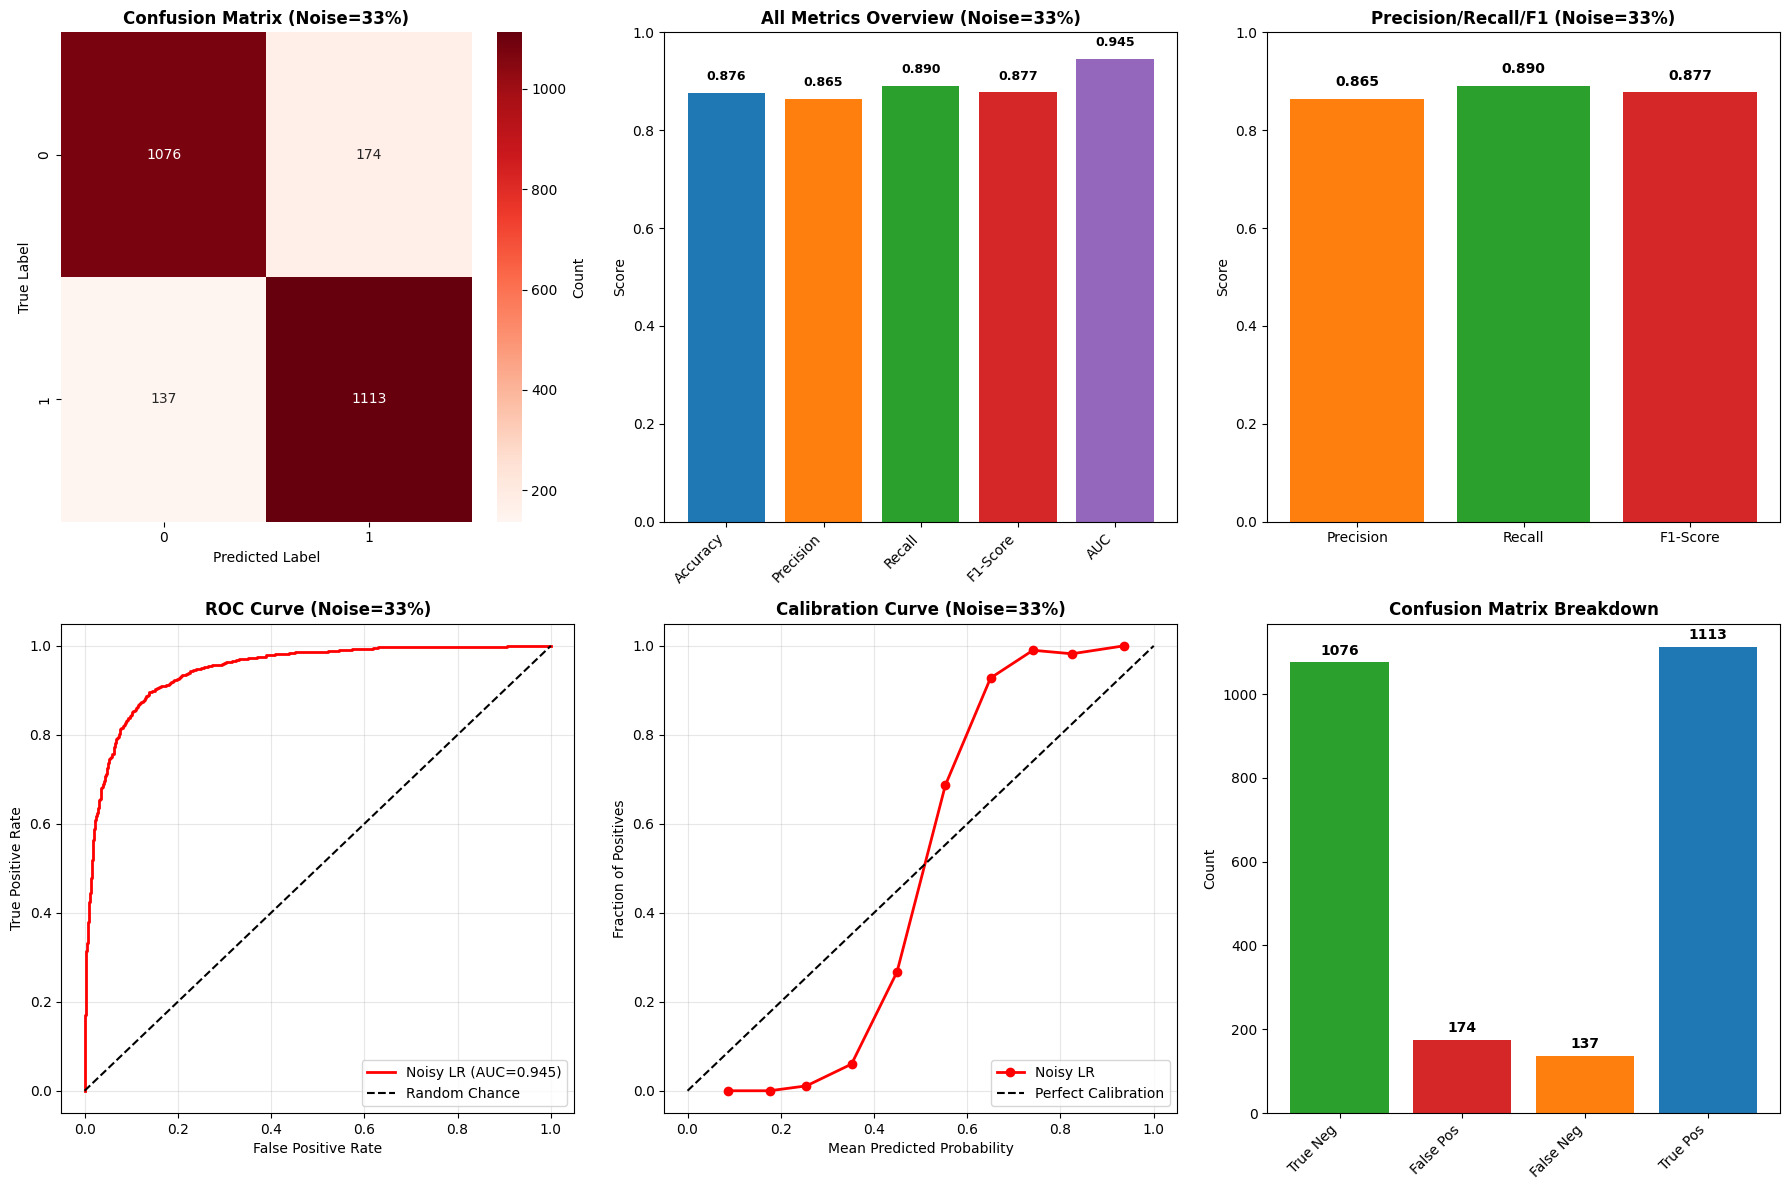


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.89      0.86      0.87      1250
     Default       0.86      0.89      0.88      1250

    accuracy                           0.88      2500
   macro avg       0.88      0.88      0.88      2500
weighted avg       0.88      0.88      0.88      2500



In [18]:
"""
I introduced symmetric noise (33%) to my training labels by randomly flipping them.
I trained a new Logistic Regression model on the noisy labels.
I evaluated this noisy model using all five metrics: Accuracy, Confusion Matrix, Precision/Recall/F1, ROC-AUC, and Calibration.
I created comprehensive visualizations to compare the noisy model's performance.
I stored all results for comparison with the baseline model.
"""
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                            recall_score, f1_score, roc_curve, roc_auc_score,
                            classification_report)
from sklearn.calibration import calibration_curve

# ---------------------------------------------------------
# NOISE FUNCTION (With Integer Fix)
# ---------------------------------------------------------
def inject_symmetric_noise(y, noise_rate, random_state=42):
    np.random.seed(random_state)
    # Cast to int immediately to prevent TypeError in bincount/indexing
    y_noisy = np.array(y).copy().astype(int)
    n_samples = len(y)
    n_noisy = int(noise_rate * n_samples)

    flip_indices = np.random.choice(n_samples, size=n_noisy, replace=False)

    # Flip 0->1 and 1->0
    y_noisy[flip_indices] = 1 - y_noisy[flip_indices]

    return y_noisy

# ---------------------------------------------------------
# SETUP & TRAINING
# ---------------------------------------------------------
p = 0.33  # 33% Noise

# Inject Noise
y_train_noisy = inject_symmetric_noise(y_train.values, noise_rate=p)

print("Original label distribution:", np.bincount(y_train.astype(int)))
print("Noisy label distribution:   ", np.bincount(y_train_noisy))

# Initialize Logistic Regression (Note: solver='liblinear', max_iter=1000)
lr_noisy = LogisticRegression(
    solver='liblinear',
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)

lr_noisy.fit(X_train, y_train_noisy)

# Predictions
y_pred_noisy = lr_noisy.predict(X_test)
y_prob_noisy = lr_noisy.predict_proba(X_test)[:, 1]

# Metrics
acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

# Store Results
if "noise_results_lr" not in results:
    results["noise_results_lr"] = {}

results["noise_results_lr"][f"symmetric_{p}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"LOGISTIC REGRESSION WITH {int(p*100)}% SYMMETRIC NOISE")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

# ---------------------------------------------------------
# VISUALIZATION (6-Panel Plot)
# ---------------------------------------------------------
fig = plt.figure(figsize=(18, 12))

# 1. Confusion Matrix
plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 2. All Metrics Overview
plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. Precision/Recall/F1
plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. ROC Curve
plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Noisy LR (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 5. Calibration Curve
plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Noisy LR', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 6. CM Breakdown
plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01,
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

Original label distribution: [3750 3750]
Noisy label distribution:    [3826 3674]

LOGISTIC REGRESSION WITH 50% SYMMETRIC NOISE
Accuracy:  0.4944
Precision: 0.4943
Recall:    0.4880
F1 Score:  0.4911
AUC Score: 0.4863



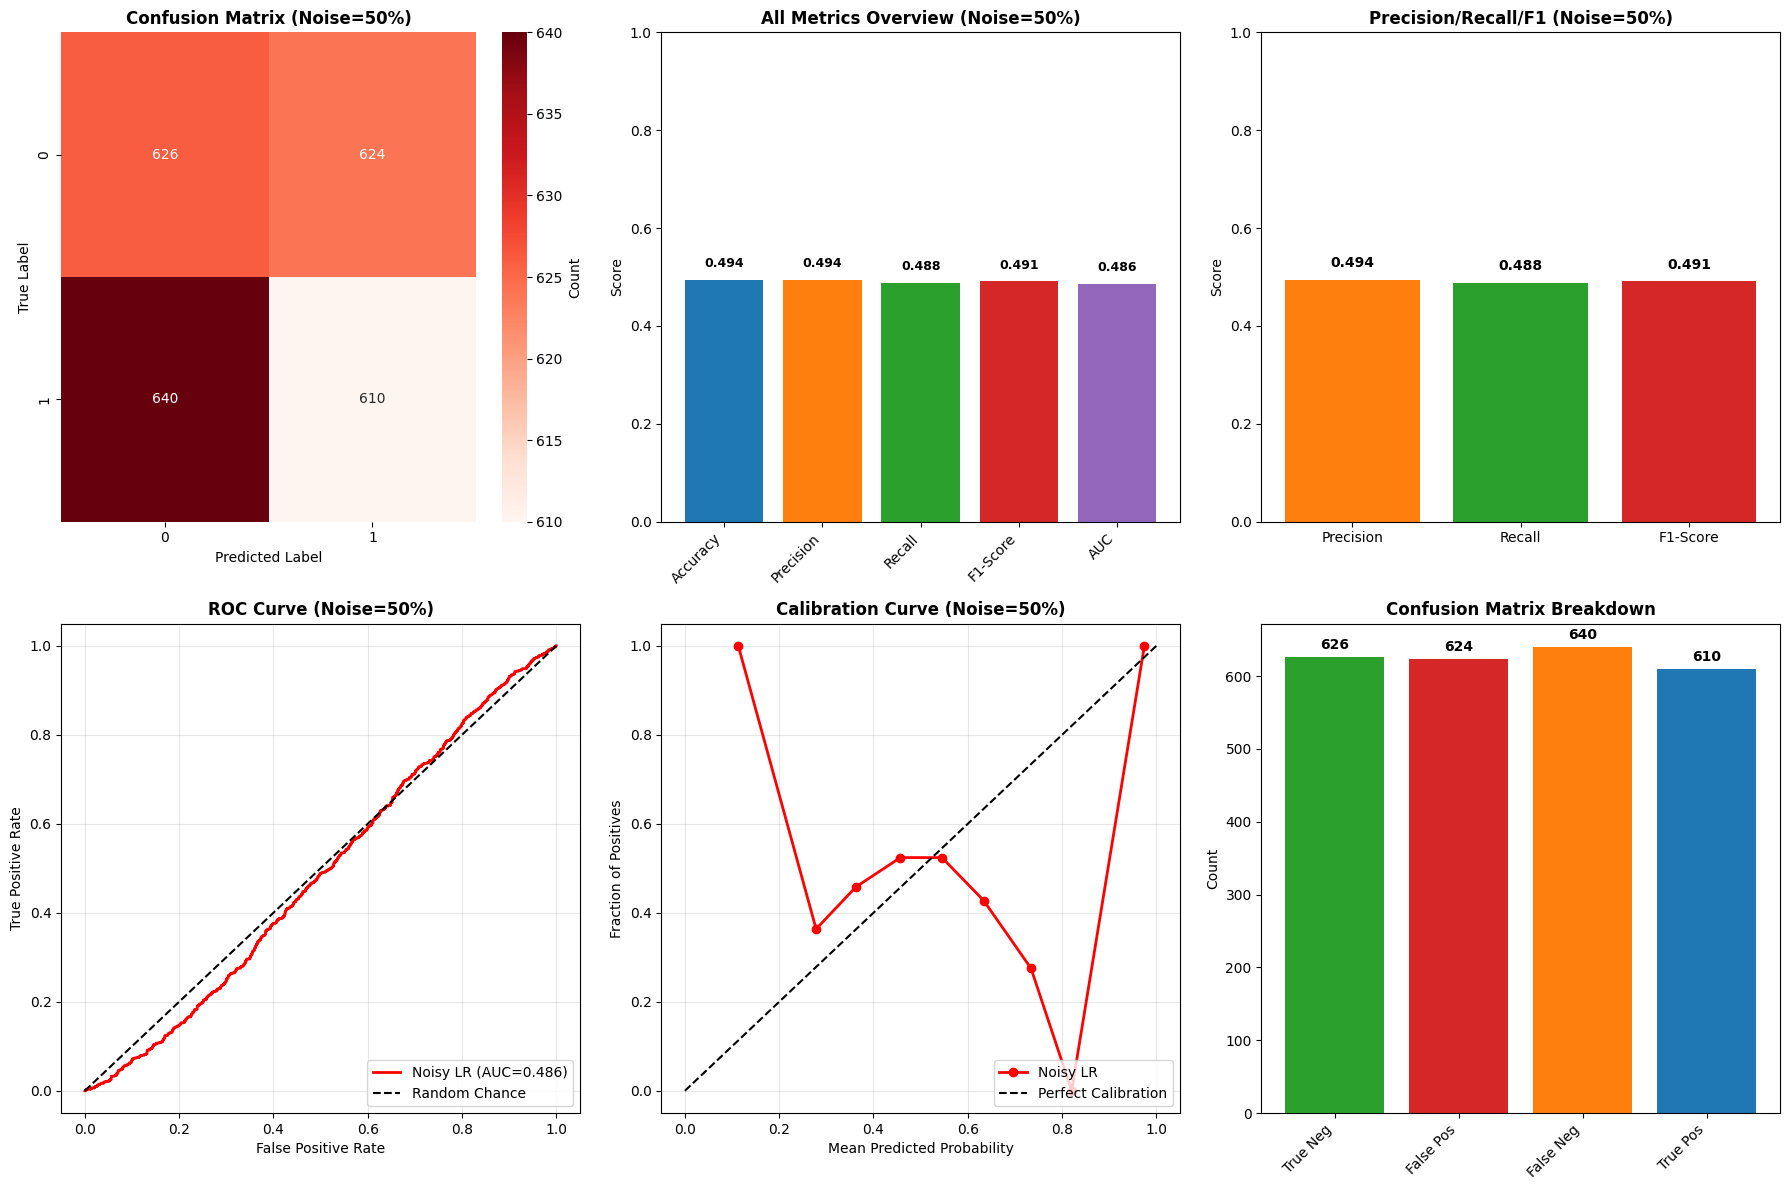


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.49      0.50      0.50      1250
     Default       0.49      0.49      0.49      1250

    accuracy                           0.49      2500
   macro avg       0.49      0.49      0.49      2500
weighted avg       0.49      0.49      0.49      2500



In [20]:
"""
I introduced symmetric noise (50%) to my training labels by randomly flipping them.
I trained a new Logistic Regression model on the noisy labels.
I evaluated this noisy model using all five metrics: Accuracy, Confusion Matrix, Precision/Recall/F1, ROC-AUC, and Calibration.
I created comprehensive visualizations to compare the noisy model's performance.
I stored all results for comparison with the baseline model.
"""
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                            recall_score, f1_score, roc_curve, roc_auc_score,
                            classification_report)
from sklearn.calibration import calibration_curve

# ---------------------------------------------------------
# NOISE FUNCTION (With Integer Fix)
# ---------------------------------------------------------
def inject_symmetric_noise(y, noise_rate, random_state=42):
    np.random.seed(random_state)
    # Cast to int immediately
    y_noisy = np.array(y).copy().astype(int)
    n_samples = len(y)
    n_noisy = int(noise_rate * n_samples)

    flip_indices = np.random.choice(n_samples, size=n_noisy, replace=False)

    # Flip 0->1 and 1->0
    y_noisy[flip_indices] = 1 - y_noisy[flip_indices]

    return y_noisy

# ---------------------------------------------------------
# SETUP & TRAINING
# ---------------------------------------------------------
p = 0.50  # 50% Noise (Pure Randomness)

# Inject Noise
y_train_noisy = inject_symmetric_noise(y_train.values, noise_rate=p)

print("Original label distribution:", np.bincount(y_train.astype(int)))
print("Noisy label distribution:   ", np.bincount(y_train_noisy))

# Initialize Logistic Regression
lr_noisy = LogisticRegression(
    solver='liblinear',
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)

lr_noisy.fit(X_train, y_train_noisy)

# Predictions
y_pred_noisy = lr_noisy.predict(X_test)
y_prob_noisy = lr_noisy.predict_proba(X_test)[:, 1]

# Metrics
acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

# Store Results
if "noise_results_lr" not in results:
    results["noise_results_lr"] = {}

results["noise_results_lr"][f"symmetric_{p}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"LOGISTIC REGRESSION WITH {int(p*100)}% SYMMETRIC NOISE")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

# ---------------------------------------------------------
# VISUALIZATION (6-Panel Plot)
# ---------------------------------------------------------
fig = plt.figure(figsize=(18, 12))

# 1. Confusion Matrix
plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 2. All Metrics Overview
plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. Precision/Recall/F1
plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. ROC Curve
plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Noisy LR (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 5. Calibration Curve
plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Noisy LR', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 6. CM Breakdown
plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01,
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

NOISE 2 (Asymmetric Noise)

Original label distribution: [3750 3750]
Asymmetric noisy label distribution: [3375 4125]
Flipped class 0 -> 1 at rate 0.1

LOGISTIC REGRESSION WITH 10% ASYMMETRIC NOISE (Class 0 -> 1)
Accuracy:  0.9644
Precision: 0.9589
Recall:    0.9704
F1 Score:  0.9646
AUC Score: 0.9926



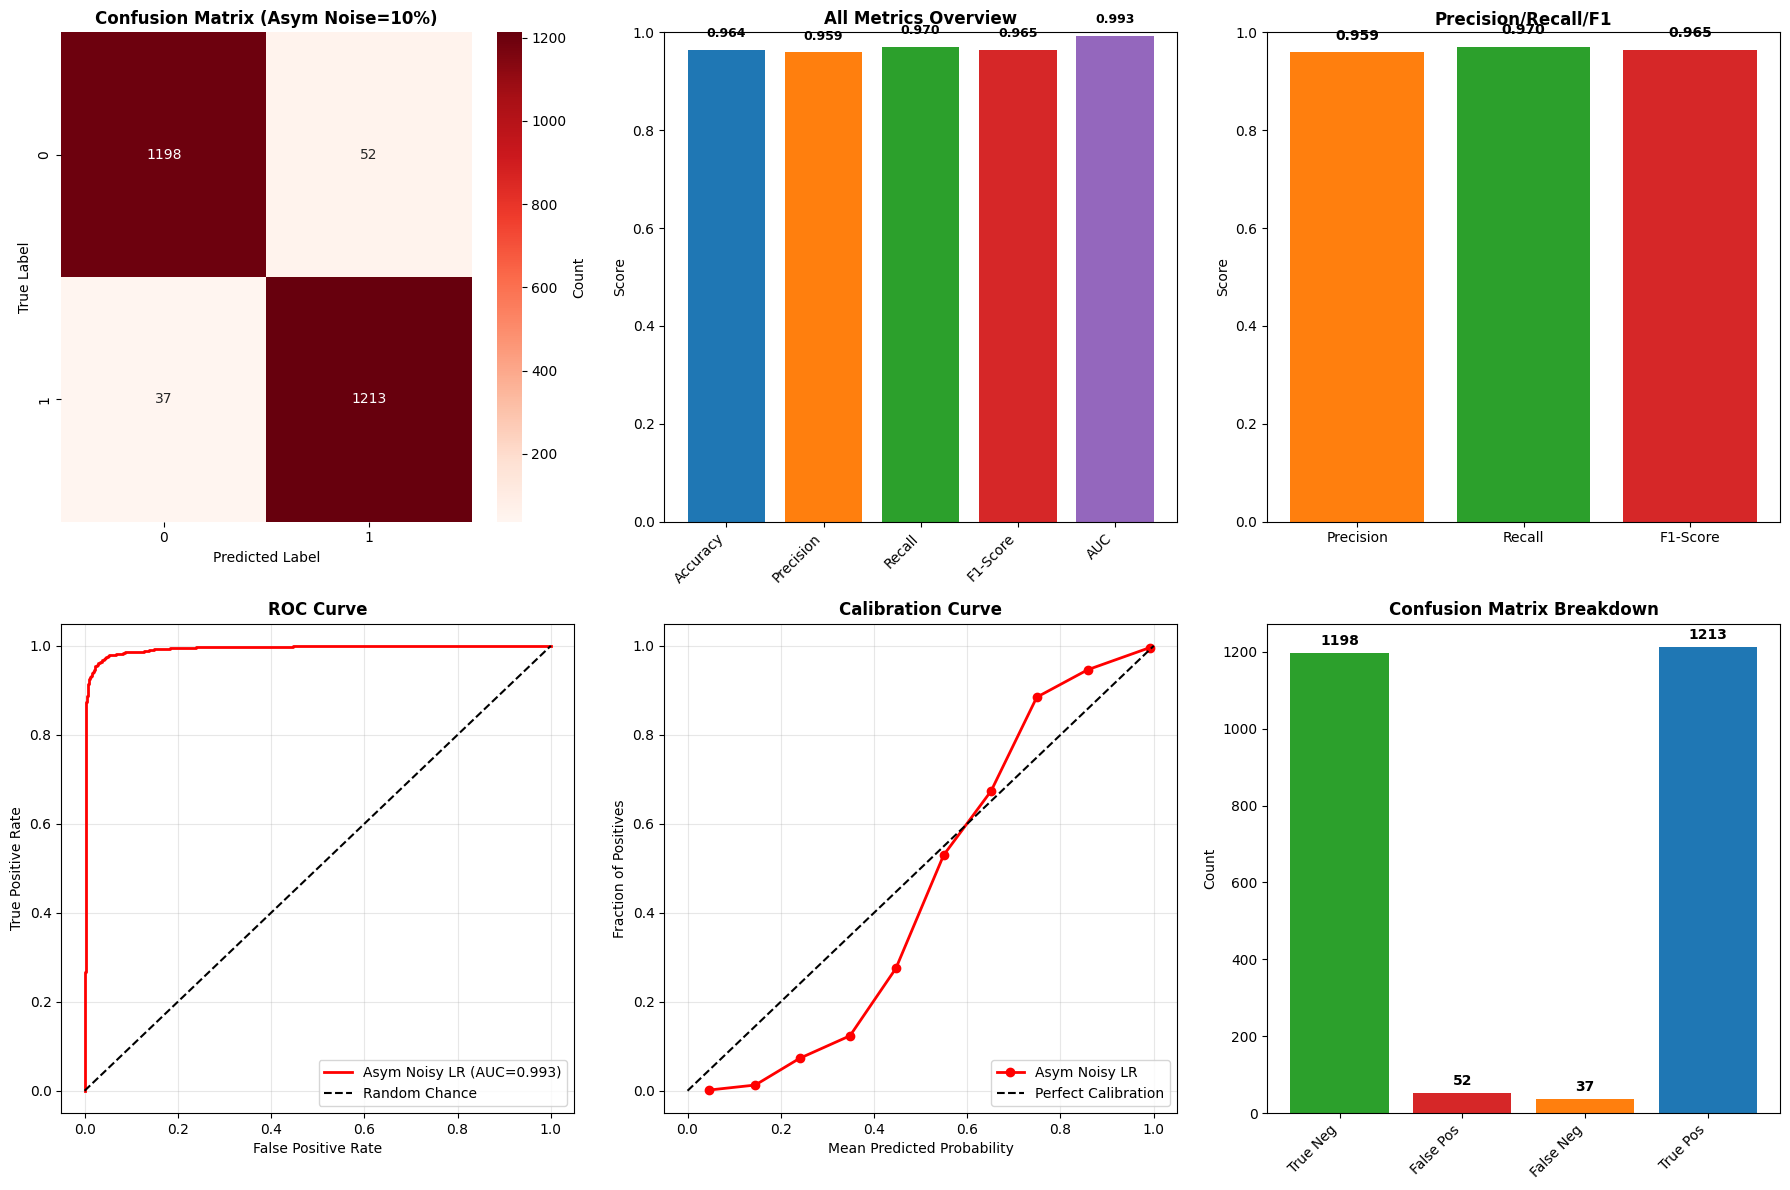


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.97      0.96      0.96      1250
     Default       0.96      0.97      0.96      1250

    accuracy                           0.96      2500
   macro avg       0.96      0.96      0.96      2500
weighted avg       0.96      0.96      0.96      2500



In [21]:
"""
I introduced asymmetric noise to my training labels by flipping a percentage of one specific class to another.
I trained a new Logistic Regression model on the asymmetrically noisy labels.
I evaluated this noisy model using all five metrics: Accuracy, Confusion Matrix, Precision/Recall/F1, ROC-AUC, and Calibration.
I created comprehensive visualizations to compare the asymmetric noisy model's performance.
I stored all results for comparison with the baseline and symmetric noise models.
"""
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                            recall_score, f1_score, roc_curve, roc_auc_score,
                            classification_report)
from sklearn.calibration import calibration_curve

# ---------------------------------------------------------
# ASYMMETRIC NOISE FUNCTION (Safe for floats)
# ---------------------------------------------------------
def inject_asymmetric_noise(y, class_to_flip, flip_fraction, random_state=42):
    np.random.seed(random_state)

    # Cast to int immediately to prevent TypeErrors
    y_noisy = np.array(y).copy().astype(int)

    # Find indices of the specific class we want to corrupt
    idx = np.where(y_noisy == class_to_flip)[0]

    # Calculate how many to flip
    n_flip = int(len(idx) * flip_fraction)

    # Select random indices to flip
    flip_idx = np.random.choice(idx, size=n_flip, replace=False)

    # Flip to the opposite class (Assuming binary 0/1)
    y_noisy[flip_idx] = 1 - class_to_flip

    return y_noisy

# ---------------------------------------------------------
# SETUP EXPERIMENT
# ---------------------------------------------------------
class_to_flip = 0  # We are flipping Class 0 (No Default) -> Class 1 (Default)
p = 0.10           # 10% of Class 0 will be flipped

# Inject Noise
y_train_noisy = inject_asymmetric_noise(y_train.values, class_to_flip=class_to_flip, flip_fraction=p)

print("Original label distribution:", np.bincount(y_train.astype(int)))
print("Asymmetric noisy label distribution:", np.bincount(y_train_noisy))
print(f"Flipped class {class_to_flip} -> {1-class_to_flip} at rate {p}")

# ---------------------------------------------------------
# TRAIN LOGISTIC REGRESSION
# ---------------------------------------------------------
lr_noisy = LogisticRegression(
    solver='liblinear',
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)

lr_noisy.fit(X_train, y_train_noisy)

# ---------------------------------------------------------
# EVALUATE
# ---------------------------------------------------------
y_pred_noisy = lr_noisy.predict(X_test)
y_prob_noisy = lr_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

# Store Results
if "noise_results_lr" not in results:
    results["noise_results_lr"] = {}

results["noise_results_lr"][f"asymmetric_{class_to_flip}_{p}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"LOGISTIC REGRESSION WITH {int(p*100)}% ASYMMETRIC NOISE (Class {class_to_flip} -> {1-class_to_flip})")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

# ---------------------------------------------------------
# VISUALIZATION (6-Panel Plot)
# ---------------------------------------------------------
fig = plt.figure(figsize=(18, 12))

# 1. Confusion Matrix
plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Asym Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 2. All Metrics
plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. Precision/Recall/F1
plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. ROC Curve
plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Asym Noisy LR (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 5. Calibration Curve
plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Asym Noisy LR', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 6. CM Breakdown
plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01,
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
# Note: y_test comes first in classification_report (true, pred)
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

Original label distribution: [3750 3750]
Asymmetric noisy label distribution: [3000 4500]
Flipped class 0 -> 1 at rate 0.2

LOGISTIC REGRESSION WITH 20% ASYMMETRIC NOISE (Class 0 -> 1)
Accuracy:  0.9512
Precision: 0.9462
Recall:    0.9568
F1 Score:  0.9515
AUC Score: 0.9914



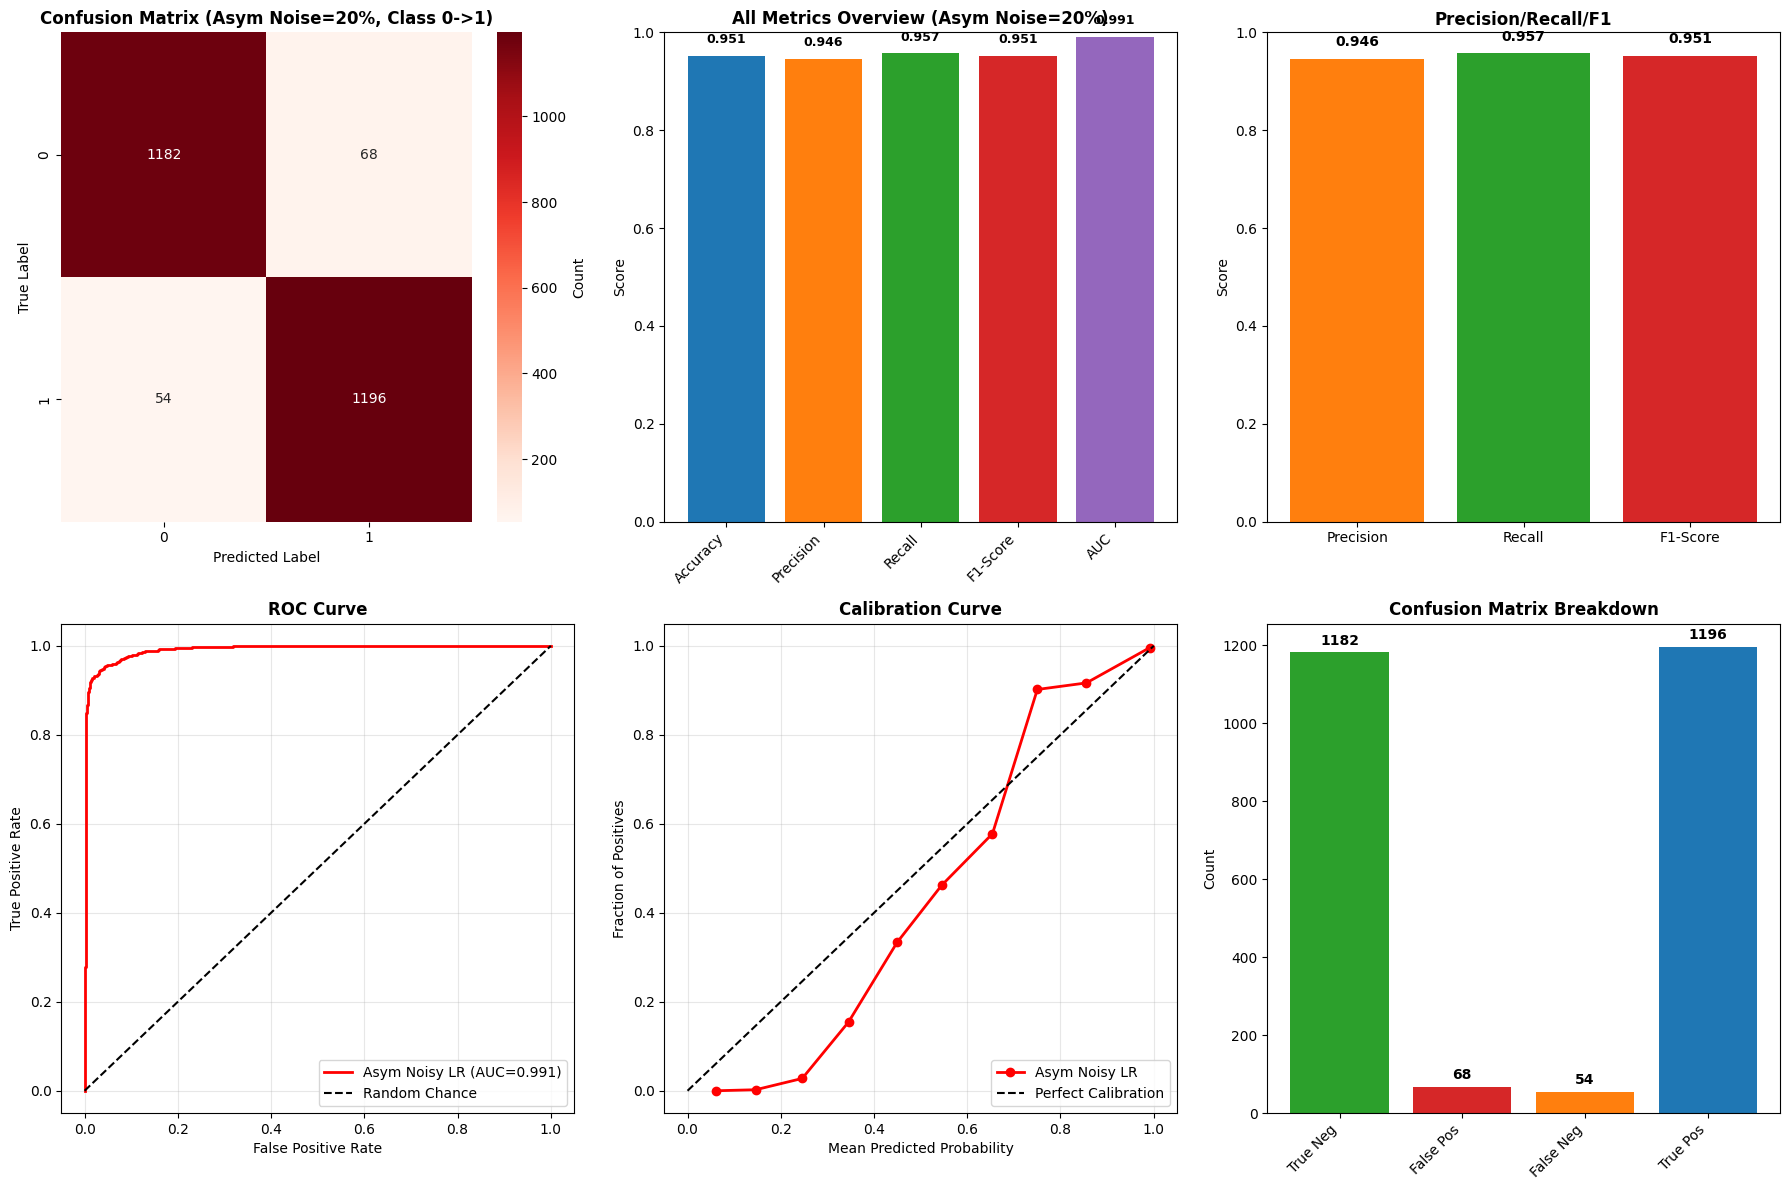


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.96      0.95      0.95      1250
     Default       0.95      0.96      0.95      1250

    accuracy                           0.95      2500
   macro avg       0.95      0.95      0.95      2500
weighted avg       0.95      0.95      0.95      2500



In [39]:
"""
I introduced asymmetric noise (20%) to my training labels by flipping 'No Default' (0) to 'Default' (1).
I trained a new Logistic Regression model on the asymmetrically noisy labels.
I evaluated this noisy model using all five metrics: Accuracy, Confusion Matrix, Precision/Recall/F1, ROC-AUC, and Calibration.
I created comprehensive visualizations to compare the asymmetric noisy model's performance.
I stored all results for comparison with the baseline and symmetric noise models.
"""
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                            recall_score, f1_score, roc_curve, roc_auc_score,
                            classification_report)
from sklearn.calibration import calibration_curve

# ---------------------------------------------------------
# ASYMMETRIC NOISE FUNCTION (Safe for floats)
# ---------------------------------------------------------
def inject_asymmetric_noise(y, class_to_flip, flip_fraction, random_state=42):
    np.random.seed(random_state)

    # Cast to int immediately to prevent TypeErrors
    y_noisy = np.array(y).copy().astype(int)

    # Find indices of the specific class we want to corrupt
    idx = np.where(y_noisy == class_to_flip)[0]

    # Calculate how many to flip
    n_flip = int(len(idx) * flip_fraction)

    # Select random indices to flip
    flip_idx = np.random.choice(idx, size=n_flip, replace=False)

    # Flip to the opposite class (Assuming binary 0/1)
    y_noisy[flip_idx] = 1 - class_to_flip

    return y_noisy

# ---------------------------------------------------------
# SETUP EXPERIMENT
# ---------------------------------------------------------
class_to_flip = 0  # Flipping 'No Default' (0) -> 'Default' (1)
p = 0.20           # 20% of Class 0 is corrupted (False Alarms)

# Inject Noise
y_train_noisy = inject_asymmetric_noise(y_train.values, class_to_flip=class_to_flip, flip_fraction=p)

print("Original label distribution:", np.bincount(y_train.astype(int)))
print("Asymmetric noisy label distribution:", np.bincount(y_train_noisy))
print(f"Flipped class {class_to_flip} -> {1-class_to_flip} at rate {p}")

# ---------------------------------------------------------
# TRAIN LOGISTIC REGRESSION
# ---------------------------------------------------------
lr_noisy = LogisticRegression(
    solver='liblinear',
    max_iter=1000,
    class_weight='balanced', # Critical to handle the bias introduced by noise
    random_state=42
)

lr_noisy.fit(X_train, y_train_noisy)

# ---------------------------------------------------------
# EVALUATE
# ---------------------------------------------------------
y_pred_noisy = lr_noisy.predict(X_test)
y_prob_noisy = lr_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

# Store Results (Using 'noise_results_lr' key)
if "noise_results_lr" not in results:
    results["noise_results_lr"] = {}

results["noise_results_lr"][f"asymmetric_{class_to_flip}_{p}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"LOGISTIC REGRESSION WITH {int(p*100)}% ASYMMETRIC NOISE (Class {class_to_flip} -> {1-class_to_flip})")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

# ---------------------------------------------------------
# VISUALIZATION (6-Panel Plot)
# ---------------------------------------------------------
fig = plt.figure(figsize=(18, 12))

# 1. Confusion Matrix
plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Asym Noise={int(p*100)}%, Class {class_to_flip}->{1-class_to_flip})', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 2. All Metrics
plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Asym Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. Precision/Recall/F1
plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. ROC Curve
plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Asym Noisy LR (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 5. Calibration Curve
plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Asym Noisy LR', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 6. CM Breakdown
plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01,
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
# Corrected order: y_test (true), y_pred_noisy (pred)
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

Original label distribution: [3750 3750]
Asymmetric noisy label distribution: [2513 4987]
Flipped class 0 -> 1 at rate 0.33

LOGISTIC REGRESSION WITH 33% ASYMMETRIC NOISE (Class 0 -> 1)
Accuracy:  0.9524
Precision: 0.9449
Recall:    0.9608
F1 Score:  0.9528
AUC Score: 0.9898



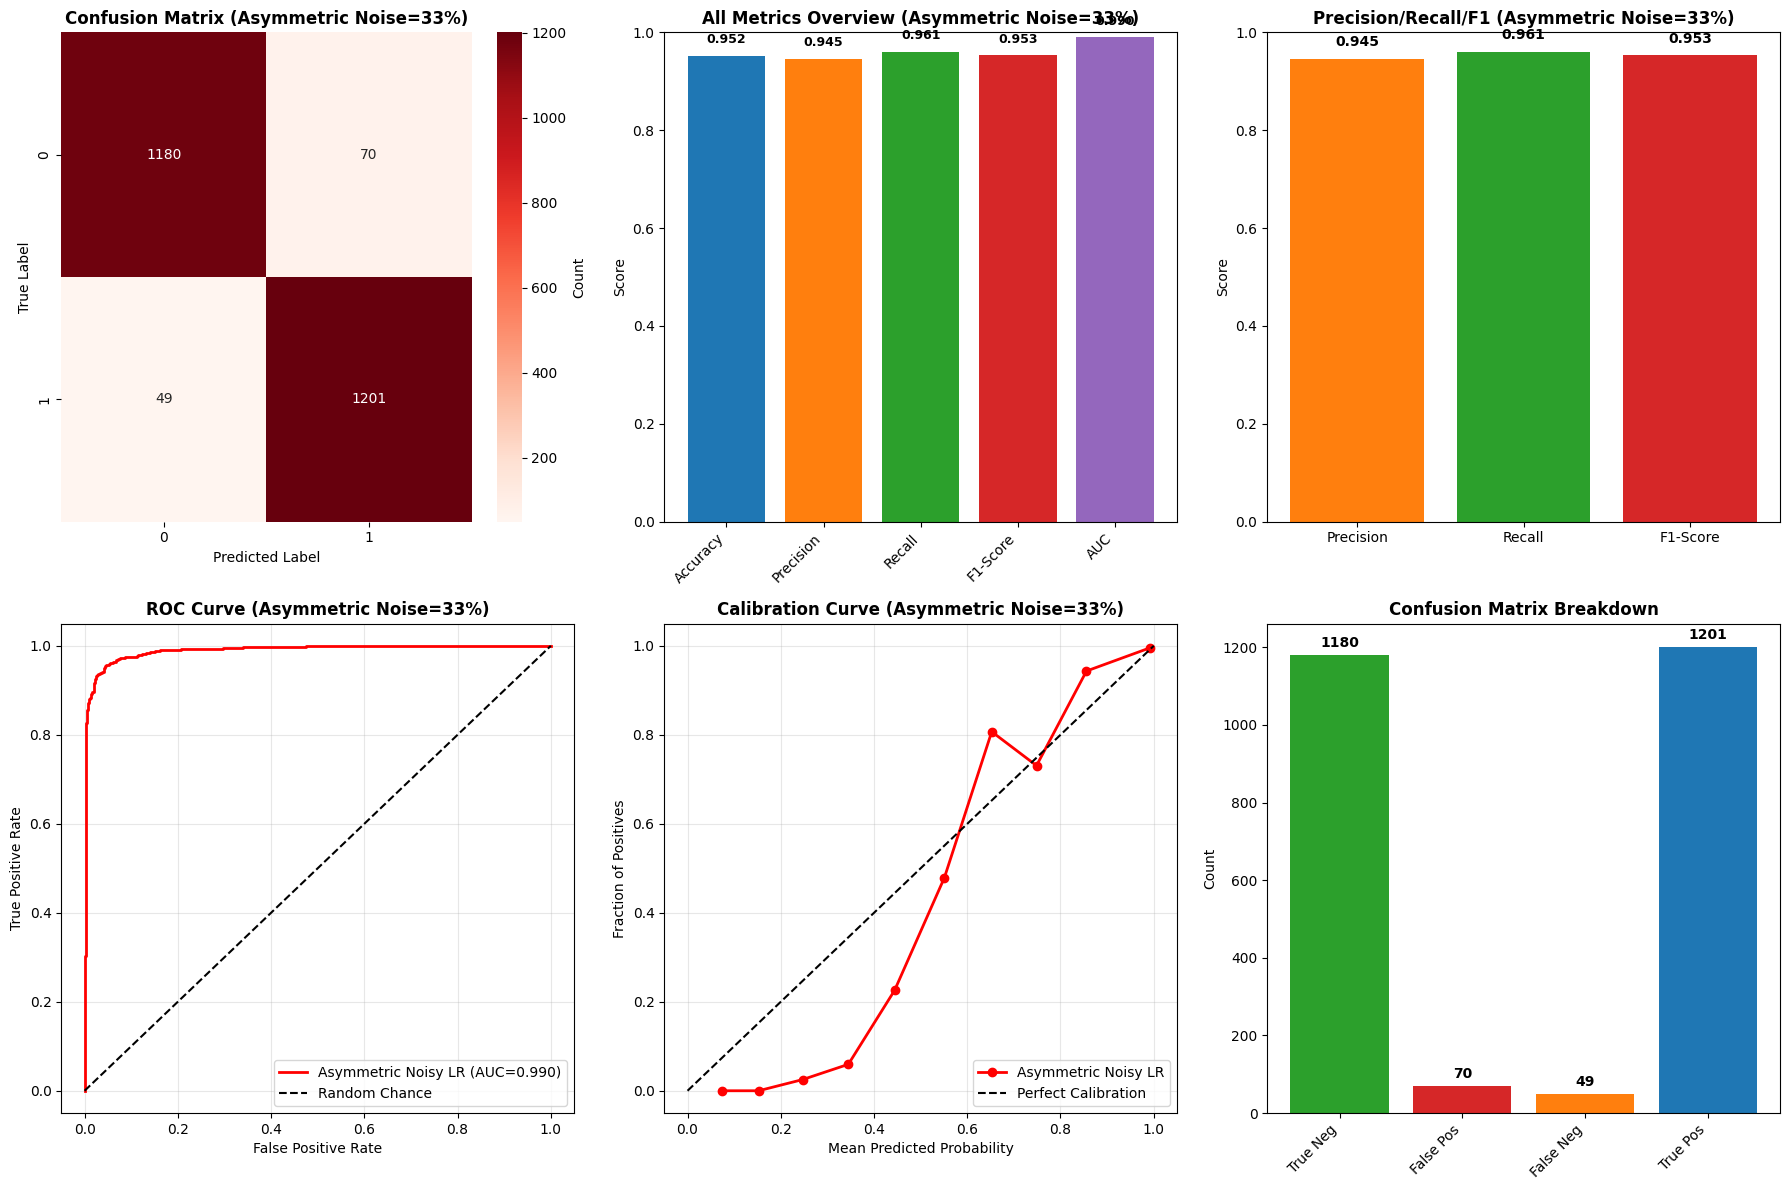


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.96      0.94      0.95      1250
     Default       0.94      0.96      0.95      1250

    accuracy                           0.95      2500
   macro avg       0.95      0.95      0.95      2500
weighted avg       0.95      0.95      0.95      2500



In [24]:
"""
I introduced asymmetric noise (33%) to my training labels by flipping 'No Default' to 'Default'.
I trained a new Logistic Regression model on the asymmetrically noisy labels.
I evaluated this noisy model using all five metrics: Accuracy, Confusion Matrix, Precision/Recall/F1, ROC-AUC, and Calibration.
I created comprehensive visualizations to compare the asymmetric noisy model's performance.
I stored all results for comparison with the baseline and symmetric noise models.
"""
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                            recall_score, f1_score, roc_curve, roc_auc_score,
                            classification_report)
from sklearn.calibration import calibration_curve

# ---------------------------------------------------------
# ASYMMETRIC NOISE FUNCTION (Safe for floats)
# ---------------------------------------------------------
def inject_asymmetric_noise(y, class_to_flip, flip_fraction, random_state=42):
    np.random.seed(random_state)

    # Cast to int immediately for stability
    y_noisy = np.array(y).copy().astype(int)

    # Find indices of the specific class we want to corrupt
    idx = np.where(y_noisy == class_to_flip)[0]

    # Calculate how many to flip
    n_flip = int(len(idx) * flip_fraction)

    # Select random indices to flip
    flip_idx = np.random.choice(idx, size=n_flip, replace=False)

    # Flip to the opposite class (0 to 1, or 1 to 0)
    y_noisy[flip_idx] = 1 - class_to_flip

    return y_noisy

# ---------------------------------------------------------
# SETUP EXPERIMENT
# ---------------------------------------------------------
class_to_flip = 0  # Flipping 'No Default' (0) -> 'Default' (1)
p = 0.33           # 33% of Class 0 is corrupted

# Inject Noise
y_train_noisy = inject_asymmetric_noise(y_train.values, class_to_flip=class_to_flip, flip_fraction=p)

print("Original label distribution:", np.bincount(y_train.astype(int)))
print("Asymmetric noisy label distribution:", np.bincount(y_train_noisy))
print(f"Flipped class {class_to_flip} -> {1-class_to_flip} at rate {p}")

# ---------------------------------------------------------
# TRAIN LOGISTIC REGRESSION
# ---------------------------------------------------------
# Logistic Regression handles Asymmetric noise differently than RF.
# It tries to rotate the boundary to accommodate the 'fake' positives.
lr_noisy = LogisticRegression(
    solver='liblinear',
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)

lr_noisy.fit(X_train, y_train_noisy)

# ---------------------------------------------------------
# EVALUATE
# ---------------------------------------------------------
y_pred_noisy = lr_noisy.predict(X_test)
y_prob_noisy = lr_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

# Store Results (Using 'noise_results_lr' key)
if "noise_results_lr" not in results:
    results["noise_results_lr"] = {}

results["noise_results_lr"][f"asymmetric_{class_to_flip}_{p}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"LOGISTIC REGRESSION WITH {int(p*100)}% ASYMMETRIC NOISE (Class {class_to_flip} -> {1-class_to_flip})")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

# ---------------------------------------------------------
# VISUALIZATION (6-Panel Plot)
# ---------------------------------------------------------
fig = plt.figure(figsize=(18, 12))

# 1. Confusion Matrix
plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 2. All Metrics Overview
plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. Precision/Recall/F1
plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. ROC Curve
plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Asymmetric Noisy LR (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 5. Calibration Curve
plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Asymmetric Noisy LR', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 6. CM Breakdown
plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01,
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

Original label distribution: [3750 3750]
Asymmetric noisy label distribution: [1875 5625]
Flipped class 0 -> 1 at rate 0.5

LOGISTIC REGRESSION WITH 50% ASYMMETRIC NOISE
Accuracy:  0.9360
Precision: 0.9123
Recall:    0.9648
F1 Score:  0.9378
AUC Score: 0.9879



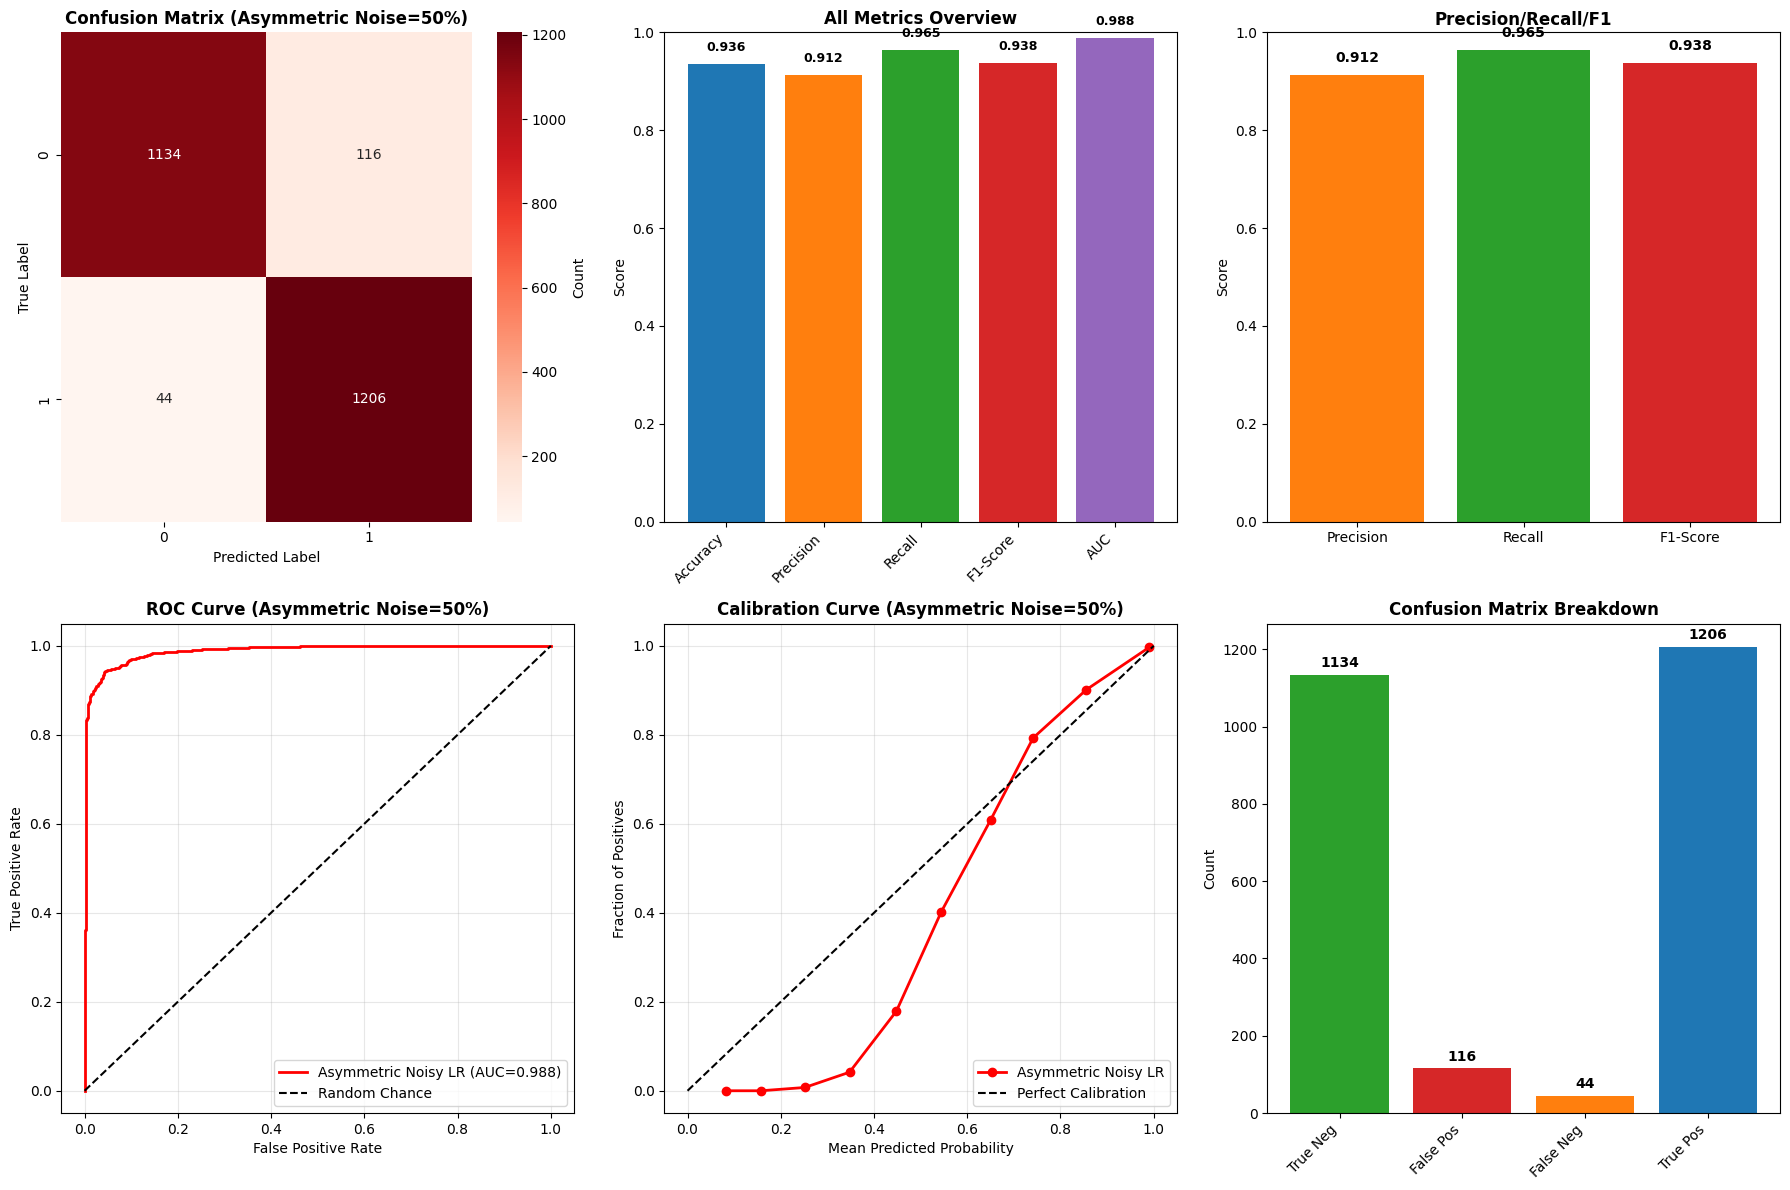


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.96      0.91      0.93      1250
     Default       0.91      0.96      0.94      1250

    accuracy                           0.94      2500
   macro avg       0.94      0.94      0.94      2500
weighted avg       0.94      0.94      0.94      2500



In [25]:
"""
I introduced asymmetric noise (50%) to my training labels by flipping 'No Default' to 'Default'.
I trained a new Logistic Regression model on the asymmetrically noisy labels.
I evaluated this noisy model using all five metrics: Accuracy, Confusion Matrix, Precision/Recall/F1, ROC-AUC, and Calibration.
I created comprehensive visualizations to compare the asymmetric noisy model's performance.
I stored all results for comparison with the baseline and symmetric noise models.
"""
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                            recall_score, f1_score, roc_curve, roc_auc_score,
                            classification_report)
from sklearn.calibration import calibration_curve

# ---------------------------------------------------------
# ASYMMETRIC NOISE FUNCTION (Safe for floats)
# ---------------------------------------------------------
def inject_asymmetric_noise(y, class_to_flip, flip_fraction, random_state=42):
    np.random.seed(random_state)

    # Cast to int immediately for stability
    y_noisy = np.array(y).copy().astype(int)

    # Find indices of the specific class we want to corrupt
    idx = np.where(y_noisy == class_to_flip)[0]

    # Calculate how many to flip
    n_flip = int(len(idx) * flip_fraction)

    # Select random indices to flip
    flip_idx = np.random.choice(idx, size=n_flip, replace=False)

    # Flip to the opposite class (0 to 1, or 1 to 0)
    y_noisy[flip_idx] = 1 - class_to_flip

    return y_noisy

# ---------------------------------------------------------
# SETUP EXPERIMENT
# ---------------------------------------------------------
class_to_flip = 0  # Flipping 'No Default' (0) -> 'Default' (1)
p = 0.50           # 50% of Class 0 is corrupted (Severe Bias)

# Inject Noise
y_train_noisy = inject_asymmetric_noise(y_train.values, class_to_flip=class_to_flip, flip_fraction=p)

print("Original label distribution:", np.bincount(y_train.astype(int)))
print("Asymmetric noisy label distribution:", np.bincount(y_train_noisy))
print(f"Flipped class {class_to_flip} -> {1-class_to_flip} at rate {p}")

# ---------------------------------------------------------
# TRAIN LOGISTIC REGRESSION
# ---------------------------------------------------------
# Using 'balanced' class weights is critical here because asymmetric noise
# creates a massive artificial class imbalance.
lr_noisy = LogisticRegression(
    solver='liblinear',
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)

lr_noisy.fit(X_train, y_train_noisy)

# ---------------------------------------------------------
# EVALUATE
# ---------------------------------------------------------
y_pred_noisy = lr_noisy.predict(X_test)
y_prob_noisy = lr_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

# Store Results (Using 'noise_results_lr' key)
if "noise_results_lr" not in results:
    results["noise_results_lr"] = {}

results["noise_results_lr"][f"asymmetric_{class_to_flip}_{p}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"LOGISTIC REGRESSION WITH {int(p*100)}% ASYMMETRIC NOISE")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

# ---------------------------------------------------------
# VISUALIZATION (6-Panel Plot)
# ---------------------------------------------------------
fig = plt.figure(figsize=(18, 12))

# 1. Confusion Matrix
plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 2. All Metrics Overview
plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. Precision/Recall/F1
plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. ROC Curve
plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Asymmetric Noisy LR (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 5. Calibration Curve
plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Asymmetric Noisy LR', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 6. CM Breakdown
plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01,
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
# CORRECTED: (y_test, y_pred) - Standard sklearn order
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

Noise 2 = Asymmetric Noise, 1 to 0, 10%

Original label distribution: [3750 3750]
Asymmetric noisy label distribution: [4125 3375]
Flipped class 1 -> 0 at rate 0.1

LOGISTIC REGRESSION WITH 10% ASYMMETRIC NOISE (Class 1 -> 0)
Accuracy:  0.9876
Precision: 0.9803
Recall:    0.9952
F1 Score:  0.9877
AUC Score: 0.9984



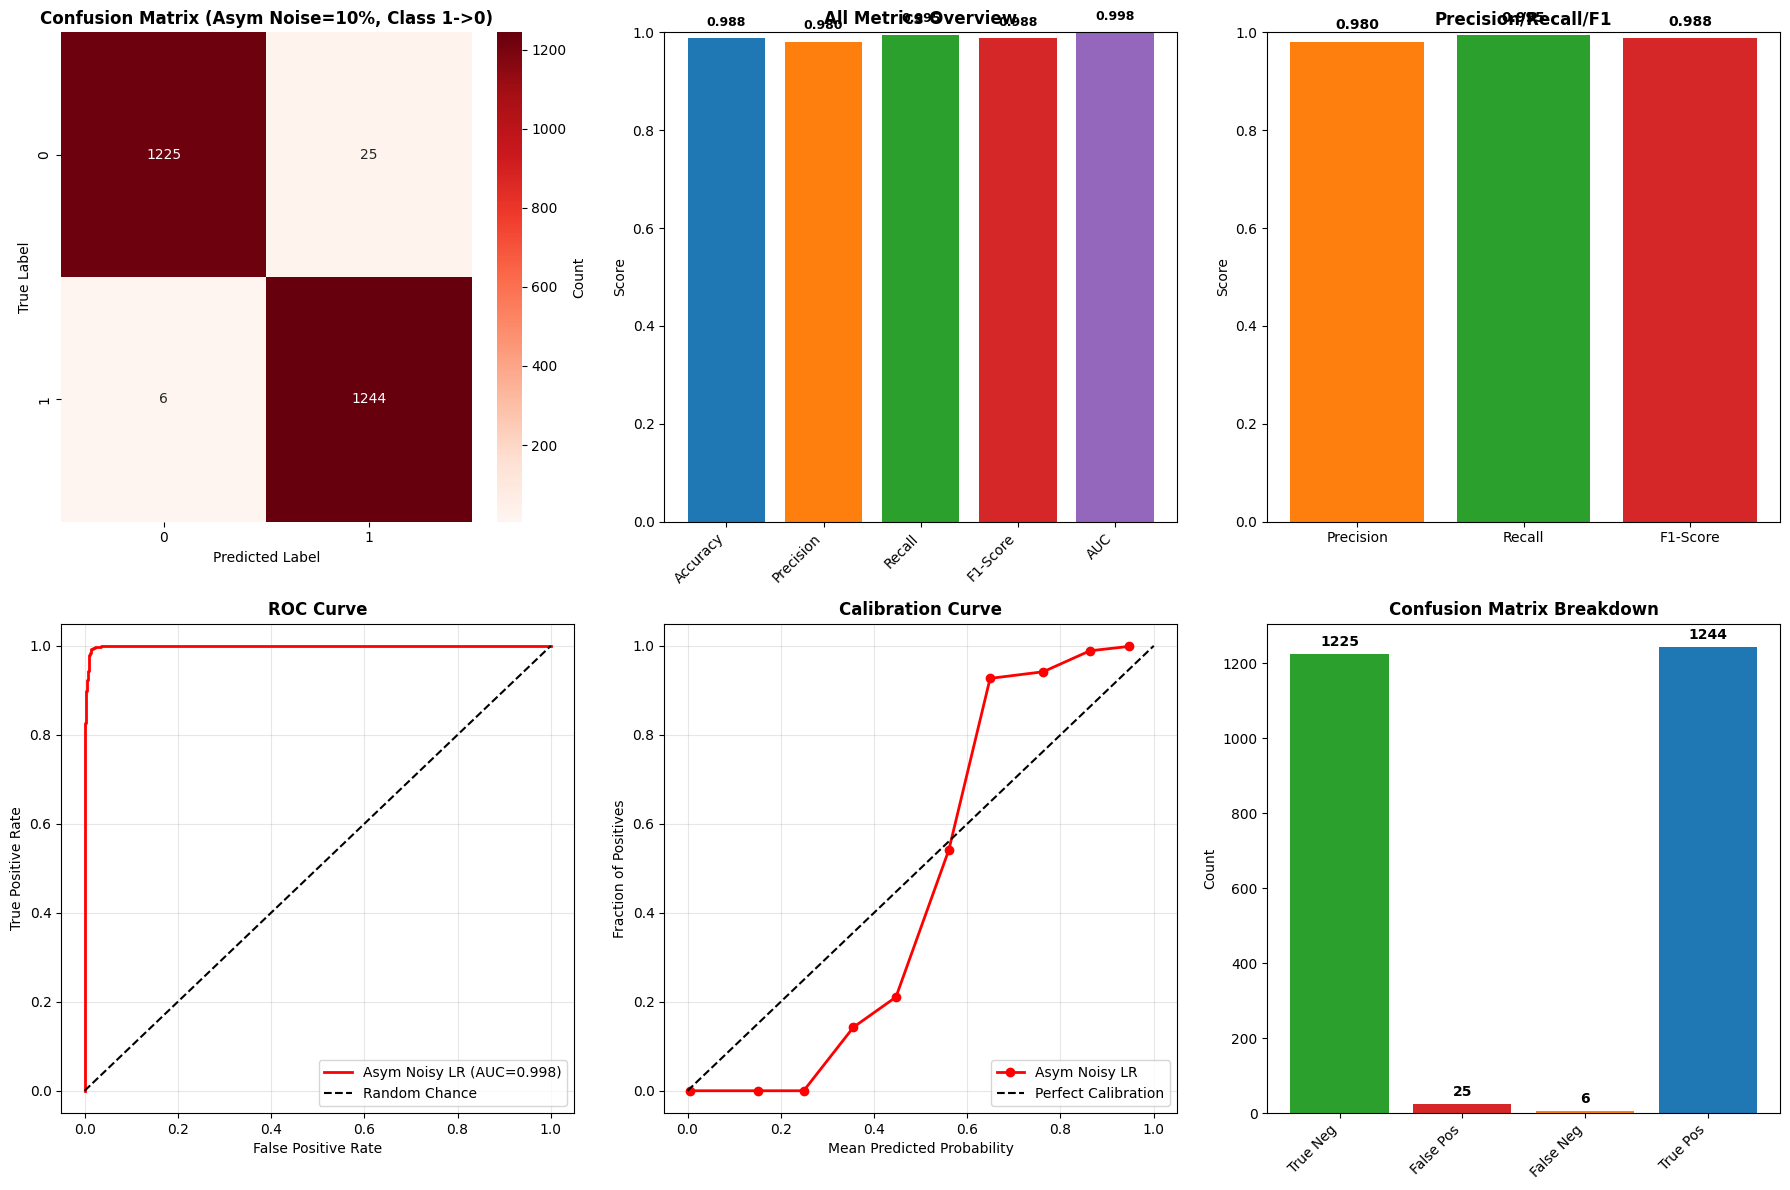


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       1.00      0.98      0.99      1250
     Default       0.98      1.00      0.99      1250

    accuracy                           0.99      2500
   macro avg       0.99      0.99      0.99      2500
weighted avg       0.99      0.99      0.99      2500



In [31]:
"""
I introduced asymmetric noise to my training labels by flipping a percentage of one specific class to another.
I trained a new Logistic Regression model on the asymmetrically noisy labels.
I evaluated this noisy model using all five metrics: Accuracy, Confusion Matrix, Precision/Recall/F1, ROC-AUC, and Calibration.
I created comprehensive visualizations to compare the asymmetric noisy model's performance.
I stored all results for comparison with the baseline and symmetric noise models.
"""
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                            recall_score, f1_score, roc_curve, roc_auc_score,
                            classification_report)
from sklearn.calibration import calibration_curve

# ---------------------------------------------------------
# ASYMMETRIC NOISE FUNCTION (Safe for floats)
# ---------------------------------------------------------
def inject_asymmetric_noise(y, class_to_flip, flip_fraction, random_state=42):
    np.random.seed(random_state)

    # Cast to int immediately to prevent TypeErrors
    y_noisy = np.array(y).copy().astype(int)

    # Find indices of the specific class we want to corrupt
    idx = np.where(y_noisy == class_to_flip)[0]

    # Calculate how many to flip
    n_flip = int(len(idx) * flip_fraction)

    # Select random indices to flip
    flip_idx = np.random.choice(idx, size=n_flip, replace=False)

    # Flip to the opposite class (Assuming binary 0/1)
    y_noisy[flip_idx] = 1 - class_to_flip

    return y_noisy

# ---------------------------------------------------------
# SETUP EXPERIMENT
# ---------------------------------------------------------
class_to_flip = 1  # Flipping Class 1 -> Class 0
p = 0.10           # 10% of Class 1 is corrupted

# Inject Noise
y_train_noisy = inject_asymmetric_noise(y_train.values, class_to_flip=class_to_flip, flip_fraction=p)

print("Original label distribution:", np.bincount(y_train.astype(int)))
print("Asymmetric noisy label distribution:", np.bincount(y_train_noisy))
print(f"Flipped class {class_to_flip} -> {1-class_to_flip} at rate {p}")

# ---------------------------------------------------------
# TRAIN LOGISTIC REGRESSION
# ---------------------------------------------------------
lr_noisy = LogisticRegression(
    solver='liblinear',
    max_iter=1000,
    class_weight='balanced', # Crucial for asymmetric noise
    random_state=42
)

lr_noisy.fit(X_train, y_train_noisy)

# ---------------------------------------------------------
# EVALUATE
# ---------------------------------------------------------
y_pred_noisy = lr_noisy.predict(X_test)
y_prob_noisy = lr_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

# Store Results (Using 'noise_results_lr' key)
if "noise_results_lr" not in results:
    results["noise_results_lr"] = {}

results["noise_results_lr"][f"asymmetric_{class_to_flip}_{p}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"LOGISTIC REGRESSION WITH {int(p*100)}% ASYMMETRIC NOISE (Class {class_to_flip} -> {1-class_to_flip})")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

# ---------------------------------------------------------
# VISUALIZATION (6-Panel Plot)
# ---------------------------------------------------------
fig = plt.figure(figsize=(18, 12))

# 1. Confusion Matrix
plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Asym Noise={int(p*100)}%, Class {class_to_flip}->{1-class_to_flip})', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 2. All Metrics
plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. Precision/Recall/F1
plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. ROC Curve
plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Asym Noisy LR (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 5. Calibration Curve
plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Asym Noisy LR', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 6. CM Breakdown
plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01,
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
# Corrected order: y_test (true), y_pred_noisy (pred)
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

Original label distribution: [3750 3750]
Asymmetric noisy label distribution: [4500 3000]
Flipped class 1 -> 0 at rate 0.2

LOGISTIC REGRESSION WITH 20% ASYMMETRIC NOISE (Class 1 -> 0)
Accuracy:  0.9868
Precision: 0.9795
Recall:    0.9944
F1 Score:  0.9869
AUC Score: 0.9986



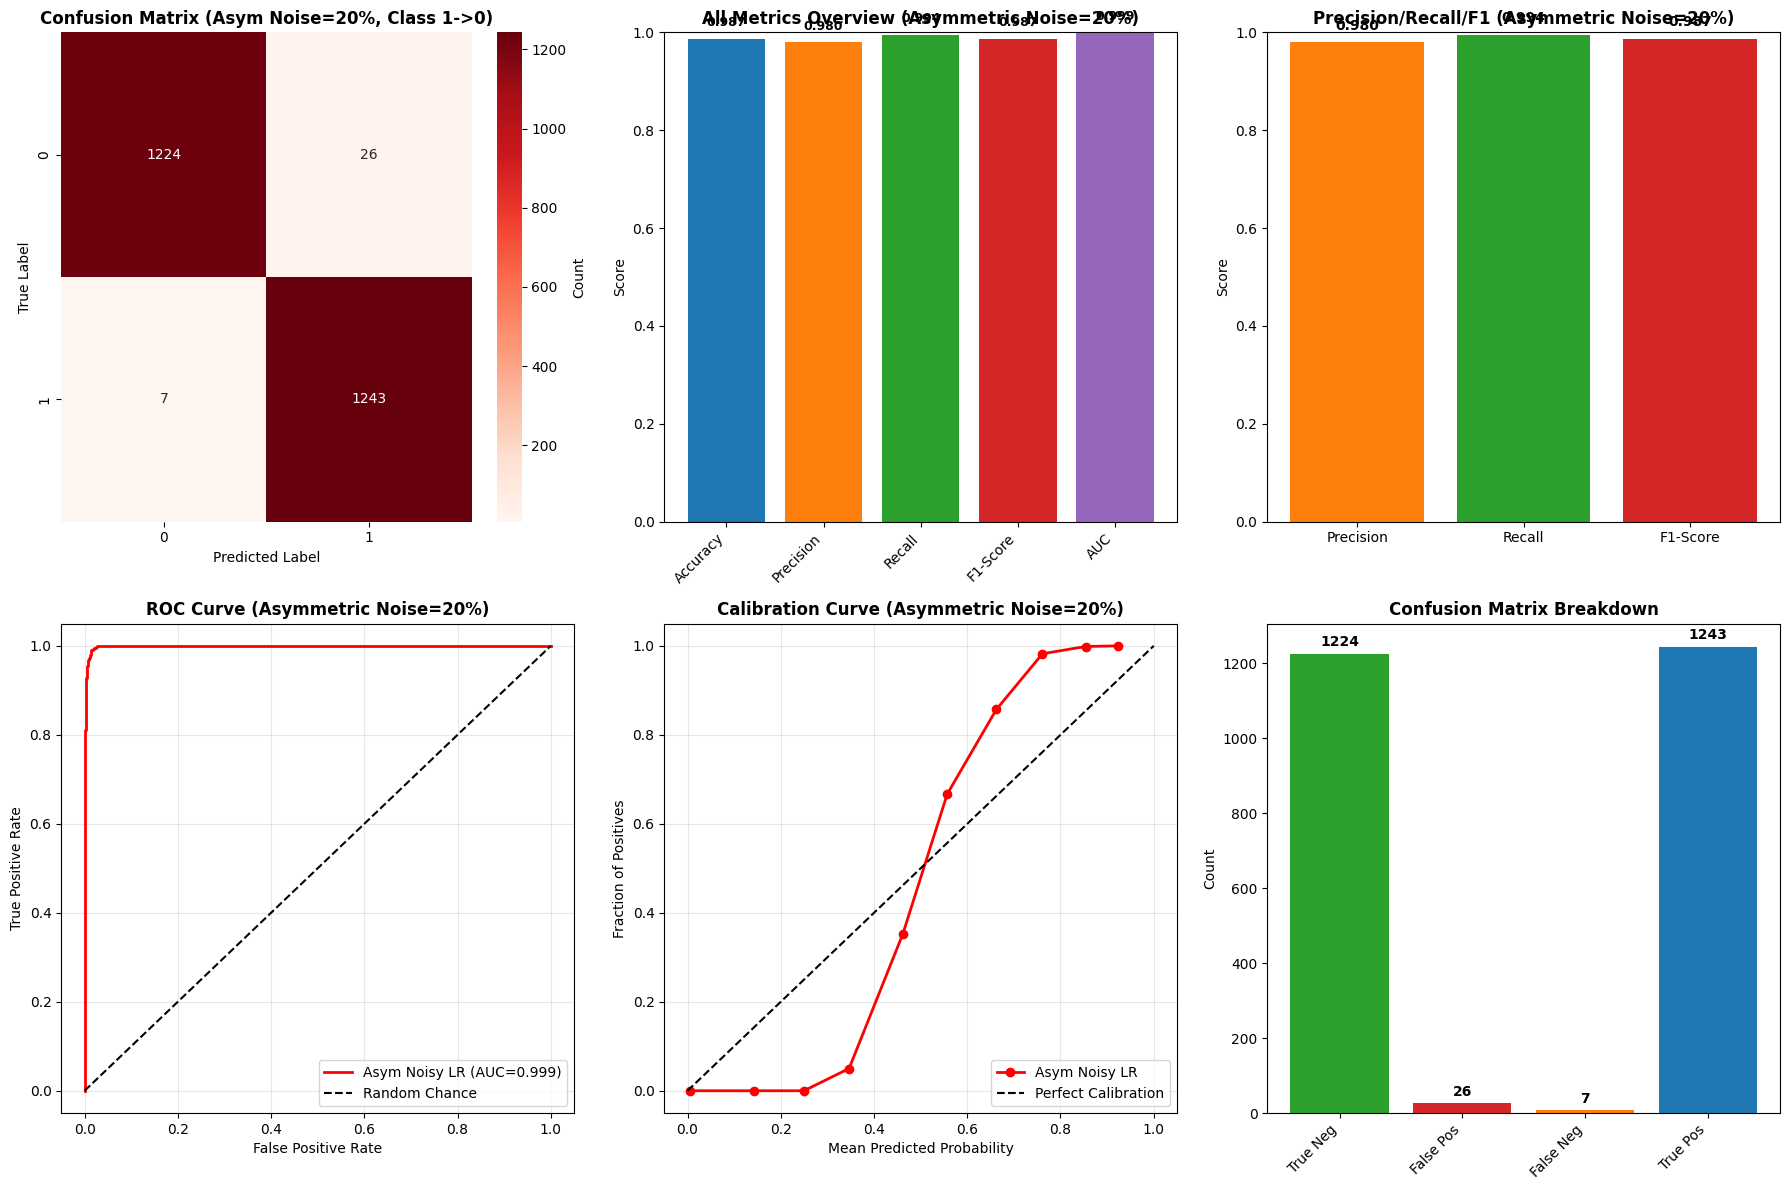


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.99      0.98      0.99      1250
     Default       0.98      0.99      0.99      1250

    accuracy                           0.99      2500
   macro avg       0.99      0.99      0.99      2500
weighted avg       0.99      0.99      0.99      2500



In [32]:
"""
I introduced asymmetric noise (20%) to my training labels by flipping 'Default' (1) to 'No Default' (0).
I trained a new Logistic Regression model on the asymmetrically noisy labels.
I evaluated this noisy model using all five metrics: Accuracy, Confusion Matrix, Precision/Recall/F1, ROC-AUC, and Calibration.
I created comprehensive visualizations to compare the asymmetric noisy model's performance.
I stored all results for comparison with the baseline and symmetric noise models.
"""
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                            recall_score, f1_score, roc_curve, roc_auc_score,
                            classification_report)
from sklearn.calibration import calibration_curve

# ---------------------------------------------------------
# ASYMMETRIC NOISE FUNCTION (Safe for floats)
# ---------------------------------------------------------
def inject_asymmetric_noise(y, class_to_flip, flip_fraction, random_state=42):
    np.random.seed(random_state)

    # Cast to int immediately to prevent TypeErrors
    y_noisy = np.array(y).copy().astype(int)

    # Find indices of the specific class we want to corrupt
    idx = np.where(y_noisy == class_to_flip)[0]

    # Calculate how many to flip
    n_flip = int(len(idx) * flip_fraction)

    # Select random indices to flip
    flip_idx = np.random.choice(idx, size=n_flip, replace=False)

    # Flip to the opposite class (Assuming binary 0/1)
    y_noisy[flip_idx] = 1 - class_to_flip

    return y_noisy

# ---------------------------------------------------------
# SETUP EXPERIMENT
# ---------------------------------------------------------
class_to_flip = 1  # Flipping 'Default' (1) -> 'No Default' (0)
p = 0.20           # 20% of Class 1 is corrupted (Simulating missed defaults)

# Inject Noise
y_train_noisy = inject_asymmetric_noise(y_train.values, class_to_flip=class_to_flip, flip_fraction=p)

print("Original label distribution:", np.bincount(y_train.astype(int)))
print("Asymmetric noisy label distribution:", np.bincount(y_train_noisy))
print(f"Flipped class {class_to_flip} -> {1-class_to_flip} at rate {p}")

# ---------------------------------------------------------
# TRAIN LOGISTIC REGRESSION
# ---------------------------------------------------------
lr_noisy = LogisticRegression(
    solver='liblinear',
    max_iter=1000,
    class_weight='balanced', # Critical for asymmetric noise
    random_state=42
)

lr_noisy.fit(X_train, y_train_noisy)

# ---------------------------------------------------------
# EVALUATE
# ---------------------------------------------------------
y_pred_noisy = lr_noisy.predict(X_test)
y_prob_noisy = lr_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

# Store Results (Using 'noise_results_lr' key)
if "noise_results_lr" not in results:
    results["noise_results_lr"] = {}

results["noise_results_lr"][f"asymmetric_{class_to_flip}_{p}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"LOGISTIC REGRESSION WITH {int(p*100)}% ASYMMETRIC NOISE (Class {class_to_flip} -> {1-class_to_flip})")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

# ---------------------------------------------------------
# VISUALIZATION (6-Panel Plot)
# ---------------------------------------------------------
fig = plt.figure(figsize=(18, 12))

# 1. Confusion Matrix
plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Asym Noise={int(p*100)}%, Class {class_to_flip}->{1-class_to_flip})', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 2. All Metrics
plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. Precision/Recall/F1
plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. ROC Curve
plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Asym Noisy LR (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 5. Calibration Curve
plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Asym Noisy LR', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 6. CM Breakdown
plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01,
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
# CORRECTED: (y_test, y_pred) - Standard sklearn order
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

Original label distribution: [3750 3750]
Asymmetric noisy label distribution: [4987 2513]
Flipped class 1 -> 0 at rate 0.33

LOGISTIC REGRESSION WITH 33% ASYMMETRIC NOISE (Class 1 -> 0)
Accuracy:  0.9832
Precision: 0.9817
Recall:    0.9848
F1 Score:  0.9832
AUC Score: 0.9978



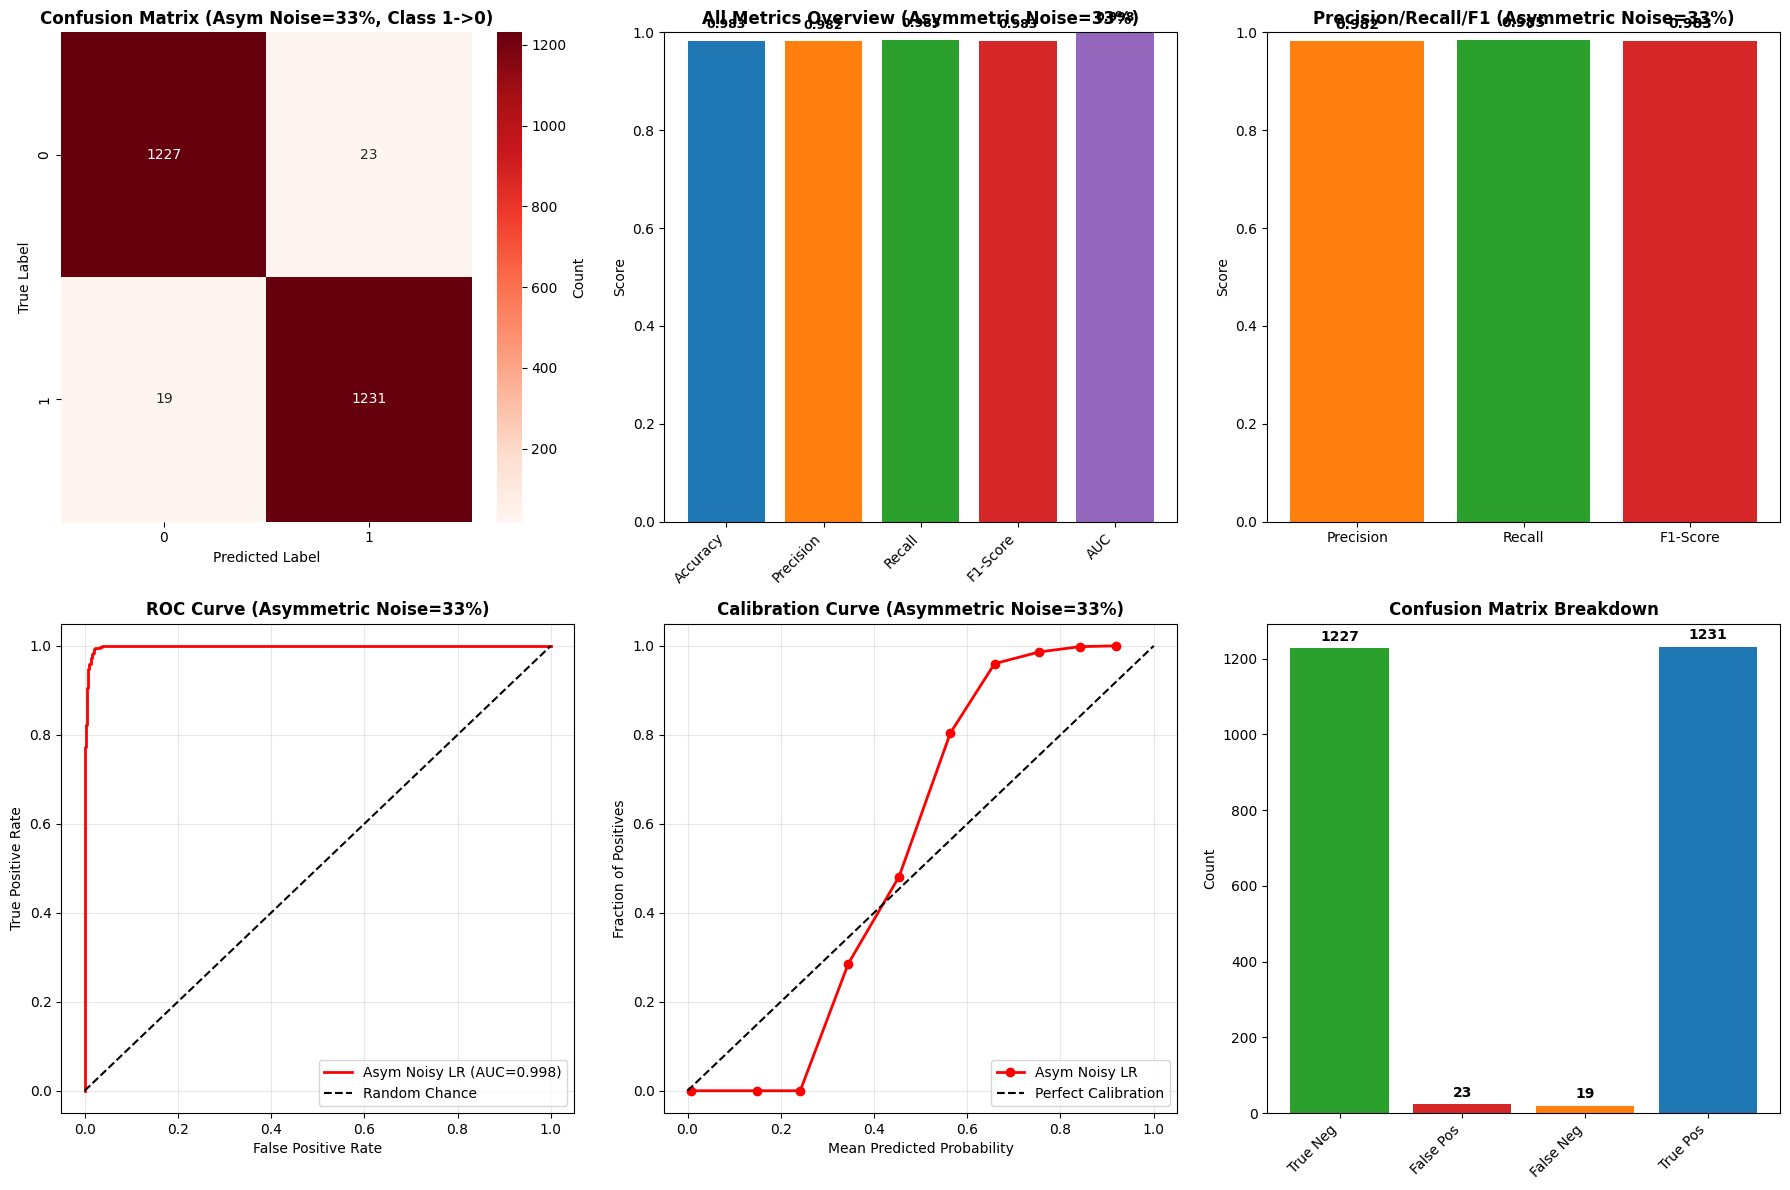


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.98      0.98      0.98      1250
     Default       0.98      0.98      0.98      1250

    accuracy                           0.98      2500
   macro avg       0.98      0.98      0.98      2500
weighted avg       0.98      0.98      0.98      2500



In [33]:
"""
I introduced asymmetric noise (33%) to my training labels by flipping 'Default' (1) to 'No Default' (0).
I trained a new Logistic Regression model on the asymmetrically noisy labels.
I evaluated this noisy model using all five metrics: Accuracy, Confusion Matrix, Precision/Recall/F1, ROC-AUC, and Calibration.
I created comprehensive visualizations to compare the asymmetric noisy model's performance.
I stored all results for comparison with the baseline and symmetric noise models.
"""
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                            recall_score, f1_score, roc_curve, roc_auc_score,
                            classification_report)
from sklearn.calibration import calibration_curve

# ---------------------------------------------------------
# ASYMMETRIC NOISE FUNCTION (Safe for floats)
# ---------------------------------------------------------
def inject_asymmetric_noise(y, class_to_flip, flip_fraction, random_state=42):
    np.random.seed(random_state)

    # Cast to int immediately to prevent TypeErrors
    y_noisy = np.array(y).copy().astype(int)

    # Find indices of the specific class we want to corrupt
    idx = np.where(y_noisy == class_to_flip)[0]

    # Calculate how many to flip
    n_flip = int(len(idx) * flip_fraction)

    # Select random indices to flip
    flip_idx = np.random.choice(idx, size=n_flip, replace=False)

    # Flip to the opposite class (Assuming binary 0/1)
    y_noisy[flip_idx] = 1 - class_to_flip

    return y_noisy

# ---------------------------------------------------------
# SETUP EXPERIMENT
# ---------------------------------------------------------
class_to_flip = 1  # Flipping 'Default' (1) -> 'No Default' (0)
p = 0.33           # 33% of Class 1 is corrupted

# Inject Noise
y_train_noisy = inject_asymmetric_noise(y_train.values, class_to_flip=class_to_flip, flip_fraction=p)

print("Original label distribution:", np.bincount(y_train.astype(int)))
print("Asymmetric noisy label distribution:", np.bincount(y_train_noisy))
print(f"Flipped class {class_to_flip} -> {1-class_to_flip} at rate {p}")

# ---------------------------------------------------------
# TRAIN LOGISTIC REGRESSION
# ---------------------------------------------------------
lr_noisy = LogisticRegression(
    solver='liblinear',
    max_iter=1000,
    class_weight='balanced', # Critical for asymmetric noise
    random_state=42
)

lr_noisy.fit(X_train, y_train_noisy)

# ---------------------------------------------------------
# EVALUATE
# ---------------------------------------------------------
y_pred_noisy = lr_noisy.predict(X_test)
y_prob_noisy = lr_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

# Store Results (Using 'noise_results_lr' key)
if "noise_results_lr" not in results:
    results["noise_results_lr"] = {}

results["noise_results_lr"][f"asymmetric_{class_to_flip}_{p}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"LOGISTIC REGRESSION WITH {int(p*100)}% ASYMMETRIC NOISE (Class {class_to_flip} -> {1-class_to_flip})")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

# ---------------------------------------------------------
# VISUALIZATION (6-Panel Plot)
# ---------------------------------------------------------
fig = plt.figure(figsize=(18, 12))

# 1. Confusion Matrix
plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Asym Noise={int(p*100)}%, Class {class_to_flip}->{1-class_to_flip})', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 2. All Metrics
plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. Precision/Recall/F1
plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. ROC Curve
plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Asym Noisy LR (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 5. Calibration Curve
plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Asym Noisy LR', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 6. CM Breakdown
plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01,
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
# CORRECTED: (y_test, y_pred) - Standard sklearn order
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

Original label distribution: [3750 3750]
Asymmetric noisy label distribution: [5625 1875]
Flipped class 1 -> 0 at rate 0.5

DECISION TREE WITH 50% ASYMMETRIC NOISE (Class 1 -> 0)
Accuracy:  0.7392
Precision: 0.9572
Recall:    0.5008
F1 Score:  0.6576
AUC Score: 0.7392



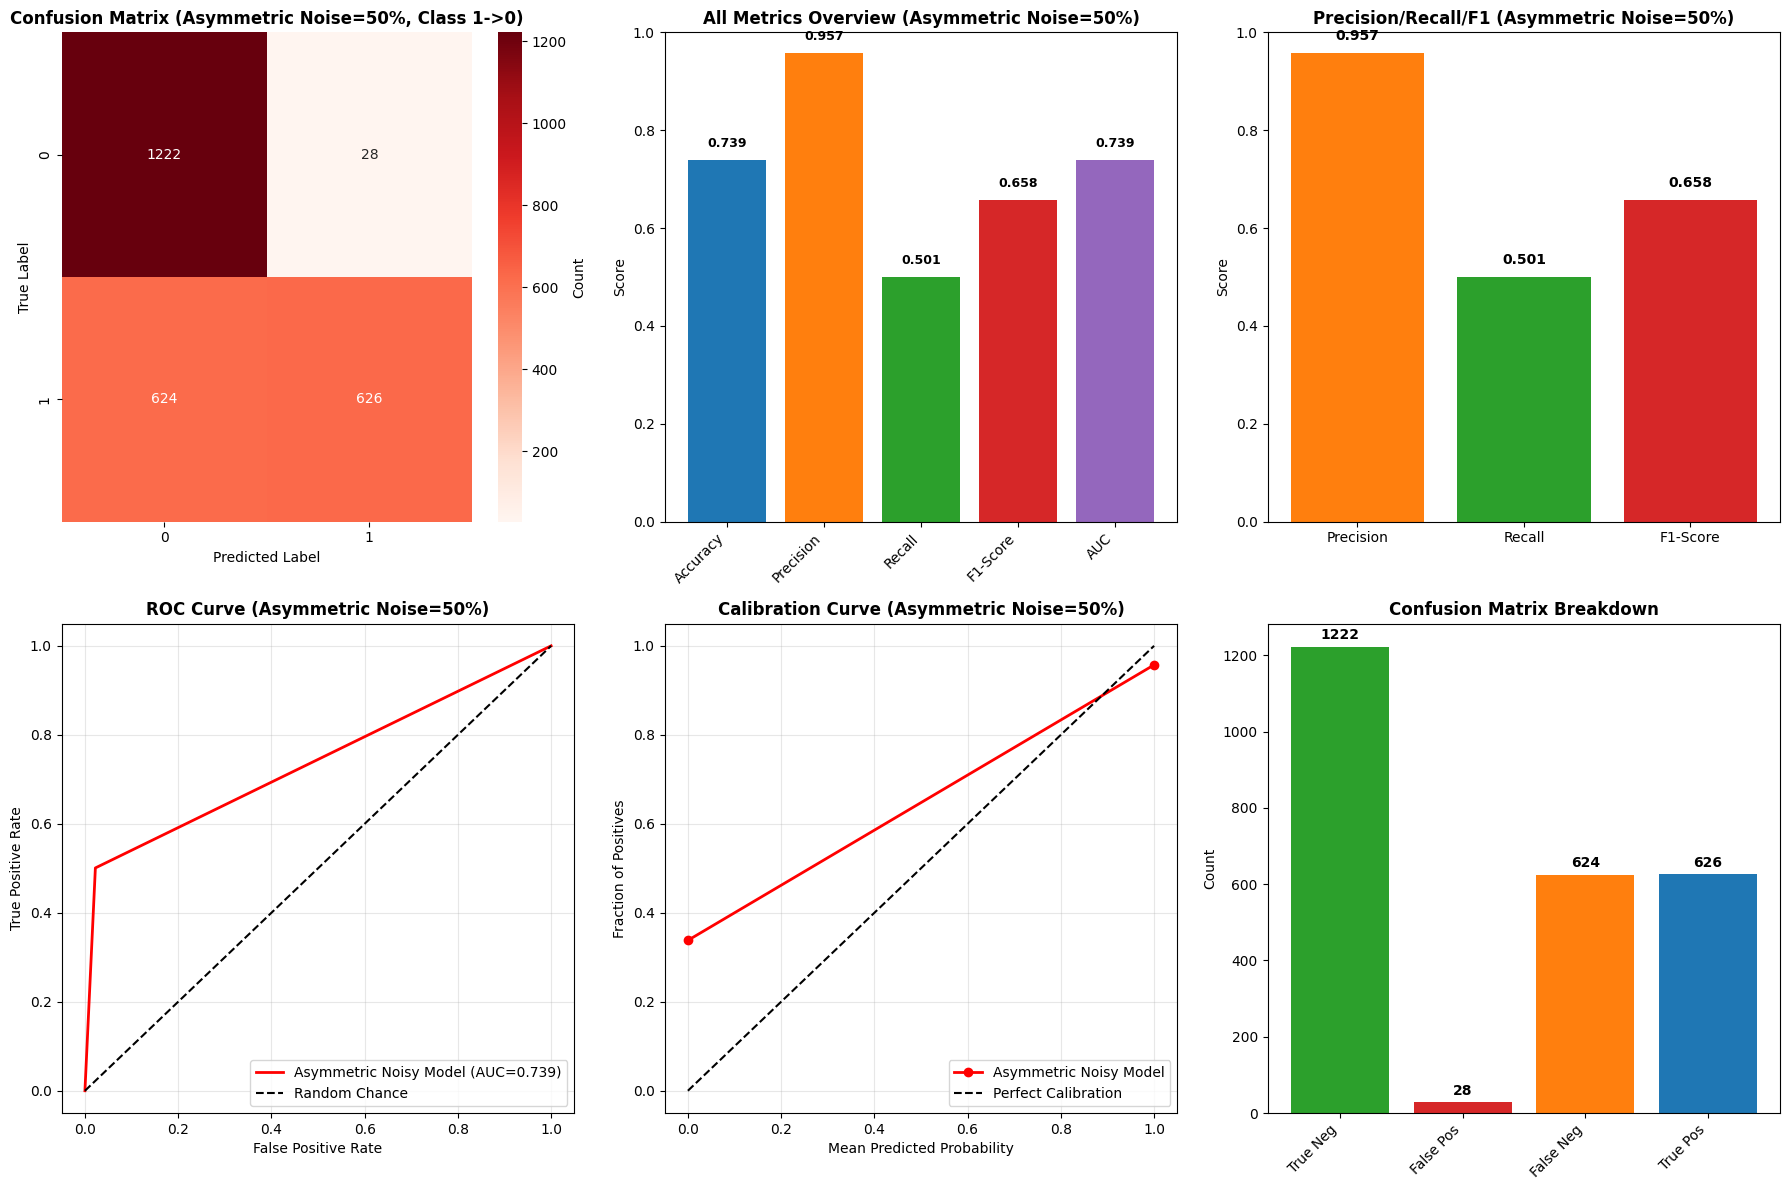


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.66      0.98      0.79      1250
     Default       0.96      0.50      0.66      1250

    accuracy                           0.74      2500
   macro avg       0.81      0.74      0.72      2500
weighted avg       0.81      0.74      0.72      2500



In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                            recall_score, f1_score, roc_curve, roc_auc_score,
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_asymmetric_noise(y, class_to_flip, flip_fraction, random_state=42):
    np.random.seed(random_state)
    y_noisy = np.array(y).copy().astype(int)
    idx = np.where(y_noisy == class_to_flip)[0]
    n_flip = int(len(idx) * flip_fraction)
    flip_idx = np.random.choice(idx, size=n_flip, replace=False)
    y_noisy[flip_idx] = 1 - class_to_flip
    return y_noisy

class_to_flip = 1
p = 0.50
y_train_noisy = inject_asymmetric_noise(y_train, class_to_flip=class_to_flip, flip_fraction=p)

print("Original label distribution:", np.bincount(y_train.astype(int)))
print("Asymmetric noisy label distribution:", np.bincount(y_train_noisy))
print(f"Flipped class {class_to_flip} -> {1-class_to_flip} at rate {p}")

dt_noisy = DecisionTreeClassifier(
    random_state=42
)
dt_noisy.fit(X_train, y_train_noisy)

y_pred_noisy = dt_noisy.predict(X_test)
y_prob_noisy = dt_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results_dt" not in results:
    results["noise_results_dt"] = {}

results["noise_results_dt"][f"asymmetric_{class_to_flip}_{p}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"DECISION TREE WITH {int(p*100)}% ASYMMETRIC NOISE (Class {class_to_flip} -> {1-class_to_flip})")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Asymmetric Noise={int(p*100)}%, Class {class_to_flip}->{1-class_to_flip})', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Asymmetric Noisy Model (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Asymmetric Noisy Model', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Asymmetric Noise={int(p*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01,
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

Noise 3 = Randomly pick 10% of labels and flip them.

Original label distribution: [3750 3750]
Random flip noisy label distribution: [3770 3730]
Random flip rate: 0.1

DECISION TREE WITH 10% RANDOM LABEL FLIP
Accuracy:  0.8696
Precision: 0.8775
Recall:    0.8592
F1 Score:  0.8682
AUC Score: 0.8696



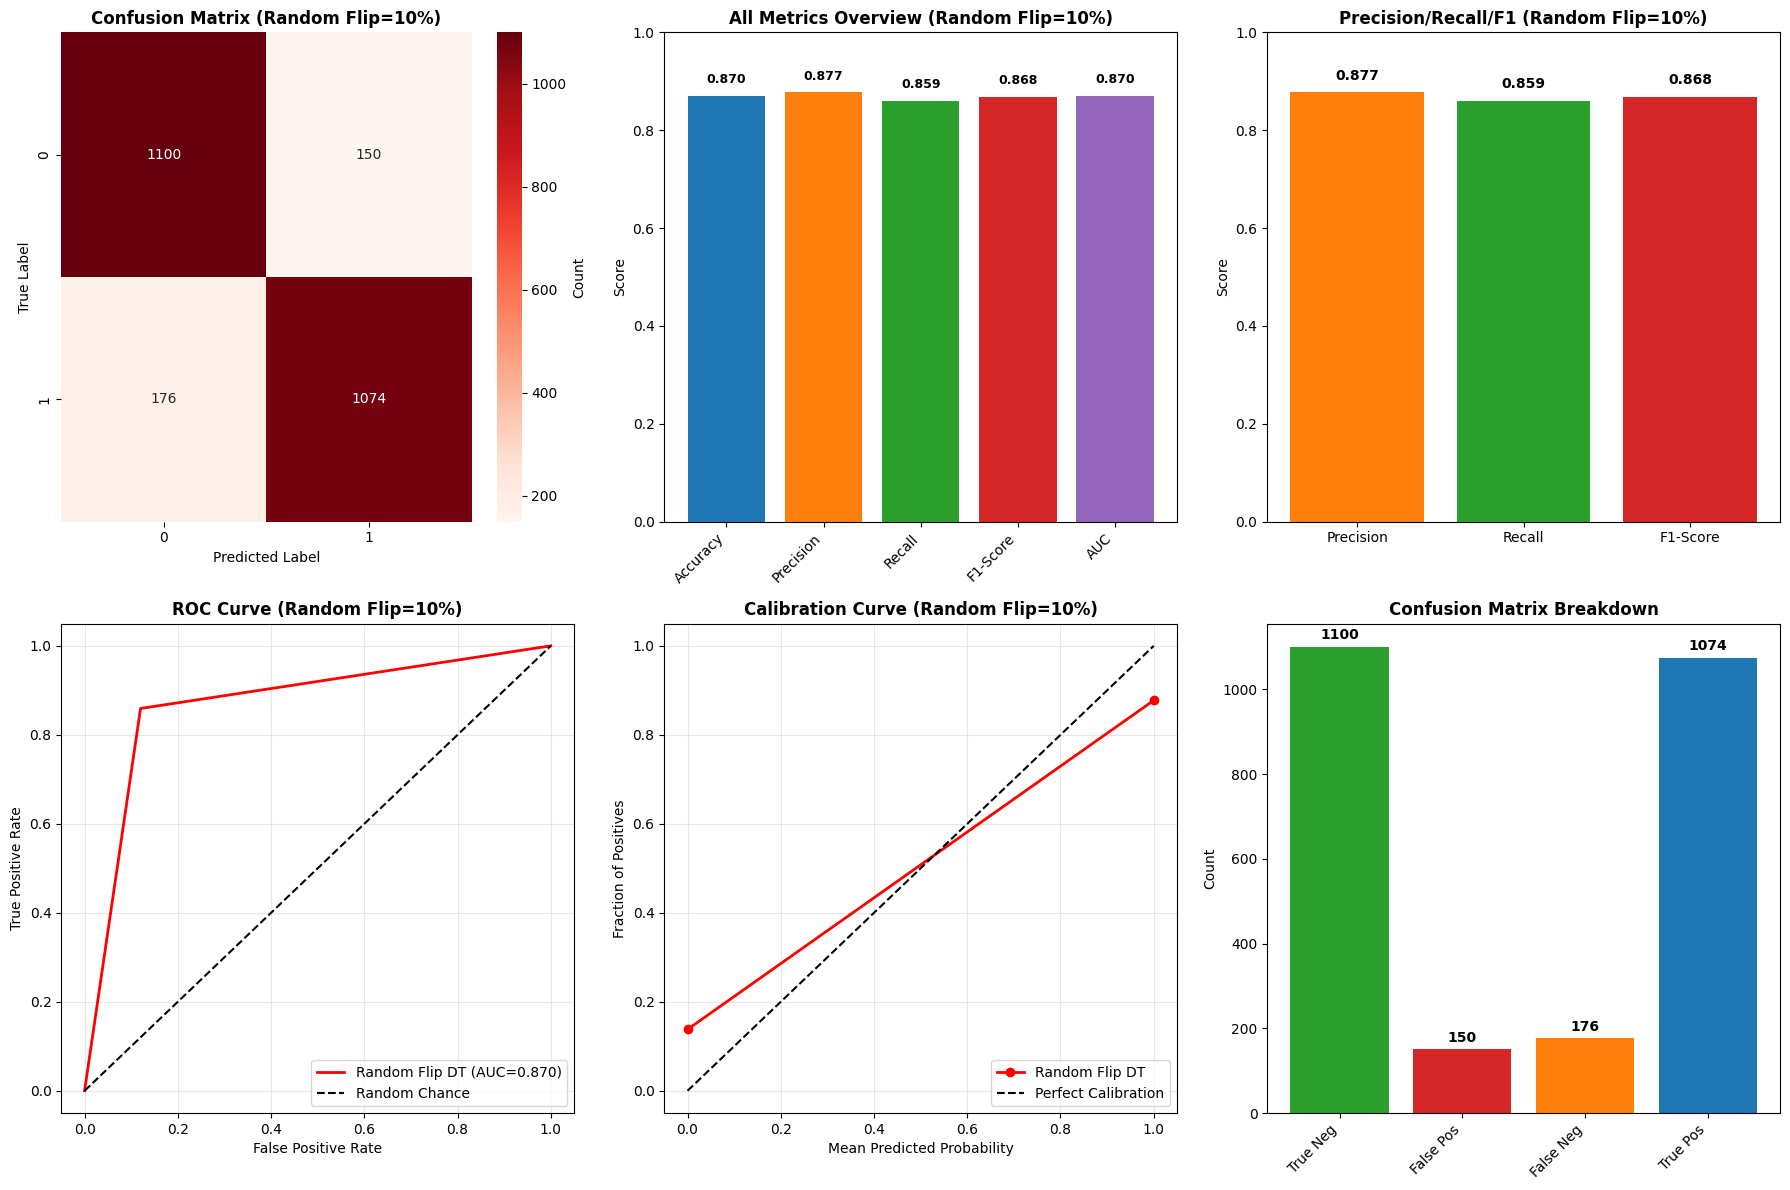


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.86      0.88      0.87      1250
     Default       0.88      0.86      0.87      1250

    accuracy                           0.87      2500
   macro avg       0.87      0.87      0.87      2500
weighted avg       0.87      0.87      0.87      2500



In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                            recall_score, f1_score, roc_curve, roc_auc_score,
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_random_label_flip(y, flip_rate, random_state=42):
    np.random.seed(random_state)
    y_noisy = np.array(y).copy().astype(int)
    n_samples = len(y)
    n_flip = int(flip_rate * n_samples)
    flip_indices = np.random.choice(n_samples, size=n_flip, replace=False)
    y_noisy[flip_indices] = 1 - y_noisy[flip_indices]
    return y_noisy

flip_rate = 0.10
y_train_noisy = inject_random_label_flip(y_train, flip_rate)

print("Original label distribution:", np.bincount(y_train.astype(int)))
print("Random flip noisy label distribution:", np.bincount(y_train_noisy))
print(f"Random flip rate: {flip_rate}")

dt_noisy = DecisionTreeClassifier(
    random_state=42
)
dt_noisy.fit(X_train, y_train_noisy)

y_pred_noisy = dt_noisy.predict(X_test)
y_prob_noisy = dt_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results_dt" not in results:
    results["noise_results_dt"] = {}

results["noise_results_dt"][f"random_flip_{flip_rate}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"DECISION TREE WITH {int(flip_rate*100)}% RANDOM LABEL FLIP")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Random Flip DT (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Random Flip DT', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01,
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

Original label distribution: [3750 3750]
Random flip noisy label distribution: [3752 3748]
Random flip rate: 0.2

DECISION TREE WITH 20% RANDOM LABEL FLIP
Accuracy:  0.7744
Precision: 0.7753
Recall:    0.7728
F1 Score:  0.7740
AUC Score: 0.7744



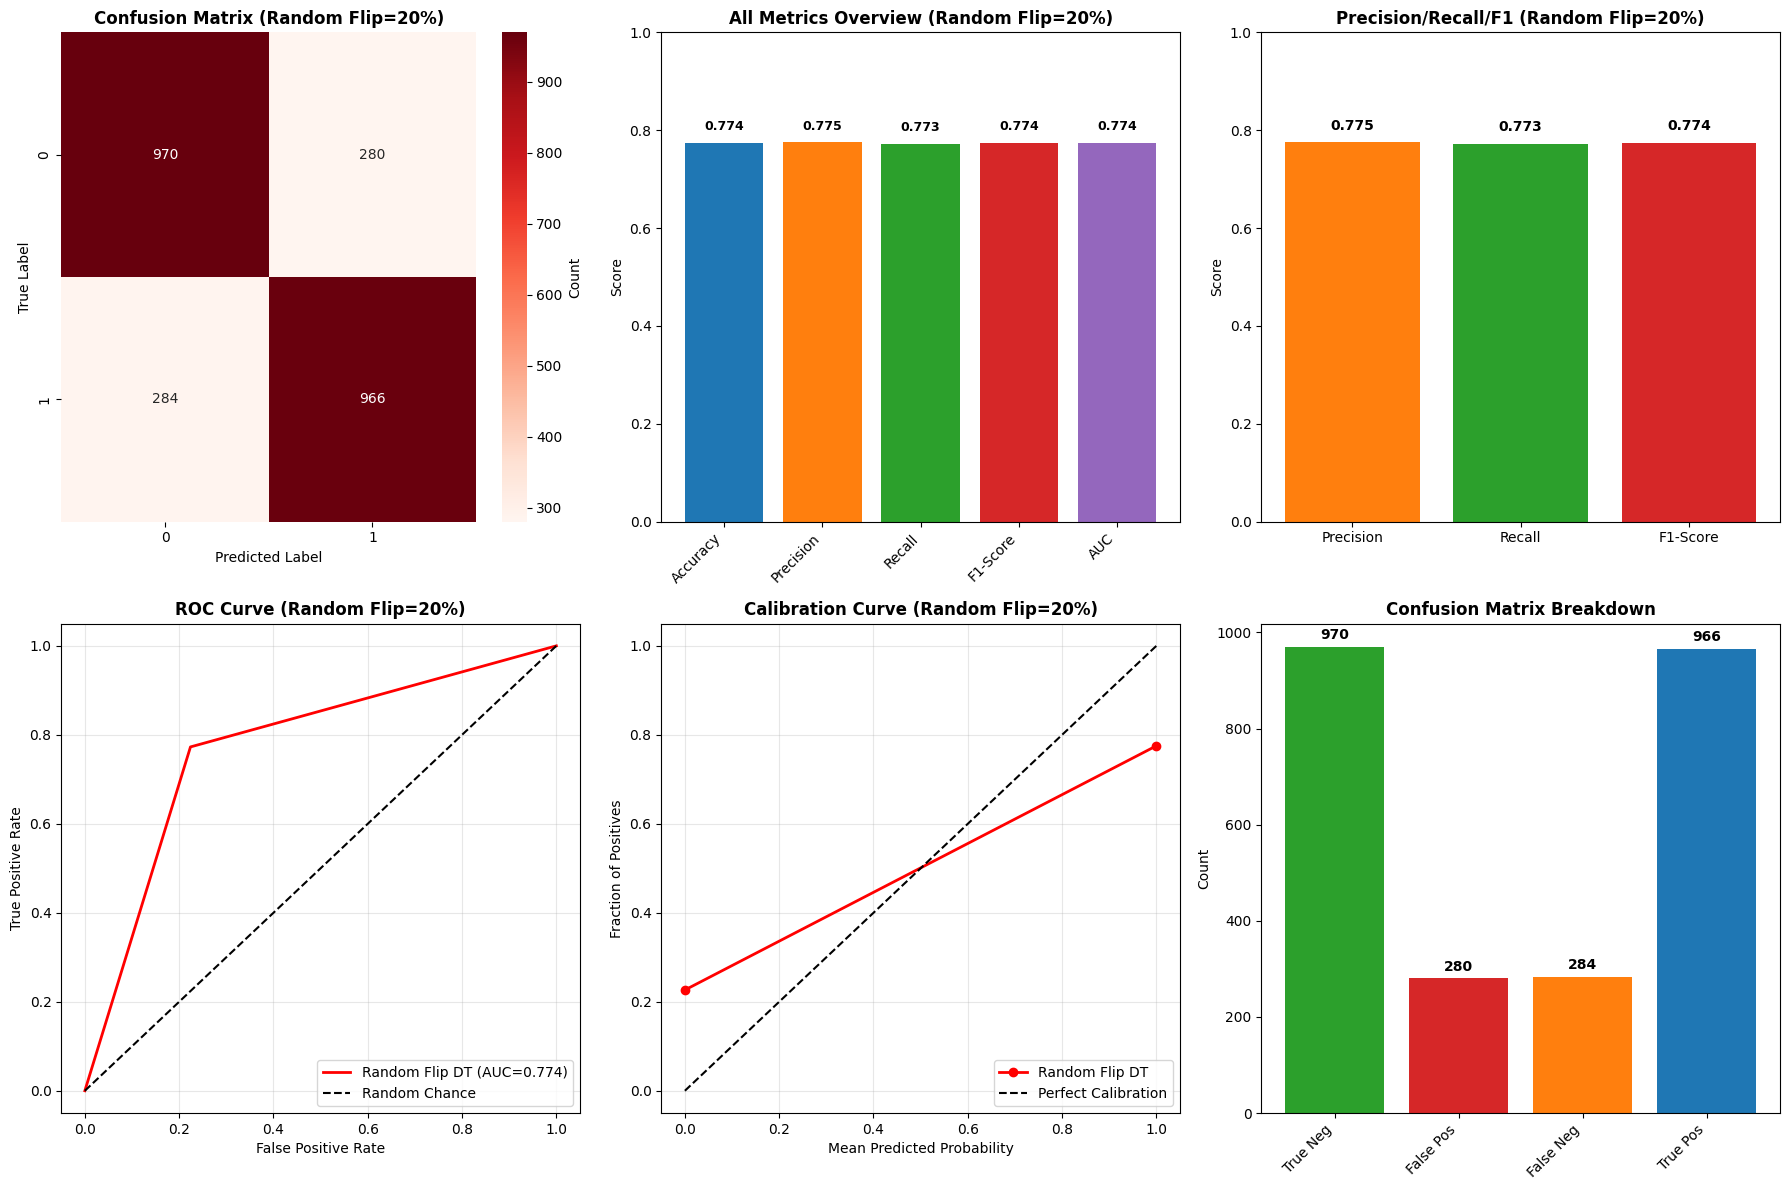


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.77      0.78      0.77      1250
     Default       0.78      0.77      0.77      1250

    accuracy                           0.77      2500
   macro avg       0.77      0.77      0.77      2500
weighted avg       0.77      0.77      0.77      2500



In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                            recall_score, f1_score, roc_curve, roc_auc_score,
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_random_label_flip(y, flip_rate, random_state=42):
    np.random.seed(random_state)
    y_noisy = np.array(y).copy().astype(int)
    n_samples = len(y)
    n_flip = int(flip_rate * n_samples)
    flip_indices = np.random.choice(n_samples, size=n_flip, replace=False)
    y_noisy[flip_indices] = 1 - y_noisy[flip_indices]
    return y_noisy

flip_rate = 0.20
y_train_noisy = inject_random_label_flip(y_train, flip_rate)

print("Original label distribution:", np.bincount(y_train.astype(int)))
print("Random flip noisy label distribution:", np.bincount(y_train_noisy))
print(f"Random flip rate: {flip_rate}")

dt_noisy = DecisionTreeClassifier(
    random_state=42
)
dt_noisy.fit(X_train, y_train_noisy)

y_pred_noisy = dt_noisy.predict(X_test)
y_prob_noisy = dt_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results_dt" not in results:
    results["noise_results_dt"] = {}

results["noise_results_dt"][f"random_flip_{flip_rate}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"DECISION TREE WITH {int(flip_rate*100)}% RANDOM LABEL FLIP")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Random Flip DT (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Random Flip DT', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01,
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

Original label distribution: [3750 3750]
Random flip noisy label distribution: [3743 3757]
Random flip rate: 0.33

DECISION TREE WITH 33% RANDOM LABEL FLIP
Accuracy:  0.6600
Precision: 0.6572
Recall:    0.6688
F1 Score:  0.6630
AUC Score: 0.6600



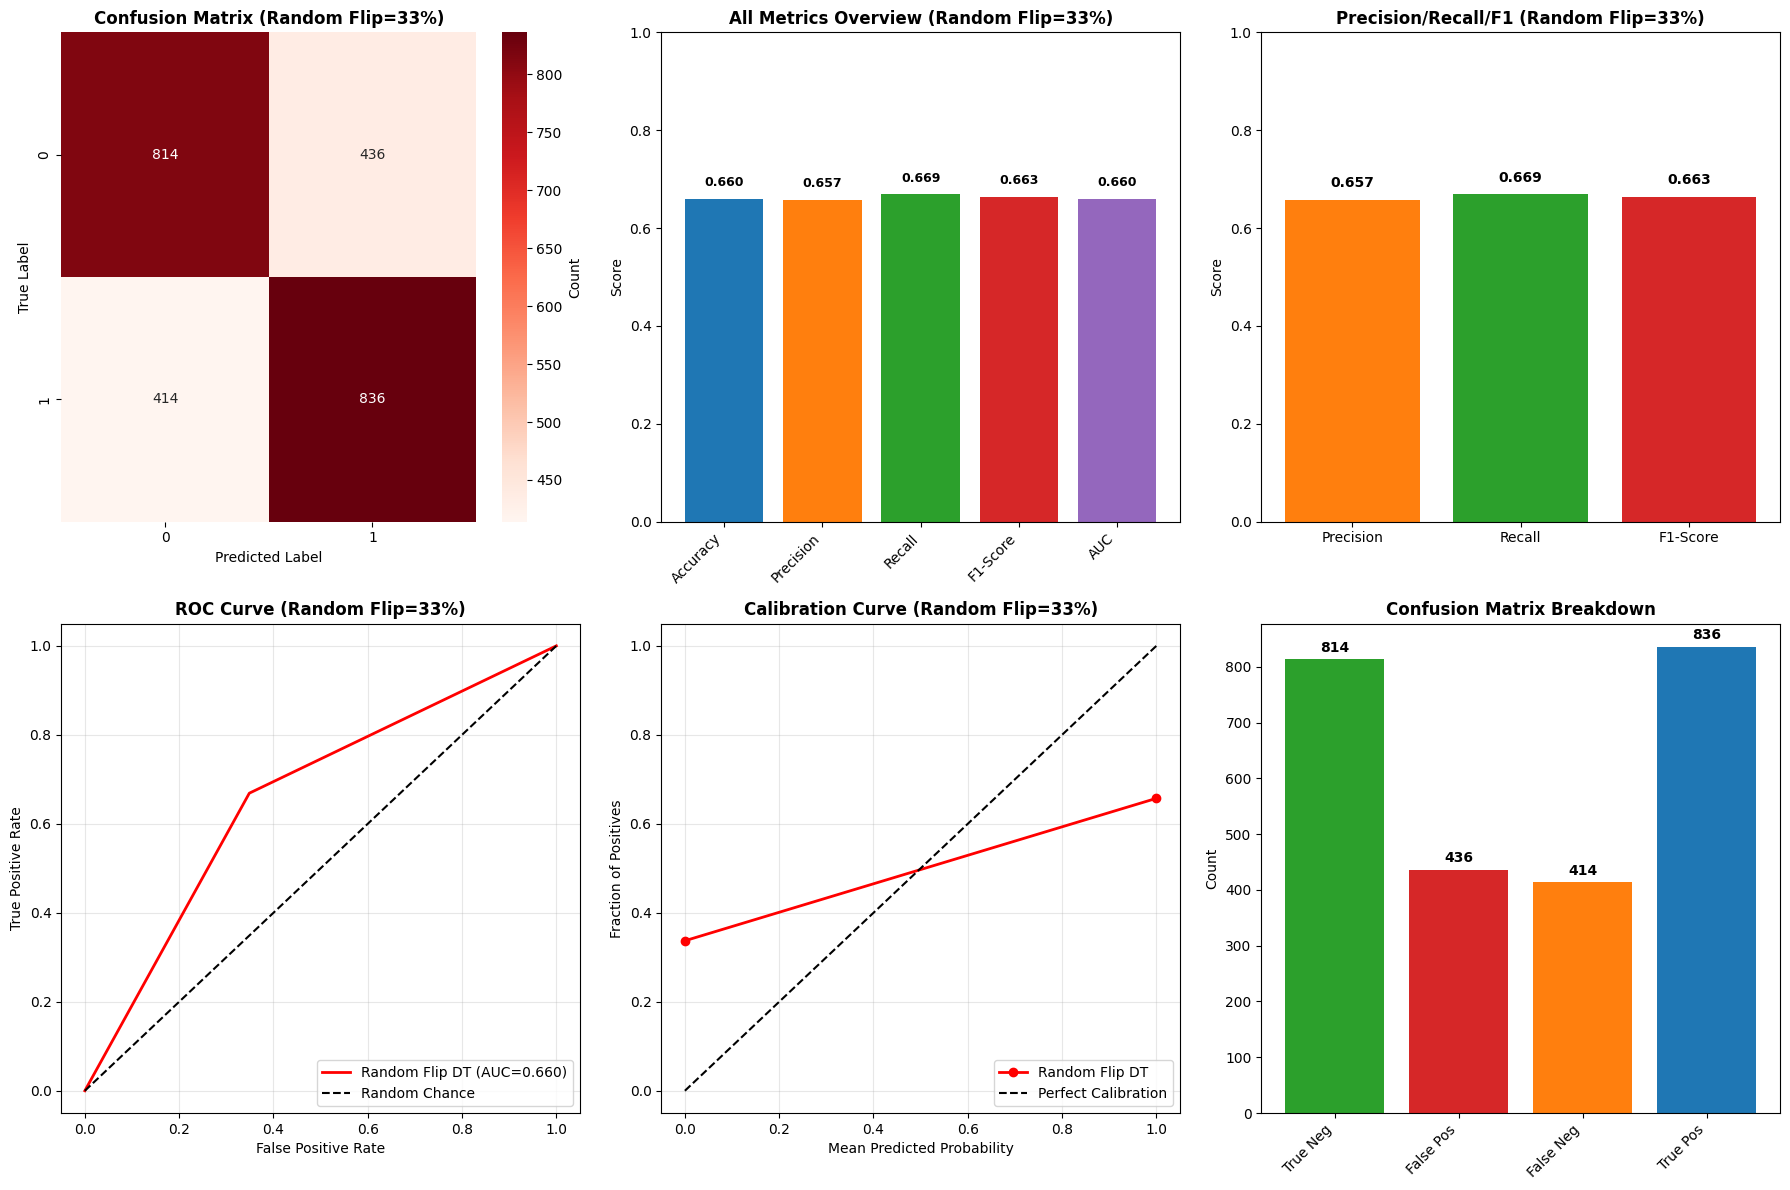


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.66      0.65      0.66      1250
     Default       0.66      0.67      0.66      1250

    accuracy                           0.66      2500
   macro avg       0.66      0.66      0.66      2500
weighted avg       0.66      0.66      0.66      2500



In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                            recall_score, f1_score, roc_curve, roc_auc_score,
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_random_label_flip(y, flip_rate, random_state=42):
    np.random.seed(random_state)
    y_noisy = np.array(y).copy().astype(int)
    n_samples = len(y)
    n_flip = int(flip_rate * n_samples)
    flip_indices = np.random.choice(n_samples, size=n_flip, replace=False)
    y_noisy[flip_indices] = 1 - y_noisy[flip_indices]
    return y_noisy

flip_rate = 0.33
y_train_noisy = inject_random_label_flip(y_train, flip_rate)

print("Original label distribution:", np.bincount(y_train.astype(int)))
print("Random flip noisy label distribution:", np.bincount(y_train_noisy))
print(f"Random flip rate: {flip_rate}")

dt_noisy = DecisionTreeClassifier(
    random_state=42
)
dt_noisy.fit(X_train, y_train_noisy)

y_pred_noisy = dt_noisy.predict(X_test)
y_prob_noisy = dt_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results_dt" not in results:
    results["noise_results_dt"] = {}

results["noise_results_dt"][f"random_flip_{flip_rate}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"DECISION TREE WITH {int(flip_rate*100)}% RANDOM LABEL FLIP")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Random Flip DT (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Random Flip DT', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01,
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

Original label distribution: [3750 3750]
Random flip noisy label distribution: [3826 3674]
Random flip rate: 0.5

DECISION TREE WITH 50% RANDOM LABEL FLIP
Accuracy:  0.5120
Precision: 0.5121
Recall:    0.5096
F1 Score:  0.5108
AUC Score: 0.5120



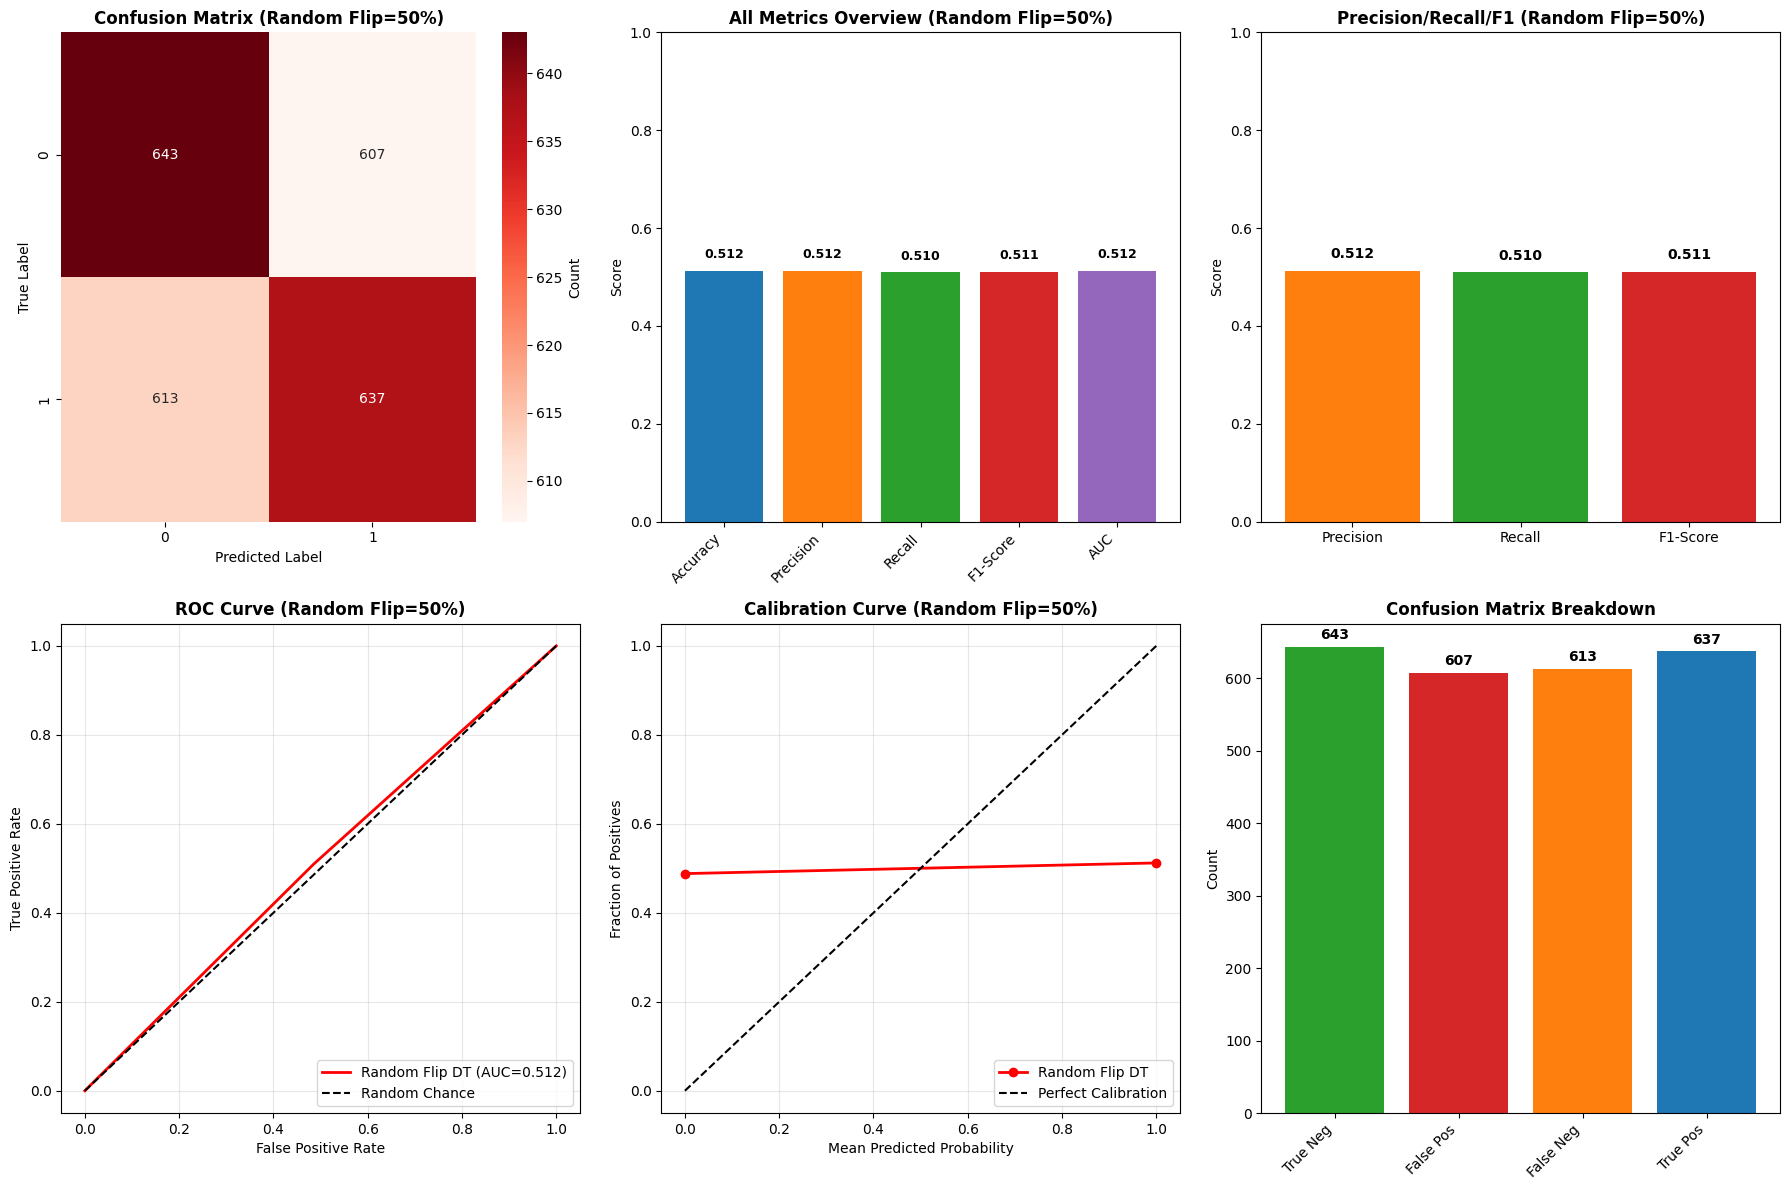


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.51      0.51      0.51      1250
     Default       0.51      0.51      0.51      1250

    accuracy                           0.51      2500
   macro avg       0.51      0.51      0.51      2500
weighted avg       0.51      0.51      0.51      2500



In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                            recall_score, f1_score, roc_curve, roc_auc_score,
                            classification_report)
from sklearn.calibration import calibration_curve

def inject_random_label_flip(y, flip_rate, random_state=42):
    np.random.seed(random_state)
    y_noisy = np.array(y).copy().astype(int)
    n_samples = len(y)
    n_flip = int(flip_rate * n_samples)
    flip_indices = np.random.choice(n_samples, size=n_flip, replace=False)
    y_noisy[flip_indices] = 1 - y_noisy[flip_indices]
    return y_noisy

flip_rate = 0.50
y_train_noisy = inject_random_label_flip(y_train, flip_rate)

print("Original label distribution:", np.bincount(y_train.astype(int)))
print("Random flip noisy label distribution:", np.bincount(y_train_noisy))
print(f"Random flip rate: {flip_rate}")

dt_noisy = DecisionTreeClassifier(
    random_state=42
)
dt_noisy.fit(X_train, y_train_noisy)

y_pred_noisy = dt_noisy.predict(X_test)
y_prob_noisy = dt_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

if "noise_results_dt" not in results:
    results["noise_results_dt"] = {}

results["noise_results_dt"][f"random_flip_{flip_rate}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"DECISION TREE WITH {int(flip_rate*100)}% RANDOM LABEL FLIP")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1 (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'Random Flip DT (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='Random Flip DT', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve (Random Flip={int(flip_rate*100)}%)', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01,
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

Noise 4 = Label Noise via Confusion Matrix (Transition Matrix Noise) 0->1(20%) and 1->0(5%)

Original label distribution: [3750 3750]
Noisy label distribution:    [3225 4275]
Noise rates: 0→1=0.2, 1→0=0.05

LOGISTIC REGRESSION WITH CONFUSION MATRIX NOISE (0→1=0.2, 1→0=0.05)
Accuracy:  0.9496
Precision: 0.9432
Recall:    0.9568
F1 Score:  0.9500
AUC Score: 0.9899



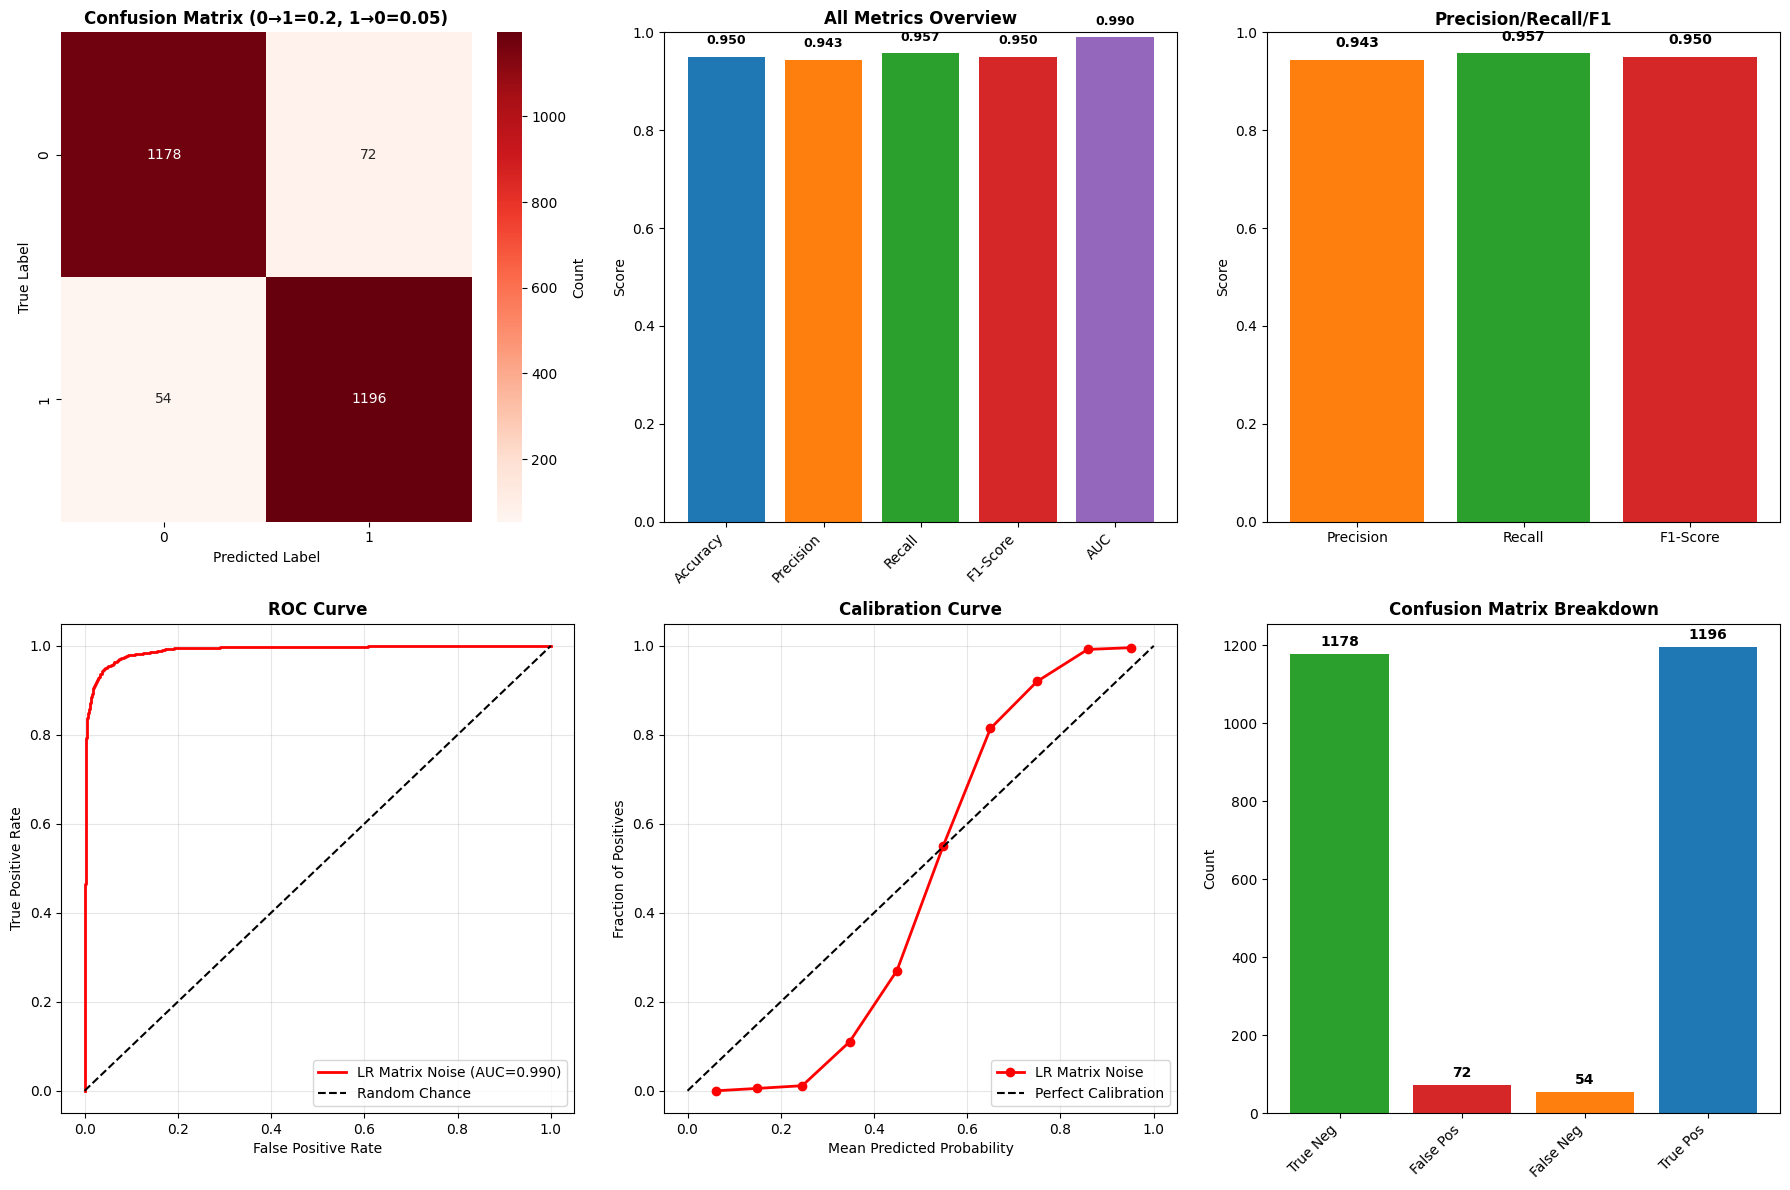


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.96      0.94      0.95      1250
     Default       0.94      0.96      0.95      1250

    accuracy                           0.95      2500
   macro avg       0.95      0.95      0.95      2500
weighted avg       0.95      0.95      0.95      2500



In [26]:
"""
I introduced label noise via confusion matrix (transition matrix) to my training labels.
I used two noise parameters: eta_01 for flipping class 0 to 1, and eta_10 for flipping class 1 to 0.
I trained a new Logistic Regression model on the noisy labels.
I evaluated this noisy model using all five metrics: Accuracy, Confusion Matrix, Precision/Recall/F1, ROC-AUC, and Calibration.
I created comprehensive visualizations to compare the confusion matrix noisy model's performance.
I stored all results for comparison with baseline and other noise models.
"""
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                            recall_score, f1_score, roc_curve, roc_auc_score,
                            classification_report)
from sklearn.calibration import calibration_curve

# ---------------------------------------------------------
# CONFUSION MATRIX NOISE FUNCTION (Safe for floats)
# ---------------------------------------------------------
def apply_confusion_matrix_noise(y, eta_01, eta_10, random_state=42):
    """
    Flip 0 -> 1 with probability eta_01
    Flip 1 -> 0 with probability eta_10
    """
    np.random.seed(random_state)

    # Cast to int immediately for stability
    y_noisy = np.array(y).copy().astype(int)

    # 1. Flip Class 0 -> 1
    idx0 = np.where(y_noisy == 0)[0]
    n0 = int(len(idx0) * eta_01)
    flip0 = np.random.choice(idx0, size=n0, replace=False)
    y_noisy[flip0] = 1

    # 2. Flip Class 1 -> 0
    idx1 = np.where(y_noisy == 1)[0]
    n1 = int(len(idx1) * eta_10)
    flip1 = np.random.choice(idx1, size=n1, replace=False)
    y_noisy[flip1] = 0

    return y_noisy

# ---------------------------------------------------------
# SETUP EXPERIMENT
# ---------------------------------------------------------
eta_01 = 0.20  # 20% of 'No Default' are labeled as 'Default' (False Alarms)
eta_10 = 0.05  # 5% of 'Default' are labeled as 'No Default' (Missed Detections)

# Inject Noise
y_train_noisy = apply_confusion_matrix_noise(y_train.values, eta_01, eta_10)

print("Original label distribution:", np.bincount(y_train.astype(int)))
print("Noisy label distribution:   ", np.bincount(y_train_noisy))
print(f"Noise rates: 0→1={eta_01}, 1→0={eta_10}")

# ---------------------------------------------------------
# TRAIN LOGISTIC REGRESSION
# ---------------------------------------------------------
lr_noisy = LogisticRegression(
    solver='liblinear',
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)

lr_noisy.fit(X_train, y_train_noisy)

# ---------------------------------------------------------
# EVALUATE
# ---------------------------------------------------------
y_pred_noisy = lr_noisy.predict(X_test)
y_prob_noisy = lr_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

# Store Results (Using 'noise_results_lr' key)
if "noise_results_lr" not in results:
    results["noise_results_lr"] = {}

results["noise_results_lr"][f"confusion_matrix_{eta_01}_{eta_10}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"LOGISTIC REGRESSION WITH CONFUSION MATRIX NOISE (0→1={eta_01}, 1→0={eta_10})")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

# ---------------------------------------------------------
# VISUALIZATION (6-Panel Plot)
# ---------------------------------------------------------
fig = plt.figure(figsize=(18, 12))

# 1. Confusion Matrix
plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (0→1={eta_01}, 1→0={eta_10})', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 2. All Metrics Overview
plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. Precision/Recall/F1
plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. ROC Curve
plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'LR Matrix Noise (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 5. Calibration Curve
plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='LR Matrix Noise', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 6. CM Breakdown
plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01,
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

Original label distribution: [3750 3750]
Noisy label distribution:    [2437 5063]
Noise rates: 0→1=0.5, 1→0=0.1

LOGISTIC REGRESSION WITH CONFUSION MATRIX NOISE (0→1=0.5, 1→0=0.1)
Accuracy:  0.9140
Precision: 0.8923
Recall:    0.9416
F1 Score:  0.9163
AUC Score: 0.9732



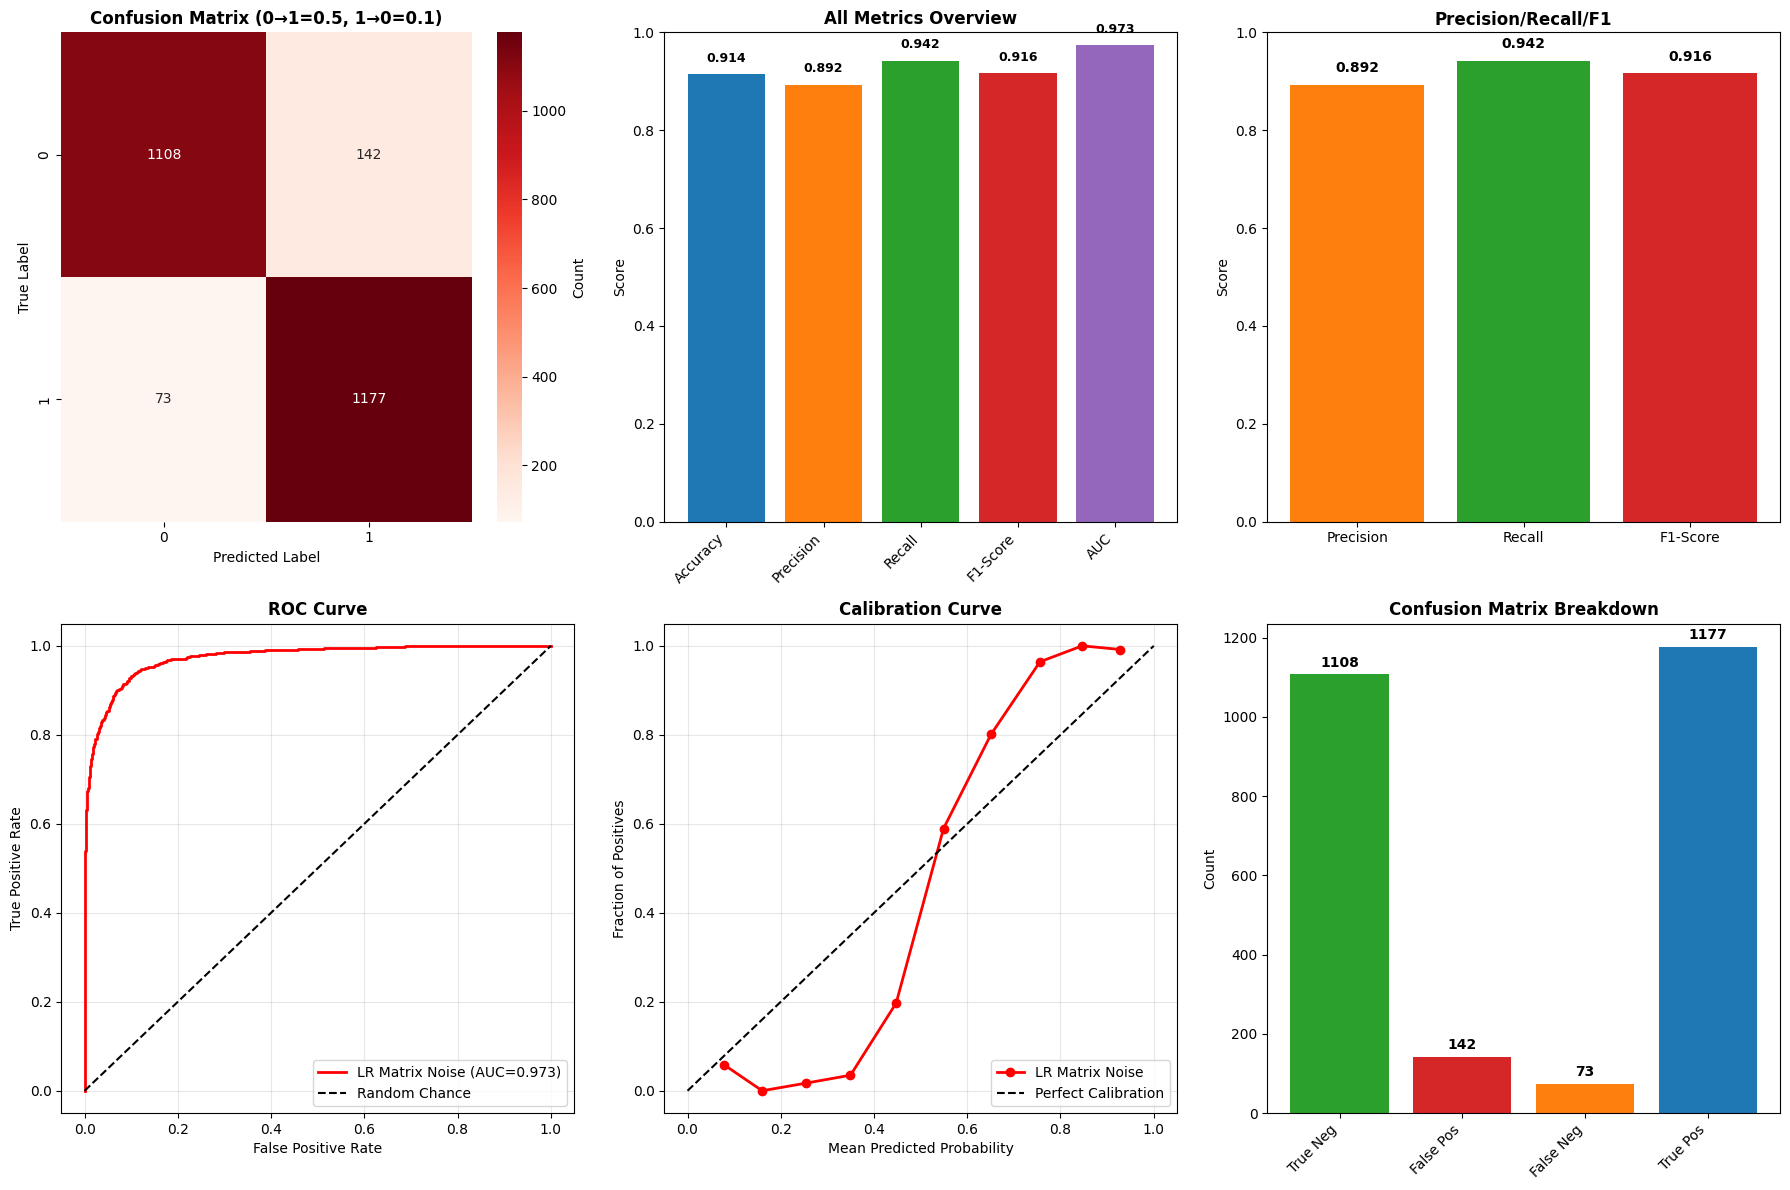


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.94      0.89      0.91      1250
     Default       0.89      0.94      0.92      1250

    accuracy                           0.91      2500
   macro avg       0.92      0.91      0.91      2500
weighted avg       0.92      0.91      0.91      2500



In [40]:
"""
I introduced label noise via confusion matrix (transition matrix) to my training labels.
I used two noise parameters: eta_01=0.50 (50% False Positives) and eta_10=0.10 (10% False Negatives).
I trained a new Logistic Regression model on the noisy labels.
I evaluated this noisy model using all five metrics: Accuracy, Confusion Matrix, Precision/Recall/F1, ROC-AUC, and Calibration.
I created comprehensive visualizations to compare the performance.
I stored all results for comparison with baseline and other noise models.
"""
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                            recall_score, f1_score, roc_curve, roc_auc_score,
                            classification_report)
from sklearn.calibration import calibration_curve

# ---------------------------------------------------------
# CONFUSION MATRIX NOISE FUNCTION (Safe for floats)
# ---------------------------------------------------------
def apply_confusion_matrix_noise(y, eta_01, eta_10, random_state=42):
    np.random.seed(random_state)

    # Cast to int immediately for stability
    y_noisy = np.array(y).copy().astype(int)

    # 1. Flip Class 0 -> 1 (50% of 0s become 1s)
    idx0 = np.where(y_noisy == 0)[0]
    n0 = int(len(idx0) * eta_01)
    flip0 = np.random.choice(idx0, size=n0, replace=False)
    y_noisy[flip0] = 1

    # 2. Flip Class 1 -> 0 (10% of 1s become 0s)
    idx1 = np.where(y_noisy == 1)[0]
    n1 = int(len(idx1) * eta_10)
    flip1 = np.random.choice(idx1, size=n1, replace=False)
    y_noisy[flip1] = 0

    return y_noisy

# ---------------------------------------------------------
# SETUP EXPERIMENT
# ---------------------------------------------------------
eta_01 = 0.50  # 50% of 'No Default' flipped to 'Default' (Massive False Alarms)
eta_10 = 0.10  # 10% of 'Default' flipped to 'No Default'

# Inject Noise
y_train_noisy = apply_confusion_matrix_noise(y_train.values, eta_01, eta_10)

print("Original label distribution:", np.bincount(y_train.astype(int)))
print("Noisy label distribution:   ", np.bincount(y_train_noisy))
print(f"Noise rates: 0→1={eta_01}, 1→0={eta_10}")

# ---------------------------------------------------------
# TRAIN LOGISTIC REGRESSION
# ---------------------------------------------------------
lr_noisy = LogisticRegression(
    solver='liblinear',
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)

lr_noisy.fit(X_train, y_train_noisy)

# ---------------------------------------------------------
# EVALUATE
# ---------------------------------------------------------
y_pred_noisy = lr_noisy.predict(X_test)
y_prob_noisy = lr_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

# Store Results (Using 'noise_results_lr' key)
if "noise_results_lr" not in results:
    results["noise_results_lr"] = {}

results["noise_results_lr"][f"confusion_matrix_{eta_01}_{eta_10}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"LOGISTIC REGRESSION WITH CONFUSION MATRIX NOISE (0→1={eta_01}, 1→0={eta_10})")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

# ---------------------------------------------------------
# VISUALIZATION (6-Panel Plot)
# ---------------------------------------------------------
fig = plt.figure(figsize=(18, 12))

# 1. Confusion Matrix
plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (0→1={eta_01}, 1→0={eta_10})', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 2. All Metrics Overview
plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. Precision/Recall/F1
plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. ROC Curve
plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'LR Matrix Noise (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 5. Calibration Curve
plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='LR Matrix Noise', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 6. CM Breakdown
plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01,
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

Original label distribution: [3750 3750]
Noisy label distribution:    [4350 3150]
Noise rates: 0→1=0.05, 1→0=0.2

LOGISTIC REGRESSION WITH CONFUSION MATRIX NOISE (0→1=0.05, 1→0=0.2)
Accuracy:  0.9648
Precision: 0.9670
Recall:    0.9624
F1 Score:  0.9647
AUC Score: 0.9940



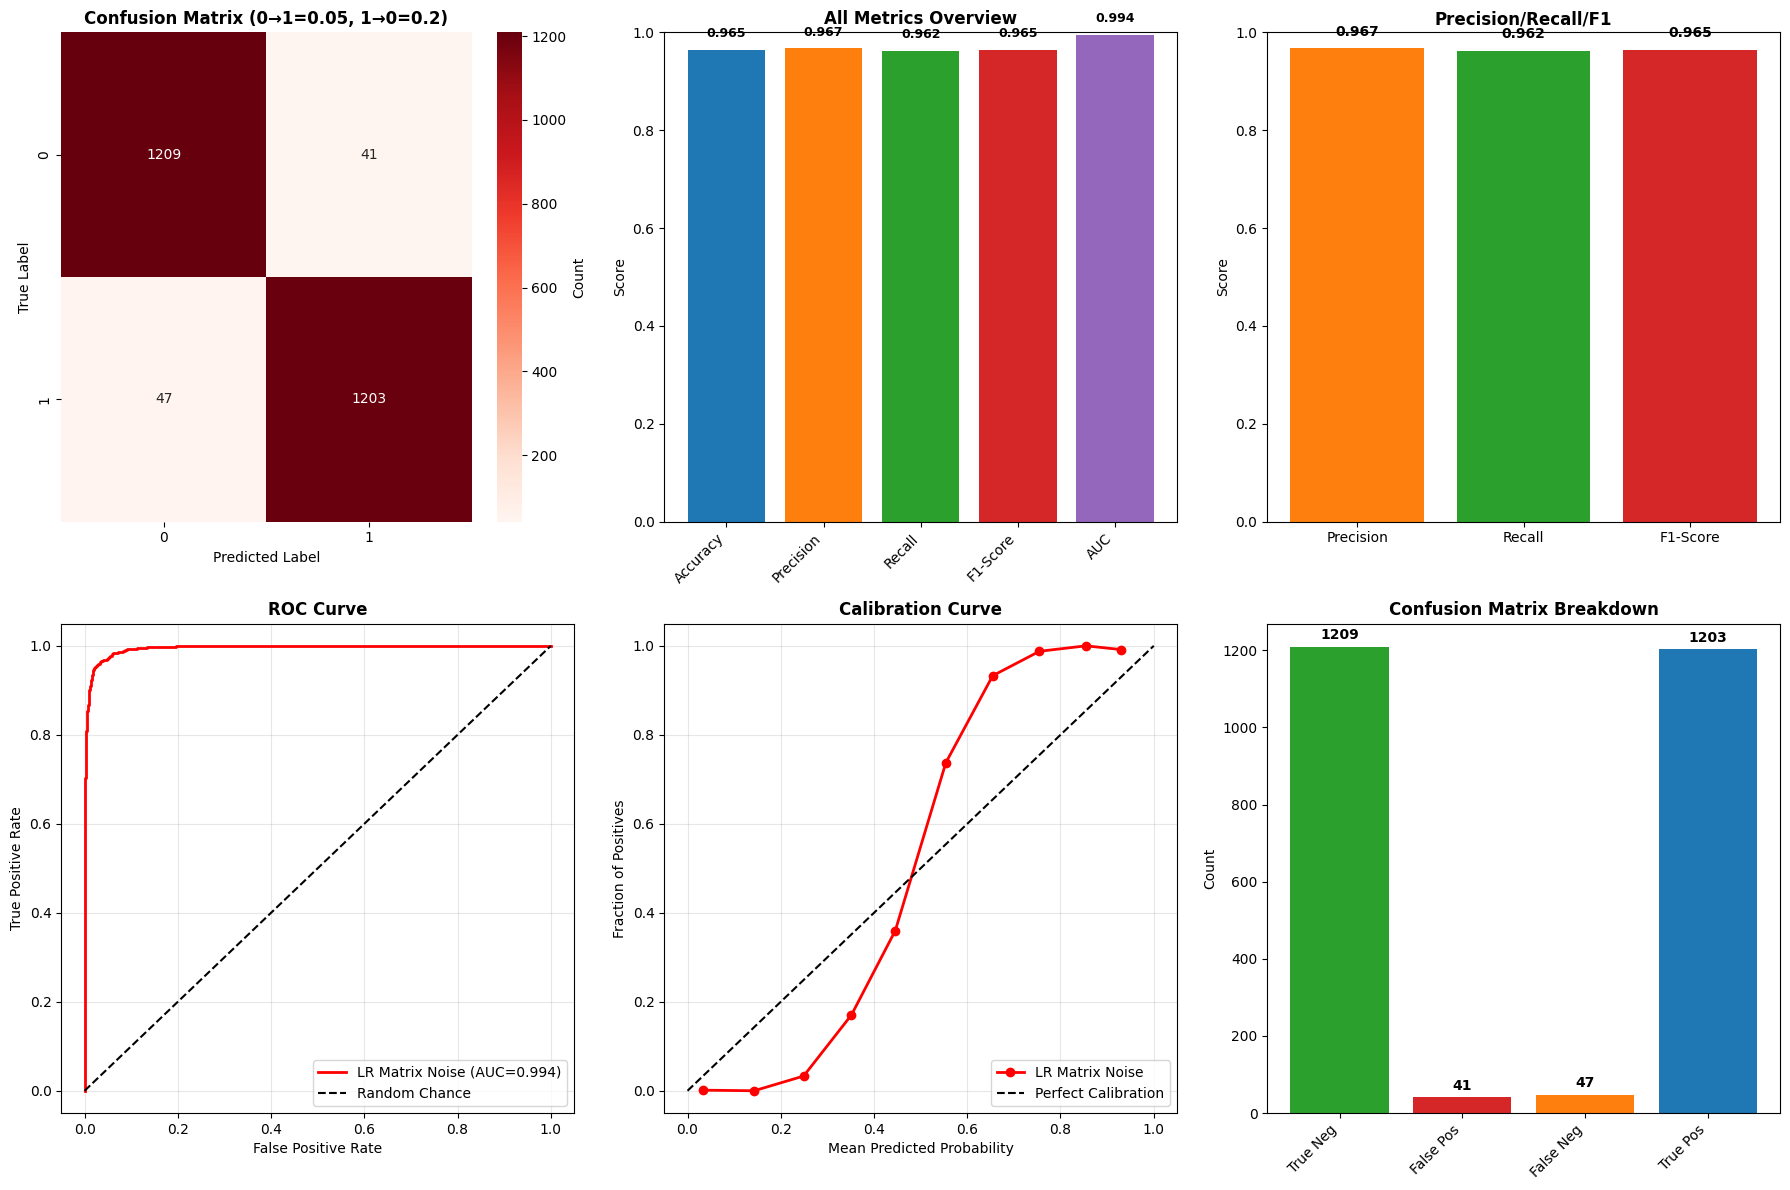


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.96      0.97      0.96      1250
     Default       0.97      0.96      0.96      1250

    accuracy                           0.96      2500
   macro avg       0.96      0.96      0.96      2500
weighted avg       0.96      0.96      0.96      2500



In [41]:
"""
I introduced label noise via confusion matrix (transition matrix) to my training labels.
I used two noise parameters: eta_01=0.05 (5% False Positives) and eta_10=0.20 (20% False Negatives).
I trained a new Logistic Regression model on the noisy labels.
I evaluated this noisy model using all five metrics: Accuracy, Confusion Matrix, Precision/Recall/F1, ROC-AUC, and Calibration.
I created comprehensive visualizations to compare the performance.
I stored all results for comparison with baseline and other noise models.
"""
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                            recall_score, f1_score, roc_curve, roc_auc_score,
                            classification_report)
from sklearn.calibration import calibration_curve

# ---------------------------------------------------------
# CONFUSION MATRIX NOISE FUNCTION (Safe for floats)
# ---------------------------------------------------------
def apply_confusion_matrix_noise(y, eta_01, eta_10, random_state=42):
    np.random.seed(random_state)

    # Cast to int immediately for stability
    y_noisy = np.array(y).copy().astype(int)

    # 1. Flip Class 0 -> 1
    idx0 = np.where(y_noisy == 0)[0]
    n0 = int(len(idx0) * eta_01)
    flip0 = np.random.choice(idx0, size=n0, replace=False)
    y_noisy[flip0] = 1

    # 2. Flip Class 1 -> 0
    idx1 = np.where(y_noisy == 1)[0]
    n1 = int(len(idx1) * eta_10)
    flip1 = np.random.choice(idx1, size=n1, replace=False)
    y_noisy[flip1] = 0

    return y_noisy

# ---------------------------------------------------------
# SETUP EXPERIMENT
# ---------------------------------------------------------
eta_01 = 0.05  # 5% of 'No Default' flipped to 'Default'
eta_10 = 0.20  # 20% of 'Default' flipped to 'No Default'

# Inject Noise
y_train_noisy = apply_confusion_matrix_noise(y_train.values, eta_01, eta_10)

print("Original label distribution:", np.bincount(y_train.astype(int)))
print("Noisy label distribution:   ", np.bincount(y_train_noisy))
print(f"Noise rates: 0→1={eta_01}, 1→0={eta_10}")

# ---------------------------------------------------------
# TRAIN LOGISTIC REGRESSION
# ---------------------------------------------------------
lr_noisy = LogisticRegression(
    solver='liblinear',
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)

lr_noisy.fit(X_train, y_train_noisy)

# ---------------------------------------------------------
# EVALUATE
# ---------------------------------------------------------
y_pred_noisy = lr_noisy.predict(X_test)
y_prob_noisy = lr_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

# Store Results (Using 'noise_results_lr' key)
if "noise_results_lr" not in results:
    results["noise_results_lr"] = {}

results["noise_results_lr"][f"confusion_matrix_{eta_01}_{eta_10}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"LOGISTIC REGRESSION WITH CONFUSION MATRIX NOISE (0→1={eta_01}, 1→0={eta_10})")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

# ---------------------------------------------------------
# VISUALIZATION (6-Panel Plot)
# ---------------------------------------------------------
fig = plt.figure(figsize=(18, 12))

# 1. Confusion Matrix
plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (0→1={eta_01}, 1→0={eta_10})', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 2. All Metrics Overview
plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. Precision/Recall/F1
plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. ROC Curve
plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'LR Matrix Noise (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 5. Calibration Curve
plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='LR Matrix Noise', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 6. CM Breakdown
plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01,
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))

Original label distribution: [3750 3750]
Noisy label distribution:    [5437 2063]
Noise rates: 0→1=0.1, 1→0=0.5

LOGISTIC REGRESSION WITH CONFUSION MATRIX NOISE (0→1=0.1, 1→0=0.5)
Accuracy:  0.9200
Precision: 0.9480
Recall:    0.8888
F1 Score:  0.9174
AUC Score: 0.9782



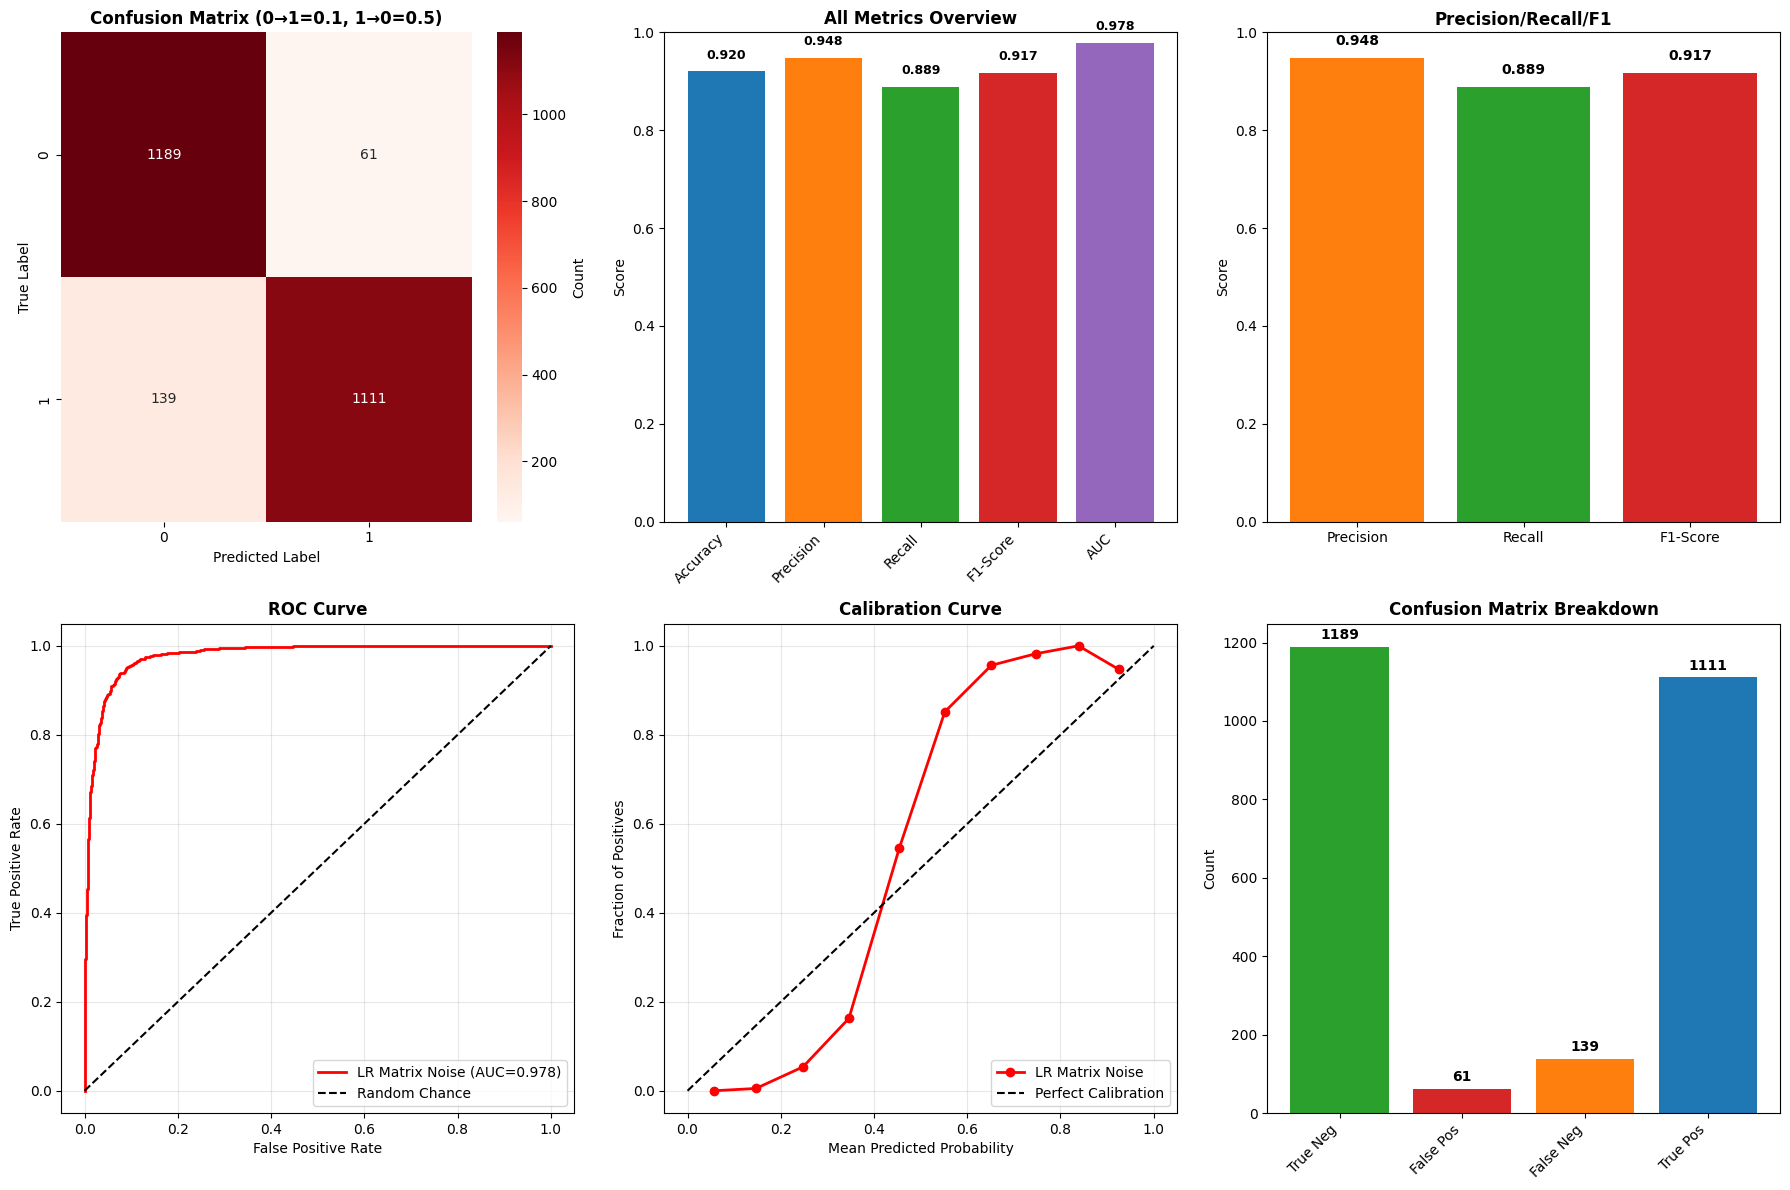


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  No Default       0.90      0.95      0.92      1250
     Default       0.95      0.89      0.92      1250

    accuracy                           0.92      2500
   macro avg       0.92      0.92      0.92      2500
weighted avg       0.92      0.92      0.92      2500



In [30]:
"""
I introduced label noise via confusion matrix (transition matrix) to my training labels.
I used two noise parameters: eta_01=0.10 (10% False Positives) and eta_10=0.50 (50% False Negatives).
I trained a new Logistic Regression model on the noisy labels.
I evaluated this noisy model using all five metrics: Accuracy, Confusion Matrix, Precision/Recall/F1, ROC-AUC, and Calibration.
I created comprehensive visualizations to compare the performance.
I stored all results for comparison with baseline and other noise models.
"""
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                            recall_score, f1_score, roc_curve, roc_auc_score,
                            classification_report)
from sklearn.calibration import calibration_curve

# ---------------------------------------------------------
# CONFUSION MATRIX NOISE FUNCTION (Safe for floats)
# ---------------------------------------------------------
def apply_confusion_matrix_noise(y, eta_01, eta_10, random_state=42):
    """
    Flip 0 -> 1 with probability eta_01
    Flip 1 -> 0 with probability eta_10
    """
    np.random.seed(random_state)

    # Cast to int immediately for stability
    y_noisy = np.array(y).copy().astype(int)

    # 1. Flip Class 0 -> 1
    idx0 = np.where(y_noisy == 0)[0]
    n0 = int(len(idx0) * eta_01)
    flip0 = np.random.choice(idx0, size=n0, replace=False)
    y_noisy[flip0] = 1

    # 2. Flip Class 1 -> 0
    idx1 = np.where(y_noisy == 1)[0]
    n1 = int(len(idx1) * eta_10)
    flip1 = np.random.choice(idx1, size=n1, replace=False)
    y_noisy[flip1] = 0

    return y_noisy

# ---------------------------------------------------------
# SETUP EXPERIMENT
# ---------------------------------------------------------
eta_01 = 0.10  # 10% of 'No Default' flipped to 'Default'
eta_10 = 0.50  # 50% of 'Default' flipped to 'No Default' (Severe Missed Detections)

# Inject Noise
y_train_noisy = apply_confusion_matrix_noise(y_train.values, eta_01, eta_10)

print("Original label distribution:", np.bincount(y_train.astype(int)))
print("Noisy label distribution:   ", np.bincount(y_train_noisy))
print(f"Noise rates: 0→1={eta_01}, 1→0={eta_10}")

# ---------------------------------------------------------
# TRAIN LOGISTIC REGRESSION
# ---------------------------------------------------------
lr_noisy = LogisticRegression(
    solver='liblinear',
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)

lr_noisy.fit(X_train, y_train_noisy)

# ---------------------------------------------------------
# EVALUATE
# ---------------------------------------------------------
y_pred_noisy = lr_noisy.predict(X_test)
y_prob_noisy = lr_noisy.predict_proba(X_test)[:, 1]

acc_noisy = accuracy_score(y_test, y_pred_noisy)
precision_noisy = precision_score(y_test, y_pred_noisy)
recall_noisy = recall_score(y_test, y_pred_noisy)
f1_noisy = f1_score(y_test, y_pred_noisy)
auc_noisy = roc_auc_score(y_test, y_prob_noisy)
cm_noisy = confusion_matrix(y_test, y_pred_noisy)

# Store Results (Using 'noise_results_lr' key)
if "noise_results_lr" not in results:
    results["noise_results_lr"] = {}

results["noise_results_lr"][f"confusion_matrix_{eta_01}_{eta_10}"] = {
    "accuracy": acc_noisy,
    "precision": precision_noisy,
    "recall": recall_noisy,
    "f1": f1_noisy,
    "auc": auc_noisy
}

print(f"\n{'='*60}")
print(f"LOGISTIC REGRESSION WITH CONFUSION MATRIX NOISE (0→1={eta_01}, 1→0={eta_10})")
print(f"{'='*60}")
print(f"Accuracy:  {acc_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall:    {recall_noisy:.4f}")
print(f"F1 Score:  {f1_noisy:.4f}")
print(f"AUC Score: {auc_noisy:.4f}")
print(f"{'='*60}\n")

# ---------------------------------------------------------
# VISUALIZATION (6-Panel Plot)
# ---------------------------------------------------------
fig = plt.figure(figsize=(18, 12))

# 1. Confusion Matrix
plt.subplot(2, 3, 1)
sns.heatmap(cm_noisy, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix (0→1={eta_01}, 1→0={eta_10})', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 2. All Metrics Overview
plt.subplot(2, 3, 2)
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [acc_noisy, precision_noisy, recall_noisy, f1_noisy, auc_noisy]
bars = plt.bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim([0, 1])
plt.title(f'All Metrics Overview', fontsize=12, fontweight='bold')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. Precision/Recall/F1
plt.subplot(2, 3, 3)
categories = ['Precision', 'Recall', 'F1-Score']
values = [precision_noisy, recall_noisy, f1_noisy]
plt.bar(categories, values, color=['#ff7f0e', '#2ca02c', '#d62728'])
plt.ylim([0, 1])
plt.title(f'Precision/Recall/F1', fontsize=12, fontweight='bold')
plt.ylabel('Score')
for i, val in enumerate(values):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. ROC Curve
plt.subplot(2, 3, 4)
fpr_noisy, tpr_noisy, _ = roc_curve(y_test, y_prob_noisy)
plt.plot(fpr_noisy, tpr_noisy, label=f'LR Matrix Noise (AUC={auc_noisy:.3f})', linewidth=2, color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance', linewidth=1.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 5. Calibration Curve
plt.subplot(2, 3, 5)
prob_true_noisy, prob_pred_noisy = calibration_curve(y_test, y_prob_noisy, n_bins=10)
plt.plot(prob_pred_noisy, prob_true_noisy, marker='o', linewidth=2, label='LR Matrix Noise', color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title(f'Calibration Curve', fontsize=12, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

# 6. CM Breakdown
plt.subplot(2, 3, 6)
tn, fp, fn, tp = cm_noisy.ravel()
conf_metrics = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
conf_values = [tn, fp, fn, tp]
colors_conf = ['#2ca02c', '#d62728', '#ff7f0e', '#1f77b4']
bars = plt.bar(conf_metrics, conf_values, color=colors_conf)
plt.title('Confusion Matrix Breakdown', fontsize=12, fontweight='bold')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
for bar, val in zip(bars, conf_values):
    plt.text(bar.get_x() + bar.get_width()/2, val + max(conf_values)*0.01,
             str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred_noisy, target_names=['No Default', 'Default']))